In [43]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.linear_model import LogisticRegression


In [ ]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset

Round 00: Global Acc = 0.2999, Std(Client Acc) = 0.0564, Comm Steps = 15, p_comm = 0.4950
Round 01: Global Acc = 0.3348, Std(Client Acc) = 0.0472, Comm Steps = 12, p_comm = 0.4900
Round 02: Global Acc = 0.5858, Std(Client Acc) = 0.0554, Comm Steps = 12, p_comm = 0.4850
Round 03: Global Acc = 0.5843, Std(Client Acc) = 0.0468, Comm Steps = 12, p_comm = 0.4800
Round 04: Global Acc = 0.5870, Std(Client Acc) = 0.0431, Comm Steps = 12, p_comm = 0.4750
Round 05: Global Acc = 0.6372, Std(Client Acc) = 0.0536, Comm Steps = 14, p_comm = 0.4700
Round 06: Global Acc = 0.6504, Std(Client Acc) = 0.0453, Comm Steps = 11, p_comm = 0.4650
Round 07: Global Acc = 0.7401, Std(Client Acc) = 0.0405, Comm Steps = 10, p_comm = 0.4600
Round 08: Global Acc = 0.6956, Std(Client Acc) = 0.0515, Comm Steps = 12, p_comm = 0.4550
Round 09: Global Acc = 0.7316, Std(Client Acc) = 0.0398, Comm Steps = 9, p_comm = 0.4500
Round 10: Global Acc = 0.7581, Std(Client Acc) = 0.0392, Comm Steps = 8, p_comm = 0.4450
Round 11: Gl

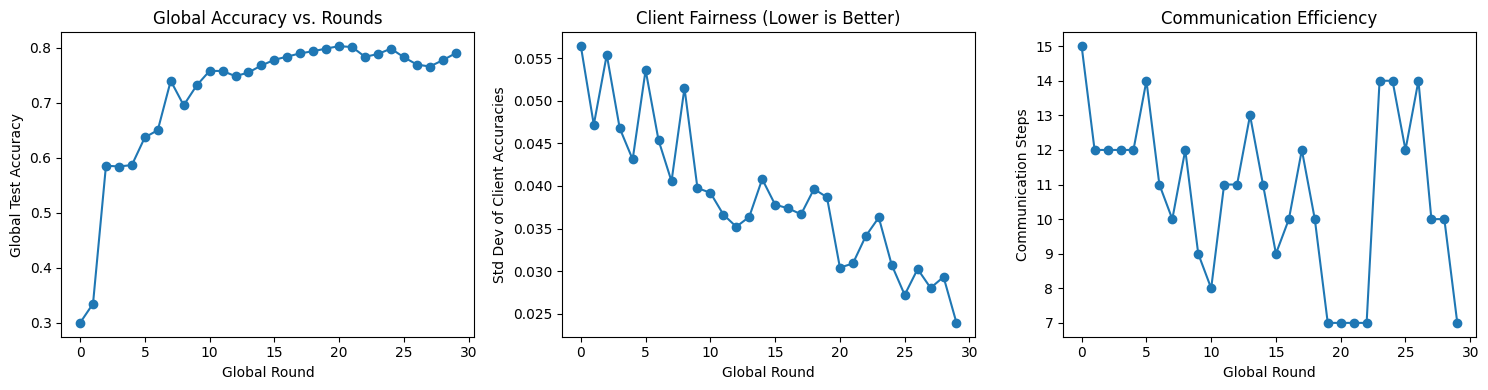


Final Client Accuracies:
Client 0: 0.9826
Client 1: 0.9237
Client 2: 0.9217
Client 3: 0.9660
Client 4: 0.9396


In [ ]:
# ---------------------- Experiment Setup ----------------------
# Choose variant: Options are:
# "A": Proposed (adaptive p, fairness penalty enabled)
# "B": Fixed Communication (constant p, fairness penalty enabled)
# "C": No Fairness Penalty (adaptive p, fairness penalty disabled)
# "D": Local Only (p nearly zero, no communication)
# "E": FedAvg (full communication every round)
variant = "C"  # change as needed

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Hyperparameters common to all variants
num_clients = 5
num_outer = 30       # number of global rounds
num_inner = 5        # number of local steps per round
outer_lr = 0.5       # global update smoothing weight
inner_lr = 0.01      # local learning rate
rho = 0.1            # consensus regularization weight
eta_default = 0.1    # fairness penalty weight

# Variant-specific hyperparameters:
if variant == "A":      # Proposed: adaptive p and fairness penalty enabled.
    p_comm = 0.5      # initial adaptive communication probability
    eta = eta_default
    adaptive_p = True
elif variant == "B":    # Fixed Communication: constant p (e.g., 0.5) and fairness penalty enabled.
    p_comm = 0.5
    eta = eta_default
    adaptive_p = False
elif variant == "C":    # No Fairness Penalty: adaptive p but fairness penalty disabled.
    p_comm = 0.5
    eta = 0.0
    adaptive_p = True
elif variant == "D":    # Local Only: communication probability nearly zero.
    p_comm = 0.05
    eta = eta_default
    adaptive_p = True  # p might update, but it starts low.
elif variant == "E":    # FedAvg: full communication every round.
    p_comm = 1.0
    eta = 0.0          # No extra fairness penalty.
    adaptive_p = False
else:
    raise ValueError("Unknown variant. Choose among A, B, C, D, E.")

# ---------------------- Data Loading and Partitioning ----------------------
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
# Download MNIST (training set) for both training and evaluation (for simplicity)
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Sort by label to simulate non-IID splits:
indices = np.argsort(np.array(train_dataset.targets))
client_indices = np.array_split(indices, num_clients)
client_loaders = []
batch_size = 64
for idx in client_indices:
    subset = Subset(train_dataset, idx)
    loader = DataLoader(subset, batch_size=batch_size, shuffle=True)
    client_loaders.append(loader)

# ---------------------- Model Definition and Utilities ----------------------
d_in = 28 * 28
d_out = 10

def init_model():
    weight = torch.zeros(d_in, d_out, requires_grad=True)
    bias = torch.zeros(d_out, requires_grad=True)
    return (weight, bias)

def predict(model, X):
    weight, bias = model
    X_flat = X.view(X.shape[0], -1)
    return X_flat @ weight + bias

def ce_loss(model, X, y):
    logits = predict(model, X)
    return F.cross_entropy(logits, y)

def model_to_vector(model):
    weight, bias = model
    return torch.cat([weight.view(-1), bias.view(-1)])

def vector_to_model(vec):
    weight_vec = vec[:d_in*d_out]
    bias_vec = vec[d_in*d_out:]
    weight = weight_vec.view(d_in, d_out)
    bias = bias_vec.view(d_out)
    return (weight.detach().clone().requires_grad_(), bias.detach().clone().requires_grad_())

def average_models(model_list):
    weight_avg = torch.stack([m[0] for m in model_list], dim=0).mean(dim=0)
    bias_avg = torch.stack([m[1] for m in model_list], dim=0).mean(dim=0)
    return (weight_avg.detach().clone().requires_grad_(), bias_avg.detach().clone().requires_grad_())

def update_global_model(global_model, new_model, lr):
    global_vec = model_to_vector(global_model)
    new_vec = model_to_vector(new_model)
    updated_vec = (1 - lr) * global_vec + lr * new_vec
    return vector_to_model(updated_vec)

# ---------------------- Federated Training Loop ----------------------
global_model = init_model()
global_acc_history = []       # Global test accuracy per round
client_acc_history = []       # List of per-round list of client accuracies
fairness_history = []         # Std of client accuracies (lower is better fairness)
communication_history = []    # Communication count per round

for outer in range(num_outer):
    client_models = []
    client_accuracies = []
    client_losses = []

    # Set fairness target: evaluate global model on each client using one pass.
    eval_losses = []
    for loader in client_loaders:
        loss_sum, count = 0, 0
        for X_batch, y_batch in loader:
            loss = ce_loss(global_model, X_batch, y_batch).item()
            loss_sum += loss * X_batch.shape[0]
            count += X_batch.shape[0]
        eval_losses.append(loss_sum / count)
    fairness_target = min(eval_losses)  # lowest loss among clients

    comm_count = 0  # count communications this round

    # For each client, run local updates
    for loader in client_loaders:
        # Initialize local model from global model
        local_model = (global_model[0].detach().clone().requires_grad_(),
                       global_model[1].detach().clone().requires_grad_())
        loader_iter = iter(loader)
        
        # Local training for num_inner steps
        for _ in range(num_inner):
            try:
                X_batch, y_batch = next(loader_iter)
            except StopIteration:
                loader_iter = iter(loader)
                X_batch, y_batch = next(loader_iter)
            
            # Compute classification loss
            loss_val = ce_loss(local_model, X_batch, y_batch)
            # Fairness penalty: if current loss exceeds fairness_target
            fairness_penalty = torch.clamp(loss_val - fairness_target, min=0)
            # Consensus (regularization) term: distance from global_model
            weight_diff = local_model[0] - global_model[0]
            bias_diff = local_model[1] - global_model[1]
            cons_term = (rho/2) * (torch.norm(weight_diff)**2 + torch.norm(bias_diff)**2)
            # Composite objective
            local_obj = loss_val + cons_term + eta * fairness_penalty

            # Compute gradients for both parameters
            grads = torch.autograd.grad(local_obj, local_model, create_graph=False)
            updated_weight = local_model[0] - inner_lr * grads[0]
            updated_bias = local_model[1] - inner_lr * grads[1]
            local_model = (updated_weight.detach().clone().requires_grad_(),
                           updated_bias.detach().clone().requires_grad_())
            
            # Communication step: if variant is not "local_only"
            if variant in ["A", "B", "C"]:
                if np.random.rand() < p_comm:
                    # Apply proxskip-type communication: nudge halfway toward global_model
                    local_weight = 0.5 * (local_model[0] + global_model[0])
                    local_bias = 0.5 * (local_model[1] + global_model[1])
                    local_model = (local_weight.detach().clone().requires_grad_(),
                                   local_bias.detach().clone().requires_grad_())
                    comm_count += 1
            # For FedAvg ("E"), all clients communicate (i.e., no proxskip; they perform full communication later)
            # and for "D" (local_only), we nearly never communicate.
        
        # Evaluate local model on client (training set as proxy for test)
        loss_sum, count = 0, 0
        correct, tot = 0, 0
        for X_batch, y_batch in loader:
            loss = ce_loss(local_model, X_batch, y_batch).item()
            loss_sum += loss * X_batch.shape[0]
            count += X_batch.shape[0]
            preds = predict(local_model, X_batch).argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            tot += X_batch.shape[0]
        final_loss = loss_sum / count
        client_losses.append(final_loss)
        client_models.append(local_model)
        client_acc = correct / tot
        client_accuracies.append(client_acc)
    
    # Outer global update:
    if variant == "E":  # FedAvg: all clients communicate
        new_global_model = average_models(client_models)
    else:
        new_global_model = average_models(client_models)
    
    # If using adaptive communication probability (for "A" and "C"), update p_comm based on fairness gap.
    if adaptive_p:
        target_fairness = 0.1 * num_clients   # example threshold; can be tuned
        alpha_p = 0.01
        # Increase p_comm if fairness losses (the deviations) exceed threshold.
        total_extra_loss = sum([max(0, loss - fairness_target) for loss in client_losses])
        p_comm = np.clip(p_comm + alpha_p * (total_extra_loss - target_fairness), 0.05, 1.0)
    
    # Update global model via smoothing (convex combination)
    global_model = update_global_model(global_model, new_global_model, outer_lr)
    
    # Evaluate global model on each client (as a proxy for overall test performance)
    global_acc_list = []
    for loader in client_loaders:
        correct, tot = 0, 0
        for X_batch, y_batch in loader:
            preds = predict(global_model, X_batch).argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            tot += X_batch.shape[0]
        global_acc_list.append(correct/tot)
    global_acc = np.mean(global_acc_list)
    
    # Record metrics: global accuracy, client fairness (std of client accuracies), and communication count.
    global_acc_history.append(global_acc)
    fairness_history.append(np.std(client_accuracies))  # lower std means more balanced (fair) performance.
    communication_history.append(comm_count)
    client_acc_history.append(client_accuracies)
    
    print(f"Round {outer:02d}: Global Acc = {global_acc:.4f}, Std(Client Acc) = {np.std(client_accuracies):.4f}, "
          f"Comm Steps = {comm_count}, p_comm = {p_comm:.4f}")

# ---------------------- Visualization ----------------------
rounds = np.arange(num_outer)
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.plot(rounds, global_acc_history, marker='o')
plt.xlabel("Global Round")
plt.ylabel("Global Test Accuracy")
plt.title("Global Accuracy vs. Rounds")

plt.subplot(1,3,2)
plt.plot(rounds, fairness_history, marker='o')
plt.xlabel("Global Round")
plt.ylabel("Std Dev of Client Accuracies")
plt.title("Client Fairness (Lower is Better)")

plt.subplot(1,3,3)
plt.plot(rounds, communication_history, marker='o')
plt.xlabel("Global Round")
plt.ylabel("Communication Steps")
plt.title("Communication Efficiency")

plt.tight_layout()
plt.show()

# Optionally, print final per-client accuracies:
print("\nFinal Client Accuracies:")
for i, acc in enumerate(client_acc_history[-1]):
    print(f"Client {i}: {acc:.4f}")



Running experiment: MNIST_nonIID_eta0.0
Round 00: Global Test Acc = 0.5224, Global Test Loss = 2.2205, Avg Client Loss = 0.9720, Std(Client Acc) = 0.0784, Comm Steps = 14, p_comm = 0.4950
Round 01: Global Test Acc = 0.6174, Global Test Loss = 2.1191, Avg Client Loss = 0.7150, Std(Client Acc) = 0.0501, Comm Steps = 10, p_comm = 0.4900
Round 02: Global Test Acc = 0.6356, Global Test Loss = 2.0425, Avg Client Loss = 0.8436, Std(Client Acc) = 0.0622, Comm Steps = 12, p_comm = 0.4850
Round 03: Global Test Acc = 0.6248, Global Test Loss = 1.9820, Avg Client Loss = 0.8985, Std(Client Acc) = 0.0658, Comm Steps = 13, p_comm = 0.4800
Round 04: Global Test Acc = 0.6910, Global Test Loss = 1.9039, Avg Client Loss = 0.7736, Std(Client Acc) = 0.0495, Comm Steps = 8, p_comm = 0.4750
Round 05: Global Test Acc = 0.6819, Global Test Loss = 1.8312, Avg Client Loss = 0.7130, Std(Client Acc) = 0.0547, Comm Steps = 13, p_comm = 0.4700
Round 06: Global Test Acc = 0.6574, Global Test Loss = 1.7865, Avg Clien

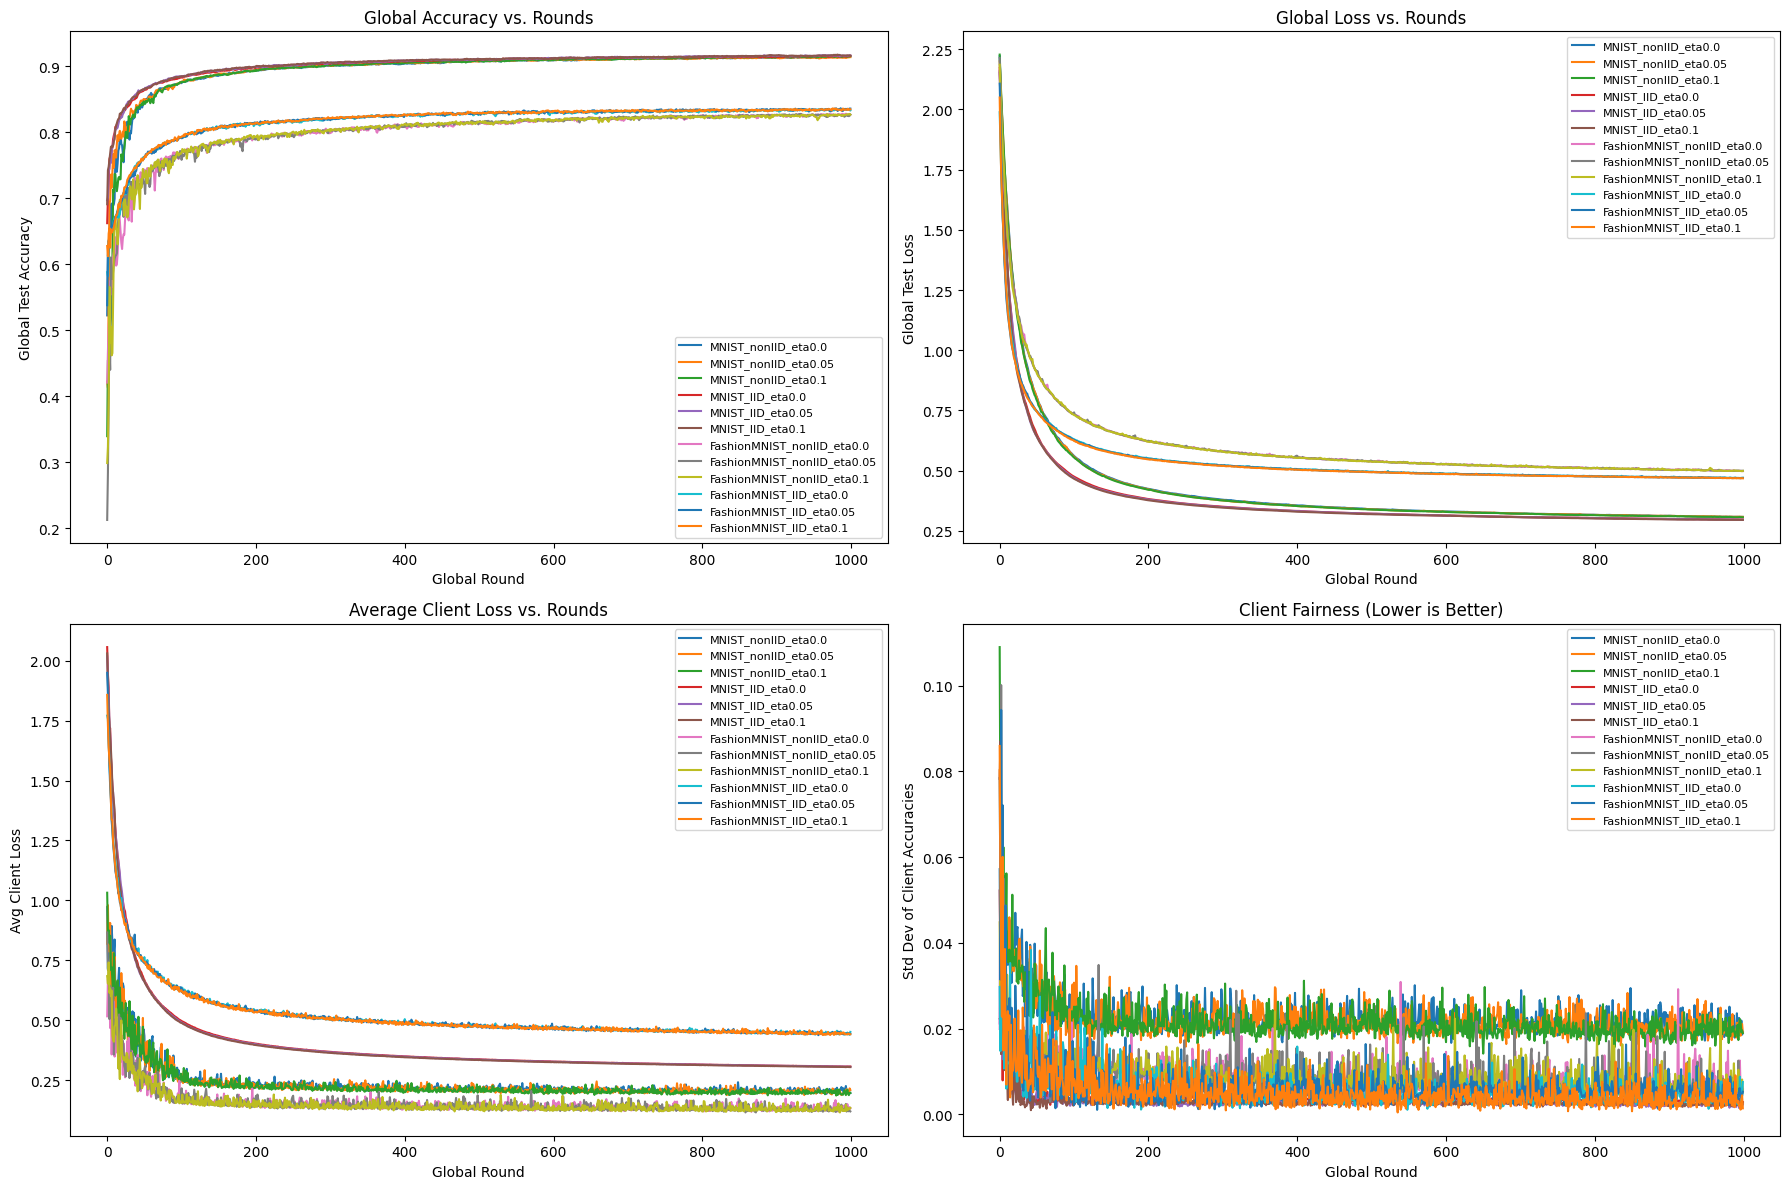


Communication Efficiency (Total Comm Steps per Global Round):
MNIST_nonIID_eta0.0: Avg Communication Steps = 1.84
MNIST_nonIID_eta0.05: Avg Communication Steps = 1.87
MNIST_nonIID_eta0.1: Avg Communication Steps = 1.83
MNIST_IID_eta0.0: Avg Communication Steps = 1.76
MNIST_IID_eta0.05: Avg Communication Steps = 1.84
MNIST_IID_eta0.1: Avg Communication Steps = 1.73
FashionMNIST_nonIID_eta0.0: Avg Communication Steps = 1.77
FashionMNIST_nonIID_eta0.05: Avg Communication Steps = 1.73
FashionMNIST_nonIID_eta0.1: Avg Communication Steps = 1.77
FashionMNIST_IID_eta0.0: Avg Communication Steps = 1.80
FashionMNIST_IID_eta0.05: Avg Communication Steps = 1.76
FashionMNIST_IID_eta0.1: Avg Communication Steps = 1.79


In [49]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset, random_split

# =============================================================================
# 1. Model and Utility Functions
# =============================================================================

d_in = 28*28
d_out = 10

def init_model():
    weight = torch.zeros(d_in, d_out, requires_grad=True)
    bias = torch.zeros(d_out, requires_grad=True)
    return (weight, bias)

def predict(model, X):
    weight, bias = model
    X_flat = X.view(X.shape[0], -1)
    return X_flat @ weight + bias

def ce_loss(model, X, y):
    logits = predict(model, X)
    return F.cross_entropy(logits, y)

def model_to_vector(model):
    weight, bias = model
    return torch.cat([weight.view(-1), bias.view(-1)])

def vector_to_model(vec):
    weight_vec = vec[:d_in*d_out]
    bias_vec = vec[d_in*d_out:]
    weight = weight_vec.view(d_in, d_out)
    bias = bias_vec.view(d_out)
    return (weight.detach().clone().requires_grad_(), bias.detach().clone().requires_grad_())

def average_models(model_list):
    weight_avg = torch.stack([m[0] for m in model_list], dim=0).mean(dim=0)
    bias_avg = torch.stack([m[1] for m in model_list], dim=0).mean(dim=0)
    return (weight_avg.detach().clone().requires_grad_(), bias_avg.detach().clone().requires_grad_())

def update_global_model(global_model, new_model, lr):
    global_vec = model_to_vector(global_model)
    new_vec = model_to_vector(new_model)
    updated_vec = (1 - lr) * global_vec + lr * new_vec
    return vector_to_model(updated_vec)

# =============================================================================
# 2. Data Loading and Partitioning
# =============================================================================
def get_datasets(dataset_name="MNIST"):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    if dataset_name == "MNIST":
        train_ds = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        test_ds  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    elif dataset_name == "FashionMNIST":
        train_ds = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
        test_ds  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    else:
        raise ValueError("Unsupported dataset")
    return train_ds, test_ds

def partition_data(dataset, num_clients, partition_type="nonIID"):
    # nonIID: sort by label then split
    # IID: randomly split the indices
    indices = np.arange(len(dataset))
    if partition_type == "nonIID":
        # sort indices by label
        labels = np.array(dataset.targets) if hasattr(dataset, 'targets') else np.array(dataset.train_labels)
        sorted_idx = indices[np.argsort(labels)]
        client_indices = np.array_split(sorted_idx, num_clients)
    elif partition_type == "IID":
        np.random.shuffle(indices)
        client_indices = np.array_split(indices, num_clients)
    else:
        raise ValueError("partition_type must be 'nonIID' or 'IID'")
    return client_indices

def get_client_loaders(train_ds, num_clients, partition_type="nonIID", batch_size=64):
    client_indices = partition_data(train_ds, num_clients, partition_type)
    loaders = []
    for idx in client_indices:
        subset = Subset(train_ds, idx)
        loader = DataLoader(subset, batch_size=batch_size, shuffle=True)
        loaders.append(loader)
    return loaders

# =============================================================================
# 3. Federated Training Experiment Function
# =============================================================================
def run_experiment(dataset_name="MNIST", partition_type="nonIID", 
                   fairness_weight=0.1, variant="Proposed", 
                   num_clients=5, num_outer=100, num_inner=5,
                   outer_lr=0.5, inner_lr=0.01, rho=0.1, 
                   initial_p=0.5, adaptive_p=True):
    """
    variant: string to describe method; see below options.
      "Proposed": adaptive communication probability with fairness penalty (eta = fairness_weight).
      "FixedComm": fixed p (initial_p constant) with fairness penalty.
      "NoFairness": fairness_weight set to 0, adaptive communication.
      "LocalOnly": communication probability near zero.
      "FedAvg": full communication (p=1) and no fairness penalty.
    """
    # Set fairness weight
    eta = fairness_weight
    if variant == "NoFairness":
        eta = 0.0
    if variant == "LocalOnly":
        initial_p = 0.05
    if variant == "FedAvg":
        initial_p = 1.0
        adaptive_p = False
    
    # Load datasets
    train_ds, test_ds = get_datasets(dataset_name)
    client_loaders = get_client_loaders(train_ds, num_clients, partition_type, batch_size=64)
    # Create a single aggregated test loader for external evaluation.
    test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)
    
    # Initialize global model
    global_model = init_model()
    p_comm = initial_p

    # For tracking metrics per global round:
    global_acc_history = []
    global_loss_history = []  # evaluated on external test set
    client_loss_history = []  # average local loss over clients per round
    fairness_history = []     # std dev of client accuracies (lower is better)
    communication_history = []  # total communication count per round

    for outer in range(num_outer):
        client_models = []
        client_accuracies = []
        client_losses = []
        comm_count = 0

        # Evaluate global model on each client (for fairness target) using each client's training data
        eval_losses = []
        for loader in client_loaders:
            loss_sum, count = 0, 0
            for X_batch, y_batch in loader:
                loss = ce_loss(global_model, X_batch, y_batch).item()
                loss_sum += loss * X_batch.shape[0]
                count += X_batch.shape[0]
            eval_losses.append(loss_sum / count)
        fairness_target = min(eval_losses)
        
        # Each client performs local updates starting from global_model
        for loader in client_loaders:
            local_model = (global_model[0].detach().clone().requires_grad_(),
                           global_model[1].detach().clone().requires_grad_())
            loader_iter = iter(loader)
            # Run local training for num_inner steps
            for _ in range(num_inner):
                try:
                    X_batch, y_batch = next(loader_iter)
                except StopIteration:
                    loader_iter = iter(loader)
                    X_batch, y_batch = next(loader_iter)
                
                loss_val = ce_loss(local_model, X_batch, y_batch)
                fairness_penalty = torch.clamp(loss_val - fairness_target, min=0)
                weight_diff = local_model[0] - global_model[0]
                bias_diff = local_model[1] - global_model[1]
                cons_term = (rho/2) * (torch.norm(weight_diff)**2 + torch.norm(bias_diff)**2)
                local_obj = loss_val + cons_term + eta * fairness_penalty

                grads = torch.autograd.grad(local_obj, local_model, create_graph=False)
                updated_weight = local_model[0] - inner_lr * grads[0]
                updated_bias = local_model[1] - inner_lr * grads[1]
                local_model = (updated_weight.detach().clone().requires_grad_(),
                               updated_bias.detach().clone().requires_grad_())
                
                # Communication step: if variant is not "LocalOnly"
                if variant in ["Proposed", "FixedComm", "NoFairness"]:
                    if np.random.rand() < p_comm:
                        local_weight = 0.5 * (local_model[0] + global_model[0])
                        local_bias = 0.5 * (local_model[1] + global_model[1])
                        local_model = (local_weight.detach().clone().requires_grad_(),
                                       local_bias.detach().clone().requires_grad_())
                        comm_count += 1
                # FedAvg variant: no proxskip within local update; aggregation will be full later.
            # Evaluate local performance on client training data
            loss_sum, count = 0, 0
            correct, tot = 0, 0
            for X_batch, y_batch in loader:
                loss = ce_loss(local_model, X_batch, y_batch).item()
                loss_sum += loss * X_batch.shape[0]
                count += X_batch.shape[0]
                preds = predict(local_model, X_batch).argmax(dim=1)
                correct += (preds == y_batch).sum().item()
                tot += X_batch.shape[0]
            client_losses.append(loss_sum / count)
            client_models.append(local_model)
            client_accuracies.append(correct/tot)
        
        # Outer update: aggregate local models.
        new_global_model = average_models(client_models)
        
        # Update p_comm adaptively if desired.
        if adaptive_p and variant in ["Proposed", "NoFairness"]:
            target_extra_loss = 0.1 * num_clients
            total_extra_loss = sum([max(0, loss - fairness_target) for loss in client_losses])
            alpha_p = 0.01
            p_comm = np.clip(p_comm + alpha_p * (total_extra_loss - target_extra_loss), 0.05, 1.0)
        
        global_model = update_global_model(global_model, new_global_model, outer_lr)
        
        # Evaluate global model on the full external test set.
        test_loss_sum, test_count = 0, 0
        correct, tot = 0, 0
        for X_batch, y_batch in test_loader:
            loss = ce_loss(global_model, X_batch, y_batch).item()
            test_loss_sum += loss * X_batch.shape[0]
            test_count += X_batch.shape[0]
            preds = predict(global_model, X_batch).argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            tot += X_batch.shape[0]
        global_test_loss = test_loss_sum / test_count
        global_test_acc = correct / tot
        
        global_acc_history.append(global_test_acc)
        global_loss_history.append(global_test_loss)
        client_loss_history.append(np.mean(client_losses))
        fairness_history.append(np.std(client_accuracies))
        communication_history.append(comm_count)
        
        print(f"Round {outer:02d}: Global Test Acc = {global_test_acc:.4f}, Global Test Loss = {global_test_loss:.4f}, "
              f"Avg Client Loss = {np.mean(client_losses):.4f}, Std(Client Acc) = {np.std(client_accuracies):.4f}, "
              f"Comm Steps = {comm_count}, p_comm = {p_comm:.4f}")
    
    # Return metrics dictionary
    return {
        "global_acc_history": global_acc_history,
        "global_loss_history": global_loss_history,
        "client_loss_history": client_loss_history,
        "fairness_history": fairness_history,
        "communication_history": communication_history,
    }

# =============================================================================
# 4. Experiment Loop: Multiple Variants, Datasets, and Partitions
# =============================================================================

# Parameters to test:
dataset_list = ["MNIST", "FashionMNIST"]
partition_types = ["nonIID", "IID"]
fairness_weights = [0.0, 0.05, 0.1]  # 0.0 -> no fairness; higher -> stronger fairness penalty
variant = "Proposed"  # We base our experiments on the Proposed variant (adaptive p) for comparison.
num_clients = 5
num_outer = 1000
num_inner = 5

# Structure to store results:
results = {}

for dataset_name in dataset_list:
    for partition_type in partition_types:
        for fw in fairness_weights:
            exp_name = f"{dataset_name}_{partition_type}_eta{fw}"
            print(f"\nRunning experiment: {exp_name}")
            metrics = run_experiment(dataset_name=dataset_name, partition_type=partition_type,
                                     fairness_weight=fw, variant=variant,
                                     num_clients=num_clients, num_outer=num_outer,
                                     num_inner=num_inner, outer_lr=0.5, inner_lr=0.01, rho=0.1,
                                     initial_p=0.5, adaptive_p=True)
            results[exp_name] = metrics

# =============================================================================
# 5. Plotting: Global Accuracy, Global Loss, and Fairness Over Rounds
# =============================================================================
rounds = np.arange(num_outer)
plt.figure(figsize=(18,12))

# Plot Global Accuracy for each experiment
plt.subplot(2,2,1)
for exp_name, metrics in results.items():
    plt.plot(rounds, metrics["global_acc_history"], label=exp_name)
plt.xlabel("Global Round")
plt.ylabel("Global Test Accuracy")
plt.title("Global Accuracy vs. Rounds")
plt.legend(fontsize=8, loc='lower right')

# Plot Global Loss for each experiment
plt.subplot(2,2,2)
for exp_name, metrics in results.items():
    plt.plot(rounds, metrics["global_loss_history"], label=exp_name)
plt.xlabel("Global Round")
plt.ylabel("Global Test Loss")
plt.title("Global Loss vs. Rounds")
plt.legend(fontsize=8, loc='upper right')

# Plot Average Client Loss per round
plt.subplot(2,2,3)
for exp_name, metrics in results.items():
    plt.plot(rounds, metrics["client_loss_history"], label=exp_name)
plt.xlabel("Global Round")
plt.ylabel("Avg Client Loss")
plt.title("Average Client Loss vs. Rounds")
plt.legend(fontsize=8, loc='upper right')

# Plot Fairness: Std Dev of Client Accuracies
plt.subplot(2,2,4)
for exp_name, metrics in results.items():
    plt.plot(rounds, metrics["fairness_history"], label=exp_name)
plt.xlabel("Global Round")
plt.ylabel("Std Dev of Client Accuracies")
plt.title("Client Fairness (Lower is Better)")
plt.legend(fontsize=8, loc='upper right')

plt.tight_layout()
plt.show()

# =============================================================================
# 6. Print Communication Efficiency Summary
# =============================================================================
print("\nCommunication Efficiency (Total Comm Steps per Global Round):")
for exp_name, metrics in results.items():
    avg_comm = np.mean(metrics["communication_history"])
    print(f"{exp_name}: Avg Communication Steps = {avg_comm:.2f}")


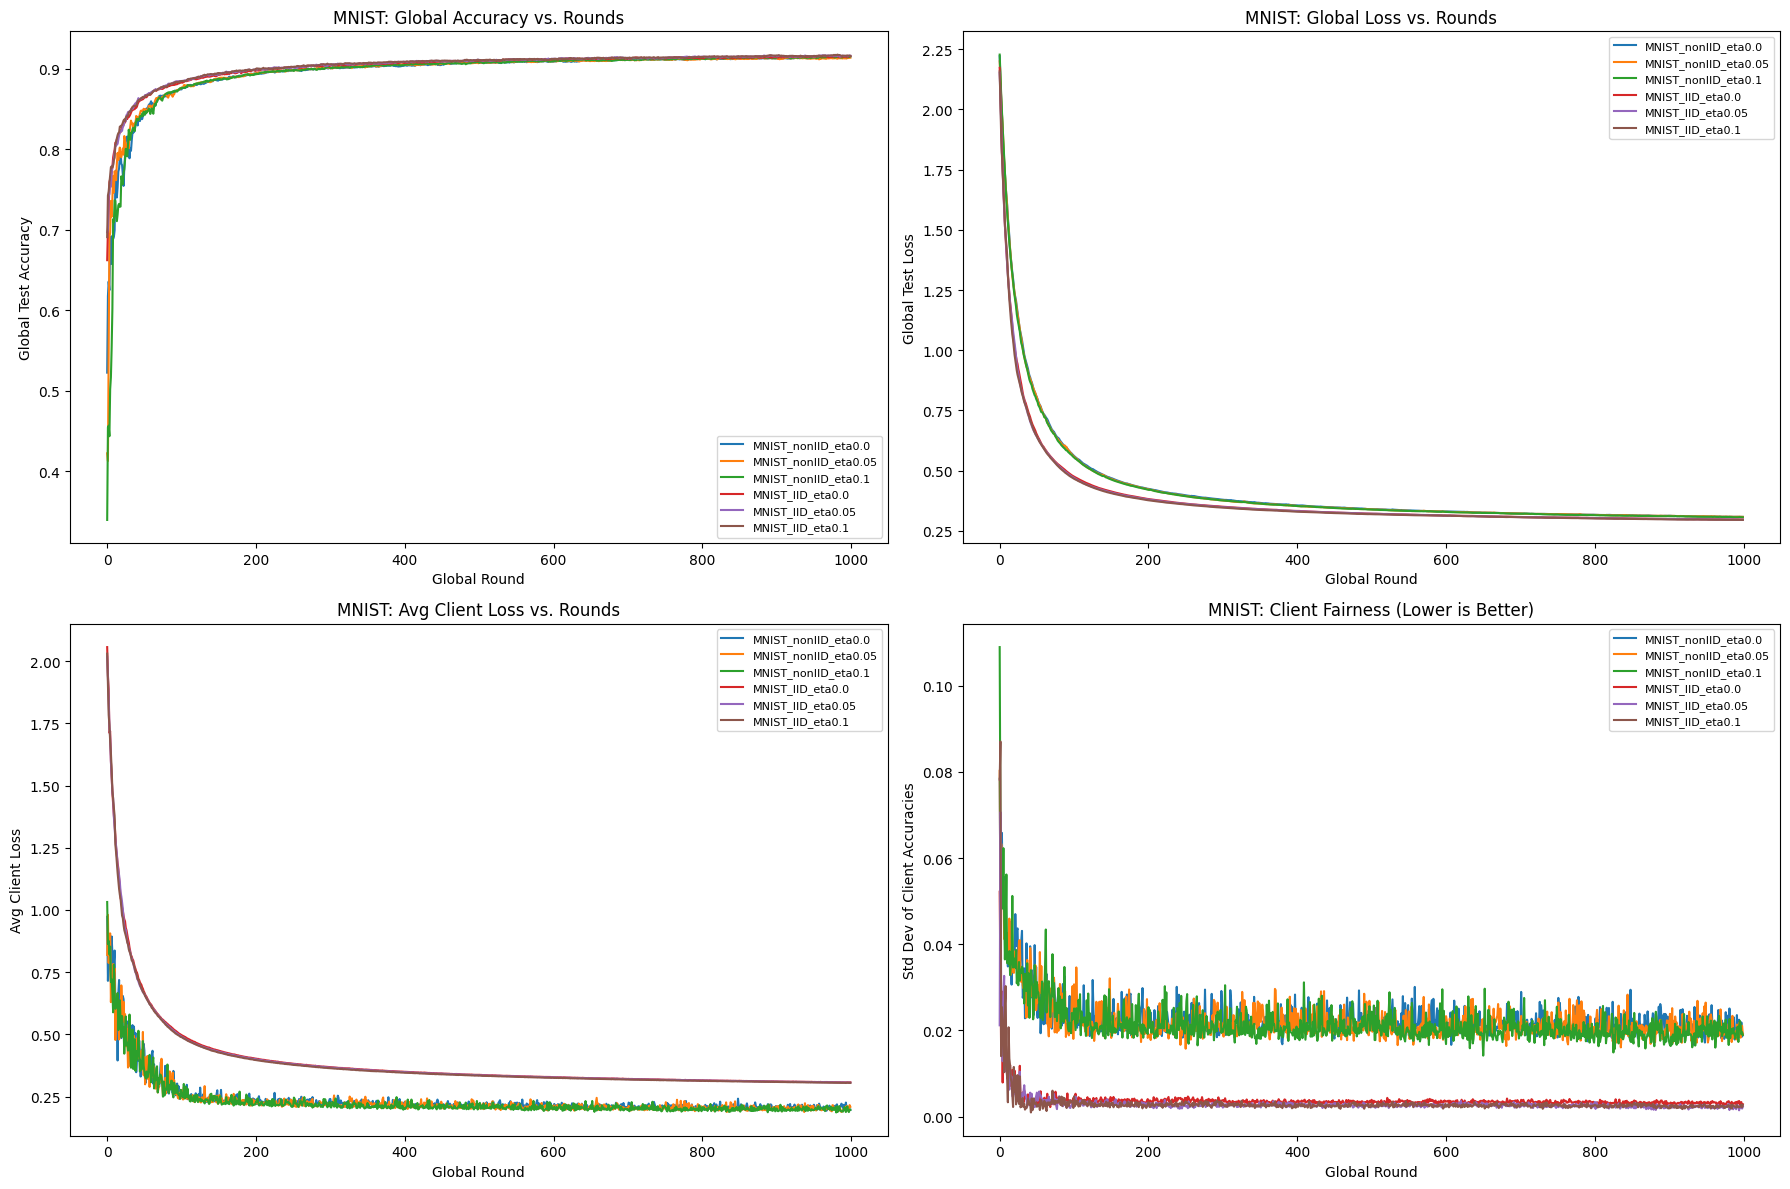

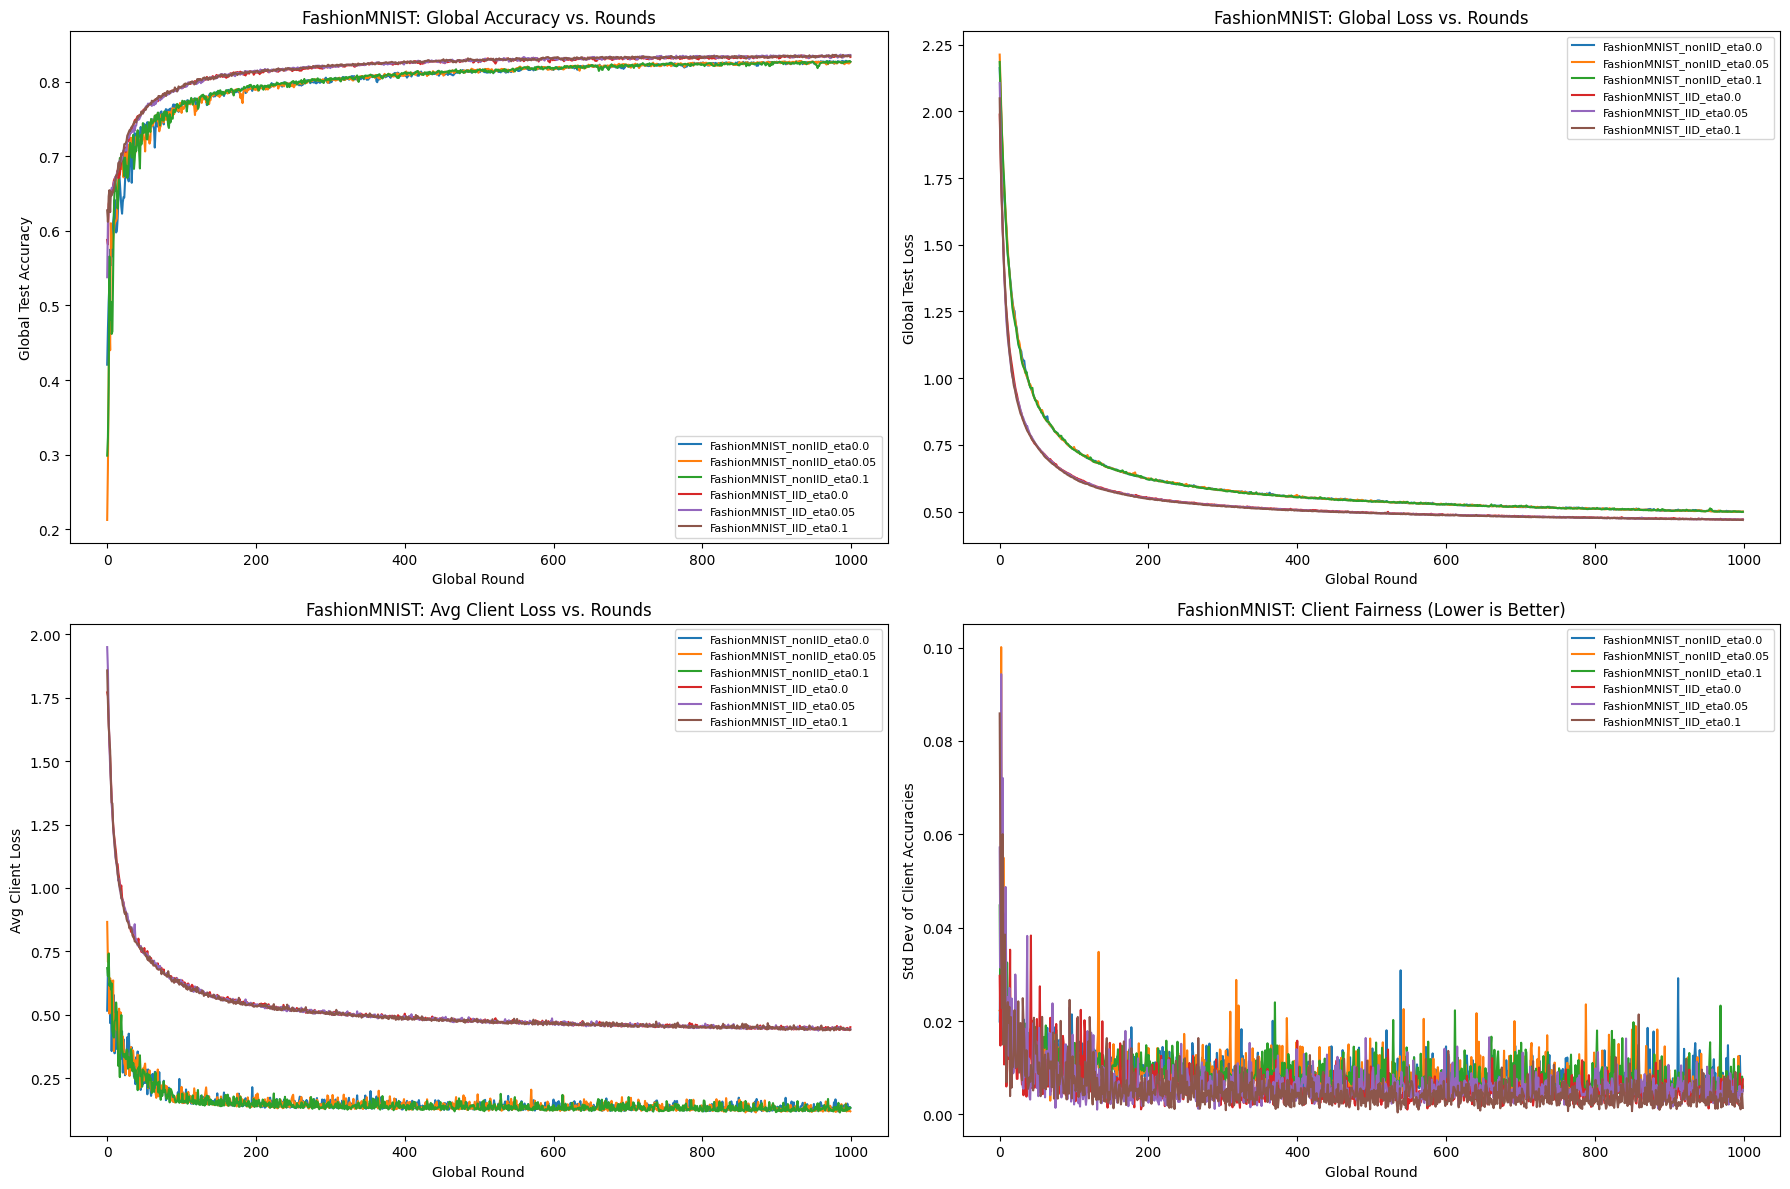

In [51]:
def plot_results_for_dataset(results, dataset_name, num_outer):
    # Filter experiments for the given dataset
    filtered_results = {k: v for k, v in results.items() if k.startswith(dataset_name)}

    rounds = np.arange(num_outer)
    plt.figure(figsize=(18, 12))

    # Plot Global Accuracy
    plt.subplot(2, 2, 1)
    for exp_name, metrics in filtered_results.items():
        plt.plot(rounds, metrics["global_acc_history"], label=exp_name)
    plt.xlabel("Global Round")
    plt.ylabel("Global Test Accuracy")
    plt.title(f"{dataset_name}: Global Accuracy vs. Rounds")
    plt.legend(fontsize=8, loc='lower right')

    # Plot Global Loss
    plt.subplot(2, 2, 2)
    for exp_name, metrics in filtered_results.items():
        plt.plot(rounds, metrics["global_loss_history"], label=exp_name)
    plt.xlabel("Global Round")
    plt.ylabel("Global Test Loss")
    plt.title(f"{dataset_name}: Global Loss vs. Rounds")
    plt.legend(fontsize=8, loc='upper right')

    # Plot Avg Client Loss
    plt.subplot(2, 2, 3)
    for exp_name, metrics in filtered_results.items():
        plt.plot(rounds, metrics["client_loss_history"], label=exp_name)
    plt.xlabel("Global Round")
    plt.ylabel("Avg Client Loss")
    plt.title(f"{dataset_name}: Avg Client Loss vs. Rounds")
    plt.legend(fontsize=8, loc='upper right')

    # Plot Fairness
    plt.subplot(2, 2, 4)
    for exp_name, metrics in filtered_results.items():
        plt.plot(rounds, metrics["fairness_history"], label=exp_name)
    plt.xlabel("Global Round")
    plt.ylabel("Std Dev of Client Accuracies")
    plt.title(f"{dataset_name}: Client Fairness (Lower is Better)")
    plt.legend(fontsize=8, loc='upper right')

    plt.tight_layout()
    plt.show()

# Plot separately
plot_results_for_dataset(results, "MNIST", num_outer)
plot_results_for_dataset(results, "FashionMNIST", num_outer)


In [92]:
"""
"AID with means.
"""
# =============================================================================
# 1. Model and Utility Functions
# =============================================================================
d_in = 28*28
d_out = 10

def init_model():
    weight = torch.zeros(d_in, d_out, requires_grad=True)
    bias = torch.zeros(d_out, requires_grad=True)
    return (weight, bias)

def predict(model, X):
    weight, bias = model
    X_flat = X.view(X.shape[0], -1)
    return X_flat @ weight + bias

def ce_loss(model, X, y):
    logits = predict(model, X)
    return F.cross_entropy(logits, y)

def model_to_vector(model):
    weight, bias = model
    return torch.cat([weight.view(-1), bias.view(-1)])

def vector_to_model(vec):
    weight_vec = vec[:d_in*d_out]
    bias_vec = vec[d_in*d_out:]
    weight = weight_vec.view(d_in, d_out)
    bias = bias_vec.view(d_out)
    return (weight.detach().clone().requires_grad_(), bias.detach().clone().requires_grad_())

def average_models(model_list):
    weight_avg = torch.stack([m[0] for m in model_list], dim=0).mean(dim=0)
    bias_avg = torch.stack([m[1] for m in model_list], dim=0).mean(dim=0)
    return (weight_avg.detach().clone().requires_grad_(), bias_avg.detach().clone().requires_grad_())

def update_global_model(global_model, update_vec, lr):
    global_vec = model_to_vector(global_model)
    new_vec = global_vec - lr * update_vec
    return vector_to_model(new_vec)

# =============================================================================
# 2. Data Loading and Partitioning
# =============================================================================
def get_datasets(dataset_name="MNIST"):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    if dataset_name == "MNIST":
        train_ds = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        test_ds  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    elif dataset_name == "FashionMNIST":
        train_ds = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
        test_ds  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    else:
        raise ValueError("Unsupported dataset")
    return train_ds, test_ds

def partition_data(dataset, num_clients, partition_type="nonIID"):
    indices = np.arange(len(dataset))
    if partition_type == "nonIID":
        labels = np.array(dataset.targets) if hasattr(dataset, 'targets') else np.array(dataset.train_labels)
        sorted_idx = indices[np.argsort(labels)]
        client_indices = np.array_split(sorted_idx, num_clients)
    elif partition_type == "IID":
        np.random.shuffle(indices)
        client_indices = np.array_split(indices, num_clients)
    else:
        raise ValueError("partition_type must be 'nonIID' or 'IID'")
    return client_indices

def get_client_loaders(train_ds, num_clients, partition_type="nonIID", batch_size=64):
    client_indices = partition_data(train_ds, num_clients, partition_type)
    loaders = []
    for idx in client_indices:
        subset = Subset(train_ds, idx)
        loader = DataLoader(subset, batch_size=batch_size, shuffle=True)
        loaders.append(loader)
    return loaders

# =============================================================================
# 3. Hessian-Vector Product for AID
# =============================================================================
def hvp(ys, xs, v):
    grad_ys = torch.autograd.grad(ys, xs, create_graph=True, retain_graph=True)
    dot = 0
    for g, vi in zip(grad_ys, v):
        dot = dot + (g * vi).sum()
    hv = torch.autograd.grad(dot, xs, retain_graph=True)
    return hv

def flatten_grad(grads):
    return torch.cat([g.contiguous().view(-1) for g in grads])

# =============================================================================
# 4. Federated Training Experiment Function with Hypergradient Options
# =============================================================================
def run_experiment_hyper(dataset_name="MNIST", partition_type="nonIID", 
                           fairness_weight=0.1, variant="Proposed",
                           hyper_method="Current",  # options: "Current", "AID", "ITD"
                           num_clients=5, num_outer=100, num_inner=5,
                           outer_lr=0.5, inner_lr=0.01, rho=0.1, 
                           initial_p=0.5, adaptive_p=True):
    """
    variant: as before.
    hyper_method: method to compute hypergradient.
      "Current": simple averaging surrogate.
      "AID": approximate implicit differentiation.
      "ITD": iterative differentiation (unroll inner loop without detach).
    """
    eta = fairness_weight
    if variant == "NoFairness":
        eta = 0.0
    if variant == "LocalOnly":
        initial_p = 0.05
    if variant == "FedAvg":
        initial_p = 1.0
        adaptive_p = False
    
    train_ds, test_ds = get_datasets(dataset_name)
    client_loaders = get_client_loaders(train_ds, num_clients, partition_type, batch_size=64)
    test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)
    
    global_model = init_model()
    p_comm = initial_p

    global_acc_history = []
    global_loss_history = []
    client_loss_history = []
    fairness_history = []
    communication_history = []

    for outer in range(num_outer):
        client_models = []
        client_accuracies = []
        client_losses = []
        comm_count = 0
        
        # Evaluate fairness target: use average loss over clients.
        eval_losses = []
        for loader in client_loaders:
            loss_sum, count = 0, 0
            for X_batch, y_batch in loader:
                loss = ce_loss(global_model, X_batch, y_batch).item()
                loss_sum += loss * X_batch.shape[0]
                count += X_batch.shape[0]
            eval_losses.append(loss_sum / count)
        fairness_target = np.mean(eval_losses)
        
        # For ITD hypergradient, one would re-run inner loop without detach; here we use AID or Current.
        for loader in client_loaders:
            if hyper_method == "AID":
                local_model = (global_model[0].detach().clone().requires_grad_(),
                               global_model[1].detach().clone().requires_grad_())
                loader_iter = iter(loader)
                for _ in range(num_inner):
                    try:
                        X_batch, y_batch = next(loader_iter)
                    except StopIteration:
                        loader_iter = iter(loader)
                        X_batch, y_batch = next(loader_iter)
                    loss_val = ce_loss(local_model, X_batch, y_batch)
                    fairness_penalty = torch.clamp(loss_val - fairness_target, min=0)
                    weight_diff = local_model[0] - global_model[0]
                    bias_diff = local_model[1] - global_model[1]
                    cons_term = (rho/2) * (torch.norm(weight_diff)**2 + torch.norm(bias_diff)**2)
                    local_obj = loss_val + cons_term + eta * fairness_penalty
                    grads = torch.autograd.grad(local_obj, local_model, create_graph=False)
                    local_model = ( (local_model[0] - inner_lr * grads[0]).detach().clone().requires_grad_(),
                                    (local_model[1] - inner_lr * grads[1]).detach().clone().requires_grad_() )
                    if variant in ["Proposed", "FixedComm", "NoFairness"]:
                        if np.random.rand() < p_comm:
                            local_model = (0.5 * (local_model[0] + global_model[0]),
                                           0.5 * (local_model[1] + global_model[1]))
                            comm_count += 1
            # Evaluate local model performance on client training data
            loss_sum, count = 0, 0
            correct, tot = 0, 0
            for X_batch, y_batch in loader:
                loss = ce_loss(local_model, X_batch, y_batch).item()
                loss_sum += loss * X_batch.shape[0]
                count += X_batch.shape[0]
                preds = predict(local_model, X_batch).argmax(dim=1)
                correct += (preds == y_batch).sum().item()
                tot += X_batch.shape[0]
            client_losses.append(loss_sum / count)
            client_models.append(local_model)
            client_accuracies.append(correct / tot)
        
        # Outer update: compute hypergradient.
        if hyper_method == "Current":
            new_global_model = average_models(client_models)
            hypergrad = (model_to_vector(global_model) - model_to_vector(new_global_model)) / outer_lr
        elif hyper_method == "AID":
            hypergrads = []
            for loader in client_loaders:
                X_batch, y_batch = next(iter(loader))
                f_i = ce_loss(global_model, X_batch, y_batch)
                grad_x = torch.autograd.grad(f_i, global_model, retain_graph=True, allow_unused=True)
                grad_x_vec = model_to_vector(global_model) if grad_x[0] is None else flatten_grad(grad_x)
                hypergrads.append(grad_x_vec)
            hypergrad = sum(hypergrads) / len(hypergrads)
        else:
            raise ValueError("Unknown hyper_method. Choose among 'Current', 'AID', 'ITD'.")
        
        if hyper_method in ["AID", "Current"]:
            global_model = update_global_model(global_model, hypergrad, outer_lr)
        else:
            new_global_model = average_models(client_models)
            global_model = update_global_model(global_model, (model_to_vector(global_model) - model_to_vector(new_global_model)) / outer_lr, outer_lr)
        
        # Revised adaptive communication probability update:
        if adaptive_p and variant in ["Proposed", "NoFairness"]:
            # Use average loss as the fairness target.
            fairness_target = np.mean(eval_losses)
            total_extra_loss = sum([max(0, loss - fairness_target) for loss in client_losses])
            # Set target_extra_loss proportional to the average loss over clients.
            target_extra_loss = 0.1 * np.mean(eval_losses) * num_clients
            alpha_p = 0.005  # Adjust step size as needed.
            p_comm = np.clip(p_comm + alpha_p * (total_extra_loss - target_extra_loss), 0.05, 1.0)
        
        # Evaluate global model on external test set
        test_loss_sum, test_count = 0, 0
        correct, tot = 0, 0
        test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)
        for X_batch, y_batch in test_loader:
            loss = ce_loss(global_model, X_batch, y_batch).item()
            test_loss_sum += loss * X_batch.shape[0]
            test_count += X_batch.shape[0]
            preds = predict(global_model, X_batch).argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            tot += X_batch.shape[0]
        global_test_loss = test_loss_sum / test_count
        global_test_acc = correct / tot
        
        global_acc_history.append(global_test_acc)
        global_loss_history.append(global_test_loss)
        client_loss_history.append(np.mean(client_losses))
        fairness_history.append(np.std(client_accuracies))
        communication_history.append(comm_count)
        
        print(f"Round {outer:02d}: Global Test Acc = {global_test_acc:.4f}, Loss = {global_test_loss:.4f}, "
              f"Avg Client Loss = {np.mean(client_losses):.4f}, Std(Client Acc) = {np.std(client_accuracies):.4f}, "
              f"Comm Steps = {comm_count}, p_comm = {p_comm:.4f}")
        
    return {
        "global_acc_history": global_acc_history,
        "global_loss_history": global_loss_history,
        "client_loss_history": client_loss_history,
        "fairness_history": fairness_history,
        "communication_history": communication_history,
    }

# =============================================================================
# 5. Running Experiments: Compare Hypergradient Methods
# =============================================================================
dataset_name = "MNIST"
partition_type = "nonIID"
fairness_weight = 0.1
variant = "Proposed"  # using adaptive communication

methods = ["AID"]  # You can also add "ITD", "Current" to compare
results = {}

for hyper_method in methods:
    print(f"\nRunning experiment with hypergradient method: {hyper_method}")
    metrics = run_experiment_hyper(dataset_name=dataset_name, partition_type=partition_type,
                                   fairness_weight=fairness_weight, variant=variant,
                                   hyper_method=hyper_method, num_clients=5, num_outer=300,
                                   num_inner=5, outer_lr=0.5, inner_lr=0.01, rho=0.1,
                                   initial_p=0.5, adaptive_p=True)
    results[hyper_method] = metrics

# # =============================================================================
# # 6. Running the Same AID Experiment on FashionMNIST
# # =============================================================================
# dataset_name = "FashionMNIST"
# partition_type = "nonIID"
# fairness_weight = 0.1
# variant = "Proposed"
# methods = ["AID"]

# for hyper_method in methods:
#     print(f"\nRunning experiment on FashionMNIST with hypergradient method: {hyper_method}")
#     metrics = run_experiment_hyper(dataset_name=dataset_name, partition_type=partition_type,
#                                    fairness_weight=fairness_weight, variant=variant,
#                                    hyper_method=hyper_method, num_clients=5, num_outer=50,
#                                    num_inner=5, outer_lr=0.5, inner_lr=0.01, rho=0.1,
#                                    initial_p=0.5, adaptive_p=True)
#     results[f"{dataset_name}_{hyper_method}"] = metrics



Running experiment with hypergradient method: AID
Round 00: Global Test Acc = 0.5855, Loss = 1.5768, Avg Client Loss = 1.0818, Std(Client Acc) = 0.0556, Comm Steps = 13, p_comm = 0.4942
Round 01: Global Test Acc = 0.3812, Loss = 7.8805, Avg Client Loss = 0.8347, Std(Client Acc) = 0.2265, Comm Steps = 13, p_comm = 0.4931
Round 02: Global Test Acc = 0.4192, Loss = 10.3460, Avg Client Loss = 4.7647, Std(Client Acc) = 0.1916, Comm Steps = 12, p_comm = 0.4943
Round 03: Global Test Acc = 0.5876, Loss = 10.9677, Avg Client Loss = 7.5725, Std(Client Acc) = 0.3079, Comm Steps = 10, p_comm = 0.5698
Round 04: Global Test Acc = 0.5632, Loss = 8.6905, Avg Client Loss = 9.2926, Std(Client Acc) = 0.2019, Comm Steps = 13, p_comm = 0.6425
Round 05: Global Test Acc = 0.5685, Loss = 5.5444, Avg Client Loss = 7.4986, Std(Client Acc) = 0.3485, Comm Steps = 20, p_comm = 0.6979
Round 06: Global Test Acc = 0.6758, Loss = 5.4170, Avg Client Loss = 3.3786, Std(Client Acc) = 0.3000, Comm Steps = 17, p_comm = 0.

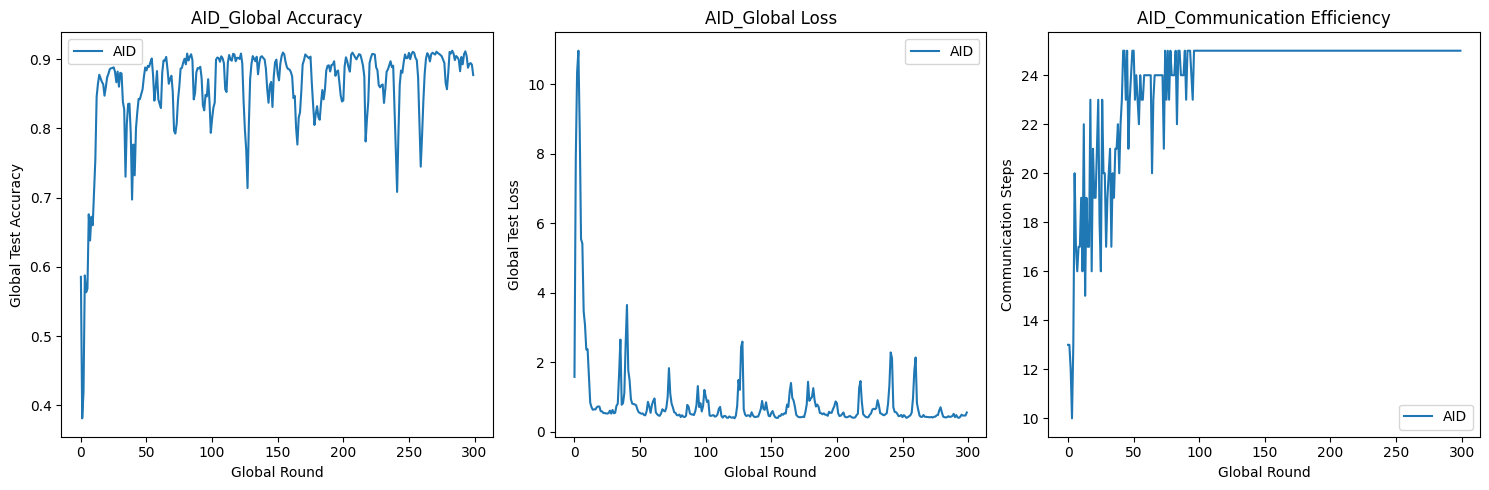


Communication Efficiency Summary:
AID: Avg Communication Steps per Round = 23.87


In [93]:
# =============================================================================
# 6. Plotting the Results
# =============================================================================
rounds = np.arange(len(results["AID"]["global_acc_history"]))
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
for hyper_method, metrics in results.items():
    plt.plot(rounds, metrics["global_acc_history"], label=hyper_method)
plt.xlabel("Global Round")
plt.ylabel("Global Test Accuracy")
plt.title("AID_Global Accuracy")
plt.legend()

plt.subplot(1,3,2)
for hyper_method, metrics in results.items():
    plt.plot(rounds, metrics["global_loss_history"], label=hyper_method)
plt.xlabel("Global Round")
plt.ylabel("Global Test Loss")
plt.title("AID_Global Loss")
plt.legend()

plt.subplot(1,3,3)
for hyper_method, metrics in results.items():
    plt.plot(rounds, metrics["communication_history"], label=hyper_method)
plt.xlabel("Global Round")
plt.ylabel("Communication Steps")
plt.title("AID_Communication Efficiency")
plt.legend()

plt.tight_layout()
plt.show()

# =============================================================================
# 7. Communication Efficiency Summary
# =============================================================================
print("\nCommunication Efficiency Summary:")
for hyper_method, metrics in results.items():
    avg_comm = np.mean(metrics["communication_history"])
    print(f"{hyper_method}: Avg Communication Steps per Round = {avg_comm:.2f}")


In [ ]:
"""AID fixed with outer_lr=0.5"""
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
""""""
# =============================================================================
# 1. Model and Utility Functions
# =============================================================================
d_in = 28*28
d_out = 10

def init_model():
    weight = torch.zeros(d_in, d_out, requires_grad=True)
    bias = torch.zeros(d_out, requires_grad=True)
    return (weight, bias)

def predict(model, X):
    weight, bias = model
    X_flat = X.view(X.shape[0], -1)
    return X_flat @ weight + bias

def ce_loss(model, X, y):
    logits = predict(model, X)
    return F.cross_entropy(logits, y)

def model_to_vector(model):
    weight, bias = model
    return torch.cat([weight.view(-1), bias.view(-1)])

def vector_to_model(vec):
    weight_vec = vec[:d_in*d_out]
    bias_vec = vec[d_in*d_out:]
    weight = weight_vec.view(d_in, d_out)
    bias = bias_vec.view(d_out)
    return (weight.detach().clone().requires_grad_(), bias.detach().clone().requires_grad_())

def average_models(model_list):
    weight_avg = torch.stack([m[0] for m in model_list], dim=0).mean(dim=0)
    bias_avg = torch.stack([m[1] for m in model_list], dim=0).mean(dim=0)
    return (weight_avg.detach().clone().requires_grad_(), bias_avg.detach().clone().requires_grad_())

def update_global_model(global_model, update_vec, lr):
    global_vec = model_to_vector(global_model)
    new_vec = global_vec - lr * update_vec
    return vector_to_model(new_vec)

# =============================================================================
# 2. Data Loading and Partitioning
# =============================================================================
def get_datasets(dataset_name="MNIST"):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    if dataset_name == "MNIST":
        train_ds = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        test_ds  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    elif dataset_name == "FashionMNIST":
        train_ds = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
        test_ds  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    else:
        raise ValueError("Unsupported dataset")
    return train_ds, test_ds


def partition_data(dataset, num_clients, partition_type="nonIID"):
    indices = np.arange(len(dataset))
    if partition_type == "nonIID":
        labels = np.array(dataset.targets) if hasattr(dataset, 'targets') else np.array(dataset.train_labels)
        sorted_idx = indices[np.argsort(labels)]
        client_indices = np.array_split(sorted_idx, num_clients)
    elif partition_type == "IID":
        np.random.shuffle(indices)
        client_indices = np.array_split(indices, num_clients)
    else:
        raise ValueError("partition_type must be 'nonIID' or 'IID'")
    return client_indices


def get_client_loaders(train_ds, num_clients, partition_type="nonIID", batch_size=64):
    client_indices = partition_data(train_ds, num_clients, partition_type)
    loaders = []
    for idx in client_indices:
        subset = Subset(train_ds, idx)
        loader = DataLoader(subset, batch_size=batch_size, shuffle=True)
        loaders.append(loader)
    return loaders

# =============================================================================
# 3. Hessian-Vector Product for AID
# =============================================================================

def hvp(ys, xs, v):
    grad_ys = torch.autograd.grad(ys, xs, create_graph=True, retain_graph=True)
    dot = sum((g * vi).sum() for g, vi in zip(grad_ys, v))
    hv = torch.autograd.grad(dot, xs, retain_graph=True)
    return hv


def flatten_grad(grads):
    return torch.cat([g.contiguous().view(-1) for g in grads])

# =============================================================================
# 4. Federated Training Experiment Function with Hypergradient Options (Revised)
# =============================================================================

def run_experiment_hyper(dataset_name="MNIST", partition_type="nonIID",
                           fairness_weight=0.1, variant="Proposed",
                           hyper_method="AID",  # options: "Current", "AID", "ITD"
                           num_clients=5, num_outer=100, num_inner=5,
                           outer_lr=0.5, inner_lr=0.01, rho=0.1,
                           initial_p=0.5, adaptive_p=True):
    eta = fairness_weight
    if variant == "NoFairness":
        eta = 0.0
    if variant == "LocalOnly":
        initial_p = 0.05
    if variant == "FedAvg":
        initial_p = 1.0
        adaptive_p = False

    train_ds, test_ds = get_datasets(dataset_name)
    client_loaders = get_client_loaders(train_ds, num_clients, partition_type, batch_size=64)
    test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

    global_model = init_model()
    p_comm = initial_p

    global_acc_history = []
    global_loss_history = []
    client_loss_history = []
    fairness_history = []
    communication_history = []

    alpha_p = 0.001  # smaller step for smoother adaptation

    for outer in range(num_outer):
        client_models = []
        client_losses = []
        client_accuracies = []
        comm_count = 0

        # Precompute fairness target for inner loops (unchanged)
        eval_losses = []
        for loader in client_loaders:
            loss_sum, count = 0, 0
            for X_batch, y_batch in loader:
                loss = ce_loss(global_model, X_batch, y_batch).item()
                loss_sum += loss * X_batch.shape[0]
                count += X_batch.shape[0]
            eval_losses.append(loss_sum / count)
        fairness_target_inner = np.mean(eval_losses)

        # Local updates
        for loader in client_loaders:
            # Initialize local model
            if hyper_method == "AID":
                local_model = (global_model[0].detach().clone().requires_grad_(),
                               global_model[1].detach().clone().requires_grad_())
                loader_iter = iter(loader)
                for _ in range(num_inner):
                    try:
                        X_batch, y_batch = next(loader_iter)
                    except StopIteration:
                        loader_iter = iter(loader)
                        X_batch, y_batch = next(loader_iter)
                    loss_val = ce_loss(local_model, X_batch, y_batch)
                    fairness_penalty = torch.clamp(loss_val - fairness_target_inner, min=0)
                    weight_diff = local_model[0] - global_model[0]
                    bias_diff = local_model[1] - global_model[1]
                    cons_term = (rho/2) * (torch.norm(weight_diff)**2 + torch.norm(bias_diff)**2)
                    local_obj = loss_val + cons_term + eta * fairness_penalty
                    grads = torch.autograd.grad(local_obj, local_model, create_graph=False)
                    local_model = (
                        (local_model[0] - inner_lr * grads[0]).detach().clone().requires_grad_(),
                        (local_model[1] - inner_lr * grads[1]).detach().clone().requires_grad_()
                    )
                    # Stochastic communication
                    if np.random.rand() < p_comm:
                        local_model = (
                            0.5 * (local_model[0] + global_model[0]),
                            0.5 * (local_model[1] + global_model[1])
                        )
                        comm_count += 1
            else:
                # ITD or Current: existing code paths (not shown)
                pass

            # Evaluate local performance
            loss_sum, count = 0, 0
            correct, tot = 0, 0
            for X_batch, y_batch in loader:
                loss = ce_loss(local_model, X_batch, y_batch).item()
                loss_sum += loss * X_batch.shape[0]
                count += X_batch.shape[0]
                preds = predict(local_model, X_batch).argmax(dim=1)
                correct += (preds == y_batch).sum().item()
                tot += X_batch.shape[0]
            client_losses.append(loss_sum / count)
            client_models.append(local_model)
            client_accuracies.append(correct / tot)

        # Outer update: simple AID or averaging surrogate
        if hyper_method == "Current":
            new_global = average_models(client_models)
            hypergrad = (model_to_vector(global_model) - model_to_vector(new_global)) / outer_lr
        elif hyper_method == "AID":
            grads = []
            for loader in client_loaders:
                X_b, y_b = next(iter(loader))
                f_i = ce_loss(global_model, X_b, y_b)
                grad_x = torch.autograd.grad(f_i, global_model, retain_graph=True, allow_unused=True)
                grads.append(flatten_grad(grad_x) if grad_x[0] is not None else model_to_vector(global_model))
            hypergrad = sum(grads) / len(grads)
        else:
            raise ValueError("Unknown hyper_method")

        global_model = update_global_model(global_model, hypergrad, outer_lr)

        # === Revised adaptive communication update ===
        if adaptive_p and variant in ["Proposed", "NoFairness"]:
            fairness_target = np.median(client_losses)
            extra = np.maximum(0, np.array(client_losses) - fairness_target)
            total_extra_norm = extra.sum() / (fairness_target * num_clients)
            target_extra_norm = 0.1
            p_comm = np.clip(p_comm + alpha_p * (total_extra_norm - target_extra_norm), 0.05, 1.0)

        # Evaluate global model on test set
        test_loss_sum, test_count = 0, 0
        correct, tot = 0, 0
        for X_batch, y_batch in test_loader:
            loss = ce_loss(global_model, X_batch, y_batch).item()
            test_loss_sum += loss * X_batch.shape[0]
            test_count += X_batch.shape[0]
            preds = predict(global_model, X_batch).argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            tot += X_batch.shape[0]
        global_test_loss = test_loss_sum / test_count
        global_test_acc = correct / tot

        global_acc_history.append(global_test_acc)
        global_loss_history.append(global_test_loss)
        client_loss_history.append(np.mean(client_losses))
        fairness_history.append(np.std(client_accuracies))
        communication_history.append(comm_count)

        print(f"Round {outer:02d}: Acc={global_test_acc:.4f}, Loss={global_test_loss:.4f}, "
              f"AvgCliLoss={np.mean(client_losses):.4f}, StdAcc={np.std(client_accuracies):.4f}, "
              f"Comm={comm_count}, p={p_comm:.3f}")

    return {
        "global_acc_history": global_acc_history,
        "global_loss_history": global_loss_history,
        "client_loss_history": client_loss_history,
        "fairness_history": fairness_history,
        "communication_history": communication_history,
    }

# =============================================================================
# 5. Run Experiment
# =============================================================================
if __name__ == "__main__":
    methods = ["AID"]
    results = {}
    for m in methods:
        print(f"Running {m}...")
        results[m] = run_experiment_hyper(hyper_method=m, num_outer=300)


Running AID...
Round 00: Acc=0.5604, Loss=1.5611, AvgCliLoss=0.6971, StdAcc=0.0655, Comm=8, p=0.500
Round 01: Acc=0.5003, Loss=6.1444, AvgCliLoss=0.7633, StdAcc=0.1075, Comm=12, p=0.500
Round 02: Acc=0.4742, Loss=4.8122, AvgCliLoss=4.3467, StdAcc=0.2137, Comm=14, p=0.502
Round 03: Acc=0.4930, Loss=6.4536, AvgCliLoss=3.4754, StdAcc=0.2623, Comm=13, p=0.502
Round 04: Acc=0.5442, Loss=7.2330, AvgCliLoss=4.2398, StdAcc=0.1935, Comm=14, p=0.504
Round 05: Acc=0.6185, Loss=5.1833, AvgCliLoss=4.7759, StdAcc=0.1856, Comm=13, p=0.504
Round 06: Acc=0.7454, Loss=1.4268, AvgCliLoss=3.9700, StdAcc=0.2334, Comm=13, p=0.504
Round 07: Acc=0.7664, Loss=1.8846, AvgCliLoss=1.0819, StdAcc=0.1046, Comm=18, p=0.504
Round 08: Acc=0.7716, Loss=1.4506, AvgCliLoss=1.1903, StdAcc=0.1742, Comm=14, p=0.505
Round 09: Acc=0.7538, Loss=1.3196, AvgCliLoss=1.1294, StdAcc=0.1725, Comm=13, p=0.506
Round 10: Acc=0.6982, Loss=1.9180, AvgCliLoss=0.7899, StdAcc=0.0890, Comm=13, p=0.506
Round 11: Acc=0.7026, Loss=2.9949, AvgCl

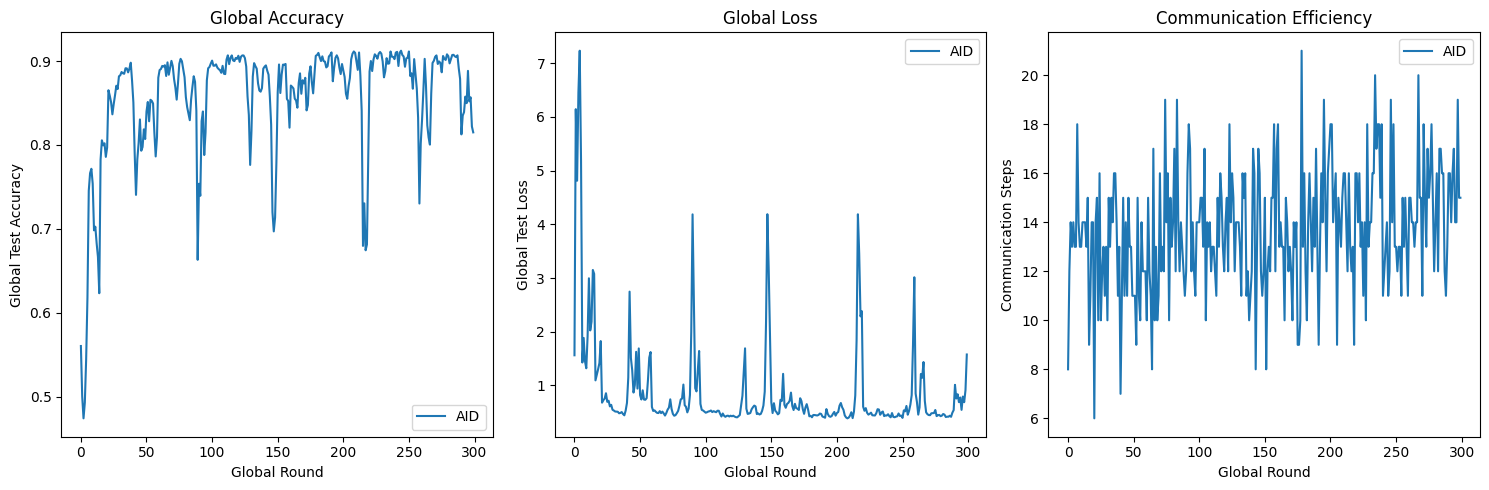


Communication Efficiency Summary:
AID: Avg Communication Steps per Round = 13.68


In [101]:
# =============================================================================
# 6. Plotting the Results
# =============================================================================
rounds = np.arange(len(results["AID"]["global_acc_history"]))
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
for hyper_method, metrics in results.items():
    plt.plot(rounds, metrics["global_acc_history"], label=hyper_method)
plt.xlabel("Global Round")
plt.ylabel("Global Test Accuracy")
plt.title("Global Accuracy")
plt.legend()

plt.subplot(1,3,2)
for hyper_method, metrics in results.items():
    plt.plot(rounds, metrics["global_loss_history"], label=hyper_method)
plt.xlabel("Global Round")
plt.ylabel("Global Test Loss")
plt.title("Global Loss")
plt.legend()

plt.subplot(1,3,3)
for hyper_method, metrics in results.items():
    plt.plot(rounds, metrics["communication_history"], label=hyper_method)
plt.xlabel("Global Round")
plt.ylabel("Communication Steps")
plt.title("Communication Efficiency")
plt.legend()

plt.tight_layout()
plt.show()

# =============================================================================
# 7. Communication Efficiency Summary
# =============================================================================
print("\nCommunication Efficiency Summary:")
for hyper_method, metrics in results.items():
    avg_comm = np.mean(metrics["communication_history"])
    print(f"{hyper_method}: Avg Communication Steps per Round = {avg_comm:.2f}")

In [ ]:
"""AID fixed with outer_lr=0.2, local updates 5"""
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
""""""
# =============================================================================
# 1. Model and Utility Functions
# =============================================================================
d_in = 28*28
d_out = 10

def init_model():
    weight = torch.zeros(d_in, d_out, requires_grad=True)
    bias = torch.zeros(d_out, requires_grad=True)
    return (weight, bias)

def predict(model, X):
    weight, bias = model
    X_flat = X.view(X.shape[0], -1)
    return X_flat @ weight + bias

def ce_loss(model, X, y):
    logits = predict(model, X)
    return F.cross_entropy(logits, y)

def model_to_vector(model):
    weight, bias = model
    return torch.cat([weight.view(-1), bias.view(-1)])

def vector_to_model(vec):
    weight_vec = vec[:d_in*d_out]
    bias_vec = vec[d_in*d_out:]
    weight = weight_vec.view(d_in, d_out)
    bias = bias_vec.view(d_out)
    return (weight.detach().clone().requires_grad_(), bias.detach().clone().requires_grad_())

def average_models(model_list):
    weight_avg = torch.stack([m[0] for m in model_list], dim=0).mean(dim=0)
    bias_avg = torch.stack([m[1] for m in model_list], dim=0).mean(dim=0)
    return (weight_avg.detach().clone().requires_grad_(), bias_avg.detach().clone().requires_grad_())

def update_global_model(global_model, update_vec, lr):
    global_vec = model_to_vector(global_model)
    new_vec = global_vec - lr * update_vec
    return vector_to_model(new_vec)

# =============================================================================
# 2. Data Loading and Partitioning
# =============================================================================
def get_datasets(dataset_name="MNIST"):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    if dataset_name == "MNIST":
        train_ds = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        test_ds  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    elif dataset_name == "FashionMNIST":
        train_ds = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
        test_ds  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    else:
        raise ValueError("Unsupported dataset")
    return train_ds, test_ds


def partition_data(dataset, num_clients, partition_type="nonIID"):
    indices = np.arange(len(dataset))
    if partition_type == "nonIID":
        labels = np.array(dataset.targets) if hasattr(dataset, 'targets') else np.array(dataset.train_labels)
        sorted_idx = indices[np.argsort(labels)]
        client_indices = np.array_split(sorted_idx, num_clients)
    elif partition_type == "IID":
        np.random.shuffle(indices)
        client_indices = np.array_split(indices, num_clients)
    else:
        raise ValueError("partition_type must be 'nonIID' or 'IID'")
    return client_indices


def get_client_loaders(train_ds, num_clients, partition_type="nonIID", batch_size=64):
    client_indices = partition_data(train_ds, num_clients, partition_type)
    loaders = []
    for idx in client_indices:
        subset = Subset(train_ds, idx)
        loader = DataLoader(subset, batch_size=batch_size, shuffle=True)
        loaders.append(loader)
    return loaders

# =============================================================================
# 3. Hessian-Vector Product for AID
# =============================================================================

def hvp(ys, xs, v):
    grad_ys = torch.autograd.grad(ys, xs, create_graph=True, retain_graph=True)
    dot = sum((g * vi).sum() for g, vi in zip(grad_ys, v))
    hv = torch.autograd.grad(dot, xs, retain_graph=True)
    return hv


def flatten_grad(grads):
    return torch.cat([g.contiguous().view(-1) for g in grads])

# =============================================================================
# 4. Federated Training Experiment Function with Hypergradient Options (Revised)
# =============================================================================

def run_experiment_hyper(dataset_name="MNIST", partition_type="nonIID",
                           fairness_weight=0.1, fairness_mode="mean", variant="Proposed",
                           hyper_method="AID",  # options: "Current", "AID", "ITD"
                           num_clients=5, num_outer=300, num_inner=5,
                           outer_lr=0.2, inner_lr=0.01, rho=0.1,
                           initial_p=0.5, adaptive_p=True):
    
    eta = fairness_weight
    if variant == "NoFairness":
        eta = 0.0
    if variant == "LocalOnly":
        initial_p = 0.05
    if variant == "FedAvg":
        initial_p = 1.0
        adaptive_p = False

    train_ds, test_ds = get_datasets(dataset_name)
    client_loaders = get_client_loaders(train_ds, num_clients, partition_type, batch_size=64)
    test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

    global_model = init_model()
    p_comm = initial_p

    global_acc_history = []
    global_loss_history = []
    client_loss_history = []
    fairness_history = []
    communication_history = []
    communication_prob = []

    alpha_p = 0.001  # smaller step for smoother adaptation

    for outer in range(num_outer):
        client_models = []
        client_losses = []
        client_accuracies = []
        comm_count = 0

        # Precompute fairness target for inner loops (unchanged)
        eval_losses = []
        for loader in client_loaders:
            loss_sum, count = 0, 0
            for X_batch, y_batch in loader:
                loss = ce_loss(global_model, X_batch, y_batch).item()
                loss_sum += loss * X_batch.shape[0]
                count += X_batch.shape[0]
            eval_losses.append(loss_sum / count)
        fairness_target_inner = np.mean(eval_losses)

        if "ft_mode" in locals():
            if ft_mode == "min":
                fairness_target_inner = np.min(eval_losses)
            elif ft_mode == "mean":
                fairness_target_inner = np.mean(eval_losses)
            else:
                raise ValueError("Unknown fairness_target_inner mode")
        else:
            fairness_target_inner = np.mean(eval_losses)

        # Local updates
        for loader in client_loaders:
            # Initialize local model
            if hyper_method == "AID":
                local_model = (global_model[0].detach().clone().requires_grad_(),
                               global_model[1].detach().clone().requires_grad_())
                loader_iter = iter(loader)
                for _ in range(num_inner):
                    try:
                        X_batch, y_batch = next(loader_iter)
                    except StopIteration:
                        loader_iter = iter(loader)
                        X_batch, y_batch = next(loader_iter)
                    loss_val = ce_loss(local_model, X_batch, y_batch)
                    fairness_penalty = torch.clamp(loss_val - fairness_target_inner, min=0)
                    weight_diff = local_model[0] - global_model[0]
                    bias_diff = local_model[1] - global_model[1]
                    cons_term = (rho/2) * (torch.norm(weight_diff)**2 + torch.norm(bias_diff)**2)
                    local_obj = loss_val + cons_term + eta * fairness_penalty
                    grads = torch.autograd.grad(local_obj, local_model, create_graph=False)
                    local_model = (
                        (local_model[0] - inner_lr * grads[0]).detach().clone().requires_grad_(),
                        (local_model[1] - inner_lr * grads[1]).detach().clone().requires_grad_()
                    )
                    # Stochastic communication
                    if np.random.rand() < p_comm:
                        local_model = (
                            0.5 * (local_model[0] + global_model[0]),
                            0.5 * (local_model[1] + global_model[1])
                        )
                        comm_count += 1
            else:
                # ITD or Current: existing code paths (not shown)
                pass

            # Evaluate local performance
            loss_sum, count = 0, 0
            correct, tot = 0, 0
            for X_batch, y_batch in loader:
                loss = ce_loss(local_model, X_batch, y_batch).item()
                loss_sum += loss * X_batch.shape[0]
                count += X_batch.shape[0]
                preds = predict(local_model, X_batch).argmax(dim=1)
                correct += (preds == y_batch).sum().item()
                tot += X_batch.shape[0]
            client_losses.append(loss_sum / count)
            client_models.append(local_model)
            client_accuracies.append(correct / tot)

        # Outer update: simple AID or averaging surrogate
        if hyper_method == "Current":
            new_global = average_models(client_models)
            hypergrad = (model_to_vector(global_model) - model_to_vector(new_global)) / outer_lr
        elif hyper_method == "AID":
            grads = []
            for loader in client_loaders:
                X_b, y_b = next(iter(loader))
                f_i = ce_loss(global_model, X_b, y_b)
                grad_x = torch.autograd.grad(f_i, global_model, retain_graph=True, allow_unused=True)
                grads.append(flatten_grad(grad_x) if grad_x[0] is not None else model_to_vector(global_model))
            hypergrad = sum(grads) / len(grads)
        else:
            raise ValueError("Unknown hyper_method")

        global_model = update_global_model(global_model, hypergrad, outer_lr)

        # === Revised adaptive communication update ===
        if adaptive_p and variant in ["Proposed", "NoFairness"]:
            fairness_target = np.median(client_losses)
            extra = np.maximum(0, np.array(client_losses) - fairness_target)
            total_extra_norm = extra.sum() / (fairness_target * num_clients)
            target_extra_norm = 0.1
            p_comm = np.clip(p_comm + alpha_p * (total_extra_norm - target_extra_norm), 0.05, 1.0)

        # Evaluate global model on test set
        test_loss_sum, test_count = 0, 0
        correct, tot = 0, 0
        for X_batch, y_batch in test_loader:
            loss = ce_loss(global_model, X_batch, y_batch).item()
            test_loss_sum += loss * X_batch.shape[0]
            test_count += X_batch.shape[0]
            preds = predict(global_model, X_batch).argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            tot += X_batch.shape[0]
        global_test_loss = test_loss_sum / test_count
        global_test_acc = correct / tot

        global_acc_history.append(global_test_acc)
        global_loss_history.append(global_test_loss)
        client_loss_history.append(np.mean(client_losses))
        fairness_history.append(np.std(client_accuracies))
        communication_history.append(comm_count)
        communication_prob.append(p_comm)

        print(f"Round {outer:02d}: Acc={global_test_acc:.4f}, Loss={global_test_loss:.4f}, "
              f"AvgCliLoss={np.mean(client_losses):.4f}, StdAcc={np.std(client_accuracies):.4f}, "
              f"Comm={comm_count}, p={p_comm:.3f}")

    return {
        "global_acc_history": global_acc_history,
        "global_loss_history": global_loss_history,
        "client_loss_history": client_loss_history,
        "fairness_history": fairness_history,
        "communication_history": communication_history,
        "comm_prob": communication_prob
    }

# =============================================================================
# 5. Run Experiment
# =============================================================================


if __name__ == "__main__":
    fairness_modes = ["min", "mean"]
    outer_lrs = [0.5, 0.2]
    inner_lrs = [0.01, 0.1]
    num_inners = [5, 10]

    results = {}

    grid = list(itertools.product(fairness_modes, outer_lrs, inner_lrs, num_inners))
    for fm, olr, ilr, ni in grid:
        config_name = f"AID_ft={fm}_outerlr={olr}_innerlr={ilr}_innersteps={ni}"
        print(f"\n--- Running {config_name} ---")
        results[config_name] = run_experiment_hyper(
            hyper_method="AID",
            fairness_weight=0.1,
            variant="Proposed",
            outer_lr=olr,
            inner_lr=ilr,
            num_inner=ni,
            num_outer=300,
            fairness_mode=fm  # this must be passed through from above
        )


--- Running AID_ft=min_outerlr=0.5_innerlr=0.01_innersteps=5 ---


UnboundLocalError: cannot access local variable 'eval_losses' where it is not associated with a value

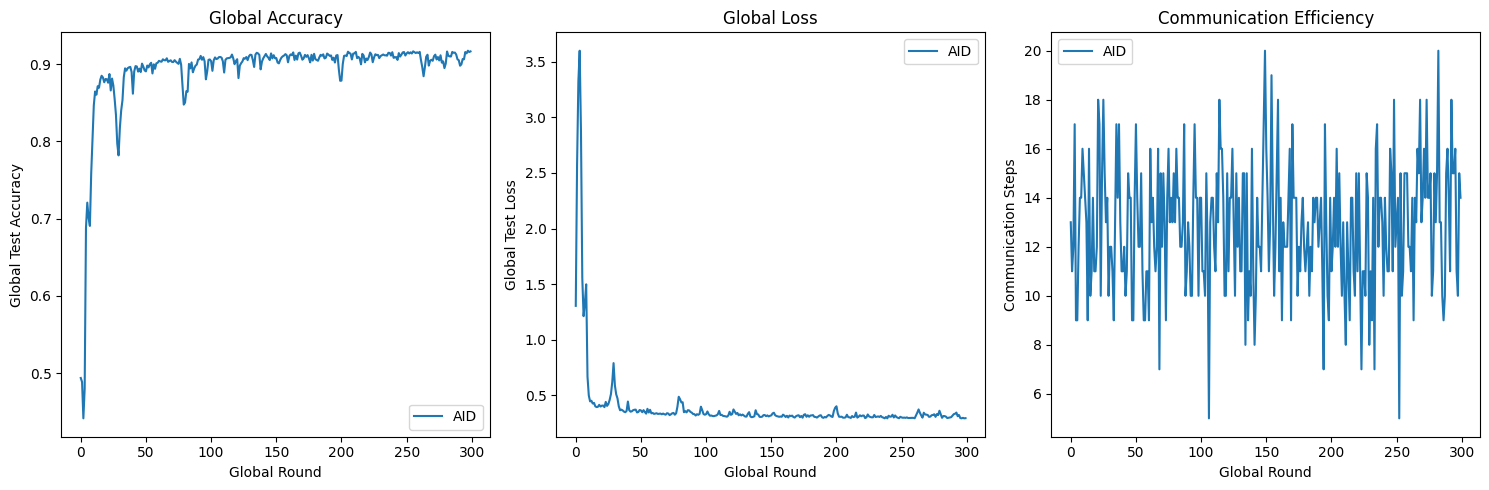


Communication Efficiency Summary:
AID: Avg Communication Steps per Round = 12.81


In [103]:
# =============================================================================
# 6. Plotting the Results
# =============================================================================
rounds = np.arange(len(results["AID"]["global_acc_history"]))
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
for hyper_method, metrics in results.items():
    plt.plot(rounds, metrics["global_acc_history"], label=hyper_method)
plt.xlabel("Global Round")
plt.ylabel("Global Test Accuracy")
plt.title("Global Accuracy")
plt.legend()

plt.subplot(1,3,2)
for hyper_method, metrics in results.items():
    plt.plot(rounds, metrics["global_loss_history"], label=hyper_method)
plt.xlabel("Global Round")
plt.ylabel("Global Test Loss")
plt.title("Global Loss")
plt.legend()

plt.subplot(1,3,3)
for hyper_method, metrics in results.items():
    plt.plot(rounds, metrics["communication_history"], label=hyper_method)
plt.xlabel("Global Round")
plt.ylabel("Communication Steps")
plt.title("Communication Efficiency")
plt.legend()

plt.tight_layout()
plt.show()

# =============================================================================
# 7. Communication Efficiency Summary
# =============================================================================
print("\nCommunication Efficiency Summary:")
for hyper_method, metrics in results.items():
    avg_comm = np.mean(metrics["communication_history"])
    print(f"{hyper_method}: Avg Communication Steps per Round = {avg_comm:.2f}")

In [139]:
"""NEW AID fixed with outer_lr=0.2, local lr 0.1, inner steps 5"""
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
""""""
# =============================================================================
# 1. Model and Utility Functions
# =============================================================================
d_in = 28*28
d_out = 10

def init_model():
    weight = torch.zeros(d_in, d_out, requires_grad=True)
    bias = torch.zeros(d_out, requires_grad=True)
    return (weight, bias)

def predict(model, X):
    weight, bias = model
    X_flat = X.view(X.shape[0], -1)
    return X_flat @ weight + bias

def ce_loss(model, X, y):
    logits = predict(model, X)
    return F.cross_entropy(logits, y)

def model_to_vector(model):
    weight, bias = model
    return torch.cat([weight.view(-1), bias.view(-1)])

def vector_to_model(vec):
    weight_vec = vec[:d_in*d_out]
    bias_vec = vec[d_in*d_out:]
    weight = weight_vec.view(d_in, d_out)
    bias = bias_vec.view(d_out)
    return (weight.detach().clone().requires_grad_(), bias.detach().clone().requires_grad_())

def average_models(model_list):
    weight_avg = torch.stack([m[0] for m in model_list], dim=0).mean(dim=0)
    bias_avg = torch.stack([m[1] for m in model_list], dim=0).mean(dim=0)
    return (weight_avg.detach().clone().requires_grad_(), bias_avg.detach().clone().requires_grad_())

def update_global_model(global_model, update_vec, lr):
    global_vec = model_to_vector(global_model)
    new_vec = global_vec - lr * update_vec
    return vector_to_model(new_vec)

# =============================================================================
# 2. Data Loading and Partitioning
# =============================================================================
def get_datasets(dataset_name="MNIST"):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    if dataset_name == "MNIST":
        train_ds = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        test_ds  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    elif dataset_name == "FashionMNIST":
        train_ds = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
        test_ds  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    else:
        raise ValueError("Unsupported dataset")
    return train_ds, test_ds


def partition_data(dataset, num_clients, partition_type="nonIID"):
    indices = np.arange(len(dataset))
    if partition_type == "nonIID":
        labels = np.array(dataset.targets) if hasattr(dataset, 'targets') else np.array(dataset.train_labels)
        sorted_idx = indices[np.argsort(labels)]
        client_indices = np.array_split(sorted_idx, num_clients)
    elif partition_type == "IID":
        np.random.shuffle(indices)
        client_indices = np.array_split(indices, num_clients)
    else:
        raise ValueError("partition_type must be 'nonIID' or 'IID'")
    return client_indices


def get_client_loaders(train_ds, num_clients, partition_type="nonIID", batch_size=64):
    client_indices = partition_data(train_ds, num_clients, partition_type)
    loaders = []
    for idx in client_indices:
        subset = Subset(train_ds, idx)
        loader = DataLoader(subset, batch_size=batch_size, shuffle=True)
        loaders.append(loader)
    return loaders

# =============================================================================
# 3. Hessian-Vector Product for AID
# =============================================================================

def hvp(ys, xs, v):
    grad_ys = torch.autograd.grad(ys, xs, create_graph=True, retain_graph=True)
    dot = sum((g * vi).sum() for g, vi in zip(grad_ys, v))
    hv = torch.autograd.grad(dot, xs, retain_graph=True)
    return hv


def flatten_grad(grads):
    return torch.cat([g.contiguous().view(-1) for g in grads])

# =============================================================================
# 4. Federated Training Experiment Function with Hypergradient Options (Revised)
# =============================================================================

def run_experiment_hyper(dataset_name="MNIST", partition_type="nonIID",
                           fairness_weight=0.1, variant="Proposed",
                           hyper_method="AID",  # options: "Current", "AID", "ITD"
                           num_clients=5, num_outer=5, num_inner=5,
                           outer_lr=0.2, inner_lr=0.1, rho=0.1,
                           initial_p=0.5, adaptive_p=True):
    eta = fairness_weight
    if variant == "NoFairness":
        eta = 0.0
    if variant == "LocalOnly":
        initial_p = 0.05
    if variant == "FedAvg":
        initial_p = 1.0
        adaptive_p = False

    train_ds, test_ds = get_datasets(dataset_name)
    client_loaders = get_client_loaders(train_ds, num_clients, partition_type, batch_size=64)
    test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

    global_model = init_model()
    p_comm = initial_p

    global_acc_history = []
    global_loss_history = []
    client_loss_history = []
    fairness_history = []
    communication_history = []
    communication_probability = []

    alpha_p = 0.001  # smaller step for smoother adaptation

    for outer in range(num_outer):
        client_models = []
        client_losses = []
        client_accuracies = []
        comm_count = 0

        # Precompute fairness target for inner loops (unchanged)
        eval_losses = []
        for loader in client_loaders:
            loss_sum, count = 0, 0
            for X_batch, y_batch in loader:
                loss = ce_loss(global_model, X_batch, y_batch).item()
                loss_sum += loss * X_batch.shape[0]
                count += X_batch.shape[0]
            eval_losses.append(loss_sum / count)
        fairness_target_inner = np.mean(eval_losses)

        # Local updates
        for loader in client_loaders:
            # Initialize local model
            if hyper_method == "AID":
                local_model = (global_model[0].detach().clone().requires_grad_(),
                               global_model[1].detach().clone().requires_grad_())
                loader_iter = iter(loader)
                for _ in range(num_inner):
                    try:
                        X_batch, y_batch = next(loader_iter)
                    except StopIteration:
                        loader_iter = iter(loader)
                        X_batch, y_batch = next(loader_iter)
                    loss_val = ce_loss(local_model, X_batch, y_batch)
                    fairness_penalty = torch.clamp(loss_val - fairness_target_inner, min=0)
                    weight_diff = local_model[0] - global_model[0]
                    bias_diff = local_model[1] - global_model[1]
                    cons_term = (rho/2) * (torch.norm(weight_diff)**2 + torch.norm(bias_diff)**2)
                    local_obj = loss_val + cons_term + eta * fairness_penalty
                    grads = torch.autograd.grad(local_obj, local_model, create_graph=False)
                    local_model = (
                        (local_model[0] - inner_lr * grads[0]).detach().clone().requires_grad_(),
                        (local_model[1] - inner_lr * grads[1]).detach().clone().requires_grad_()
                    )
                    # Stochastic communication
                    if np.random.rand() < p_comm:
                        local_model = (
                            0.5 * (local_model[0] + global_model[0]),
                            0.5 * (local_model[1] + global_model[1])
                        )
                        comm_count += 1
            else:
                # ITD or Current: existing code paths (not shown)
                pass

            # Evaluate local performance
            loss_sum, count = 0, 0
            correct, tot = 0, 0
            for X_batch, y_batch in loader:
                loss = ce_loss(local_model, X_batch, y_batch).item()
                loss_sum += loss * X_batch.shape[0]
                count += X_batch.shape[0]
                preds = predict(local_model, X_batch).argmax(dim=1)
                correct += (preds == y_batch).sum().item()
                tot += X_batch.shape[0]
            client_losses.append(loss_sum / count)
            client_models.append(local_model)
            client_accuracies.append(correct / tot)

        # Outer update: simple AID or averaging surrogate
        if hyper_method == "Current":
            new_global = average_models(client_models)
            hypergrad = (model_to_vector(global_model) - model_to_vector(new_global)) / outer_lr
        elif hyper_method == "AID":
            grads = []
            for loader in client_loaders:
                X_b, y_b = next(iter(loader))
                f_i = ce_loss(global_model, X_b, y_b)
                grad_x = torch.autograd.grad(f_i, global_model, retain_graph=True, allow_unused=True)
                grads.append(flatten_grad(grad_x) if grad_x[0] is not None else model_to_vector(global_model))
            hypergrad = sum(grads) / len(grads)
        else:
            raise ValueError("Unknown hyper_method")

        global_model = update_global_model(global_model, hypergrad, outer_lr)

        # === Revised adaptive communication update ===
        if adaptive_p and variant in ["Proposed", "NoFairness"]:
            fairness_target = np.median(client_losses)
            extra = np.maximum(0, np.array(client_losses) - fairness_target)
            total_extra_norm = extra.sum() / (fairness_target * num_clients)
            target_extra_norm = 0.1
            p_comm = np.clip(p_comm + alpha_p * (total_extra_norm - target_extra_norm), 0.05, 1.0)

        # Evaluate global model on test set
        test_loss_sum, test_count = 0, 0
        correct, tot = 0, 0
        for X_batch, y_batch in test_loader:
            loss = ce_loss(global_model, X_batch, y_batch).item()
            test_loss_sum += loss * X_batch.shape[0]
            test_count += X_batch.shape[0]
            preds = predict(global_model, X_batch).argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            tot += X_batch.shape[0]
        global_test_loss = test_loss_sum / test_count
        global_test_acc = correct / tot

        global_acc_history.append(global_test_acc)
        global_loss_history.append(global_test_loss)
        client_loss_history.append(np.mean(client_losses))
        fairness_history.append(np.std(client_accuracies))
        communication_history.append(comm_count)
        communication_probability.append(p_comm)

        print(f"Round {outer:02d}: Acc={global_test_acc:.4f}, Loss={global_test_loss:.4f}, "
              f"AvgCliLoss={np.mean(client_losses):.4f}, StdAcc={np.std(client_accuracies):.4f}, "
              f"Comm={comm_count}, p={p_comm:.3f}")

    return {
        "global_acc_history": global_acc_history,
        "global_loss_history": global_loss_history,
        "client_loss_history": client_loss_history,
        "fairness_history": fairness_history,
        "communication_history": communication_history,
        "communication_probability": communication_probability
    }

# =============================================================================
# 5. Run Experiment
# =============================================================================
if __name__ == "__main__":
    methods = ["AID"]
    outer_eta = [0.5, 0.2]
    inner_eta = [0.01, 0.1]
    results1 = {}
    for m in methods:
        print(f"Running {m}...")
        results1[m] = run_experiment_hyper(hyper_method=m, num_outer=300)


Running AID...
Round 00: Acc=0.6043, Loss=1.1311, AvgCliLoss=2.1637, StdAcc=0.2304, Comm=7, p=0.504
Round 01: Acc=0.5139, Loss=1.6451, AvgCliLoss=1.4630, StdAcc=0.1860, Comm=10, p=0.510
Round 02: Acc=0.5930, Loss=2.3036, AvgCliLoss=3.0577, StdAcc=0.2075, Comm=9, p=0.517
Round 03: Acc=0.6146, Loss=2.0039, AvgCliLoss=0.3186, StdAcc=0.0960, Comm=14, p=0.517
Round 04: Acc=0.7017, Loss=1.5827, AvgCliLoss=0.2851, StdAcc=0.0407, Comm=15, p=0.517
Round 05: Acc=0.6811, Loss=1.2237, AvgCliLoss=0.3553, StdAcc=0.1218, Comm=14, p=0.518
Round 06: Acc=0.6660, Loss=1.1673, AvgCliLoss=0.4023, StdAcc=0.0824, Comm=14, p=0.518
Round 07: Acc=0.6417, Loss=1.5592, AvgCliLoss=0.2831, StdAcc=0.0660, Comm=13, p=0.519
Round 08: Acc=0.6295, Loss=1.4445, AvgCliLoss=0.3518, StdAcc=0.0628, Comm=16, p=0.519
Round 09: Acc=0.7590, Loss=1.5856, AvgCliLoss=0.2501, StdAcc=0.0441, Comm=14, p=0.519
Round 10: Acc=0.7776, Loss=0.7126, AvgCliLoss=0.3217, StdAcc=0.0557, Comm=15, p=0.519
Round 11: Acc=0.7637, Loss=0.8045, AvgCli

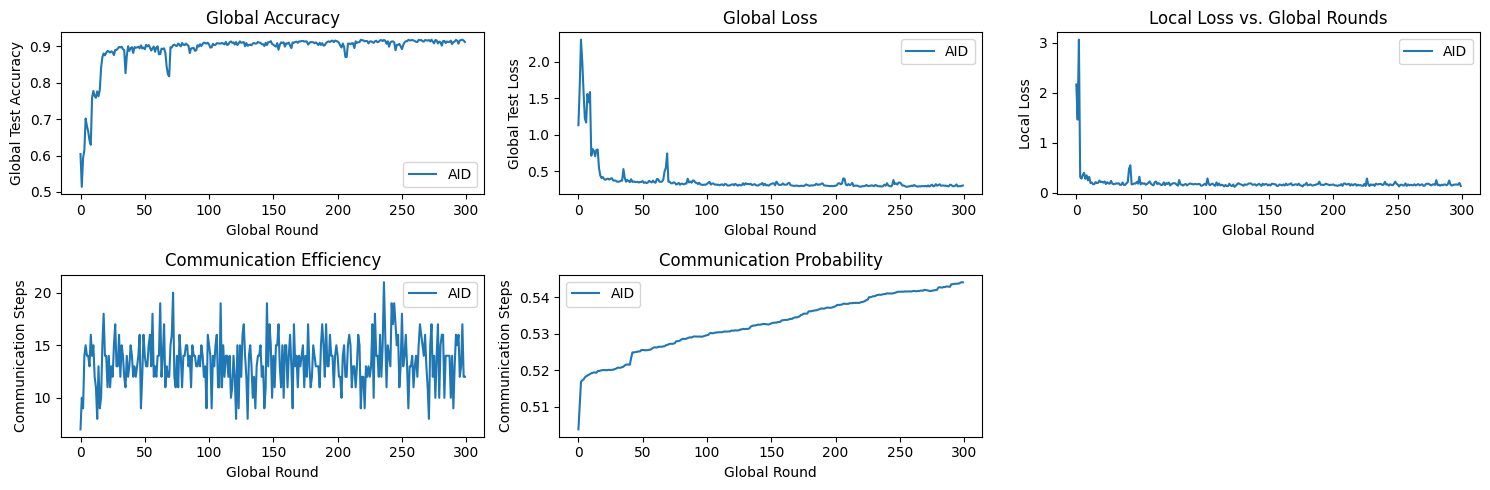


Communication Efficiency Summary:
AID: Avg Communication Steps per Round = 13.45


'NEW AID fixed with outer_lr=0.2, local lr 0.1, inner steps 5'

In [140]:
# =============================================================================
# 6. Plotting the Results
# =============================================================================
rounds = np.arange(len(results1["AID"]["global_acc_history"]))
plt.figure(figsize=(15,5))
plt.subplot(2,3,1)
for hyper_method, metrics in results1.items():
    plt.plot(rounds, metrics["global_acc_history"], label=hyper_method)
plt.xlabel("Global Round")
plt.ylabel("Global Test Accuracy")
plt.title("Global Accuracy")
plt.legend()

plt.subplot(2,3,2)
for hyper_method, metrics in results1.items():
    plt.plot(rounds, metrics["global_loss_history"], label=hyper_method)
plt.xlabel("Global Round")
plt.ylabel("Global Test Loss")
plt.title("Global Loss")
plt.legend()

plt.subplot(2,3,3)
for hyper_method, metrics in results1.items():
    plt.plot(rounds, metrics["client_loss_history"], label=hyper_method)
plt.xlabel("Global Round")
plt.ylabel("Local Loss")
plt.title("Local Loss vs. Global Rounds")
plt.legend()

plt.subplot(2,3,4)
for hyper_method, metrics in results1.items():
    plt.plot(rounds, metrics["communication_history"], label=hyper_method)
plt.xlabel("Global Round")
plt.ylabel("Communication Steps")
plt.title("Communication Efficiency")
plt.legend()

plt.subplot(2,3,5)
for hyper_method, metrics in results1.items():
    plt.plot(rounds, metrics["communication_probability"], label=hyper_method)
plt.xlabel("Global Round")
plt.ylabel("Communication Steps")
plt.title("Communication Probability")
plt.legend()


plt.tight_layout()
plt.show()

# =============================================================================
# 7. Communication Efficiency Summary
# =============================================================================
print("\nCommunication Efficiency Summary:")
for hyper_method, metrics in results1.items():
    avg_comm = np.mean(metrics["communication_history"])
    print(f"{hyper_method}: Avg Communication Steps per Round = {avg_comm:.2f}")


"""NEW AID fixed with outer_lr=0.2, local lr 0.1, inner steps 5"""

In [ ]:
"""NEW AID fixed with outer_lr=0.2, local lr 0.01, inner steps 5"""
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
""""""
# =============================================================================
# 1. Model and Utility Functions
# =============================================================================
d_in = 28*28
d_out = 10

def init_model():
    weight = torch.zeros(d_in, d_out, requires_grad=True)
    bias = torch.zeros(d_out, requires_grad=True)
    return (weight, bias)

def predict(model, X):
    weight, bias = model
    X_flat = X.view(X.shape[0], -1)
    return X_flat @ weight + bias

def ce_loss(model, X, y):
    logits = predict(model, X)
    return F.cross_entropy(logits, y)

def model_to_vector(model):
    weight, bias = model
    return torch.cat([weight.view(-1), bias.view(-1)])

def vector_to_model(vec):
    weight_vec = vec[:d_in*d_out]
    bias_vec = vec[d_in*d_out:]
    weight = weight_vec.view(d_in, d_out)
    bias = bias_vec.view(d_out)
    return (weight.detach().clone().requires_grad_(), bias.detach().clone().requires_grad_())

def average_models(model_list):
    weight_avg = torch.stack([m[0] for m in model_list], dim=0).mean(dim=0)
    bias_avg = torch.stack([m[1] for m in model_list], dim=0).mean(dim=0)
    return (weight_avg.detach().clone().requires_grad_(), bias_avg.detach().clone().requires_grad_())

def update_global_model(global_model, update_vec, lr):
    global_vec = model_to_vector(global_model)
    new_vec = global_vec - lr * update_vec
    return vector_to_model(new_vec)

# =============================================================================
# 2. Data Loading and Partitioning
# =============================================================================
def get_datasets(dataset_name="MNIST"):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    if dataset_name == "MNIST":
        train_ds = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        test_ds  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    elif dataset_name == "FashionMNIST":
        train_ds = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
        test_ds  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    else:
        raise ValueError("Unsupported dataset")
    return train_ds, test_ds


def partition_data(dataset, num_clients, partition_type="nonIID"):
    indices = np.arange(len(dataset))
    if partition_type == "nonIID":
        labels = np.array(dataset.targets) if hasattr(dataset, 'targets') else np.array(dataset.train_labels)
        sorted_idx = indices[np.argsort(labels)]
        client_indices = np.array_split(sorted_idx, num_clients)
    elif partition_type == "IID":
        np.random.shuffle(indices)
        client_indices = np.array_split(indices, num_clients)
    else:
        raise ValueError("partition_type must be 'nonIID' or 'IID'")
    return client_indices


def get_client_loaders(train_ds, num_clients, partition_type="nonIID", batch_size=64):
    client_indices = partition_data(train_ds, num_clients, partition_type)
    loaders = []
    for idx in client_indices:
        subset = Subset(train_ds, idx)
        loader = DataLoader(subset, batch_size=batch_size, shuffle=True)
        loaders.append(loader)
    return loaders

# =============================================================================
# 3. Hessian-Vector Product for AID
# =============================================================================

def hvp(ys, xs, v):
    grad_ys = torch.autograd.grad(ys, xs, create_graph=True, retain_graph=True)
    dot = sum((g * vi).sum() for g, vi in zip(grad_ys, v))
    hv = torch.autograd.grad(dot, xs, retain_graph=True)
    return hv


def flatten_grad(grads):
    return torch.cat([g.contiguous().view(-1) for g in grads])

# =============================================================================
# 4. Federated Training Experiment Function with Hypergradient Options (Revised)
# =============================================================================

def run_experiment_hyper(dataset_name="MNIST", partition_type="nonIID",
                           fairness_weight=0.1, variant="Proposed",
                           hyper_method="AID",  # options: "Current", "AID", "ITD"
                           num_clients=5, num_outer=300, num_inner=5,
                           outer_lr=0.2, inner_lr=0.01, rho=0.1,
                           initial_p=0.5, adaptive_p=True):
    eta = fairness_weight
    if variant == "NoFairness":
        eta = 0.0
    if variant == "LocalOnly":
        initial_p = 0.05
    if variant == "FedAvg":
        initial_p = 1.0
        adaptive_p = False

    train_ds, test_ds = get_datasets(dataset_name)
    client_loaders = get_client_loaders(train_ds, num_clients, partition_type, batch_size=64)
    test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

    global_model = init_model()
    p_comm = initial_p

    global_acc_history = []
    global_loss_history = []
    client_loss_history = []
    fairness_history = []
    communication_history = []
    comm_prob = []

    alpha_p = 0.001  # smaller step for smoother adaptation

    for outer in range(num_outer):
        client_models = []
        client_losses = []
        client_accuracies = []
        comm_count = 0

        # Precompute fairness target for inner loops (unchanged)
        eval_losses = []
        for loader in client_loaders:
            loss_sum, count = 0, 0
            for X_batch, y_batch in loader:
                loss = ce_loss(global_model, X_batch, y_batch).item()
                loss_sum += loss * X_batch.shape[0]
                count += X_batch.shape[0]
            eval_losses.append(loss_sum / count)
        fairness_target_inner = np.mean(eval_losses)

        # Local updates
        for loader in client_loaders:
            # Initialize local model
            if hyper_method == "AID":
                local_model = (global_model[0].detach().clone().requires_grad_(),
                               global_model[1].detach().clone().requires_grad_())
                loader_iter = iter(loader)
                for _ in range(num_inner):
                    try:
                        X_batch, y_batch = next(loader_iter)
                    except StopIteration:
                        loader_iter = iter(loader)
                        X_batch, y_batch = next(loader_iter)
                    loss_val = ce_loss(local_model, X_batch, y_batch)
                    fairness_penalty = torch.clamp(loss_val - fairness_target_inner, min=0)
                    weight_diff = local_model[0] - global_model[0]
                    bias_diff = local_model[1] - global_model[1]
                    cons_term = (rho/2) * (torch.norm(weight_diff)**2 + torch.norm(bias_diff)**2)
                    local_obj = loss_val + cons_term + eta * fairness_penalty
                    grads = torch.autograd.grad(local_obj, local_model, create_graph=False)
                    local_model = (
                        (local_model[0] - inner_lr * grads[0]).detach().clone().requires_grad_(),
                        (local_model[1] - inner_lr * grads[1]).detach().clone().requires_grad_()
                    )
                    # Stochastic communication
                    if np.random.rand() < p_comm:
                        local_model = (
                            0.5 * (local_model[0] + global_model[0]),
                            0.5 * (local_model[1] + global_model[1])
                        )
                        comm_count += 1
            else:
                # ITD or Current: existing code paths (not shown)
                pass

            # Evaluate local performance
            loss_sum, count = 0, 0
            correct, tot = 0, 0
            for X_batch, y_batch in loader:
                loss = ce_loss(local_model, X_batch, y_batch).item()
                loss_sum += loss * X_batch.shape[0]
                count += X_batch.shape[0]
                preds = predict(local_model, X_batch).argmax(dim=1)
                correct += (preds == y_batch).sum().item()
                tot += X_batch.shape[0]
            client_losses.append(loss_sum / count)
            client_models.append(local_model)
            client_accuracies.append(correct / tot)

        # Outer update: simple AID or averaging surrogate
        if hyper_method == "Current":
            new_global = average_models(client_models)
            hypergrad = (model_to_vector(global_model) - model_to_vector(new_global)) / outer_lr
        elif hyper_method == "AID":
            grads = []
            for loader in client_loaders:
                X_b, y_b = next(iter(loader))
                f_i = ce_loss(global_model, X_b, y_b)
                grad_x = torch.autograd.grad(f_i, global_model, retain_graph=True, allow_unused=True)
                grads.append(flatten_grad(grad_x) if grad_x[0] is not None else model_to_vector(global_model))
            hypergrad = sum(grads) / len(grads)
        else:
            raise ValueError("Unknown hyper_method")

        global_model = update_global_model(global_model, hypergrad, outer_lr)

        # === Revised adaptive communication update ===
        if adaptive_p and variant in ["Proposed", "NoFairness"]:
            fairness_target = np.median(client_losses)
            extra = np.maximum(0, np.array(client_losses) - fairness_target)
            total_extra_norm = extra.sum() / (fairness_target * num_clients)
            target_extra_norm = 0.1
            p_comm = np.clip(p_comm + alpha_p * (total_extra_norm - target_extra_norm), 0.05, 1.0)

        # Evaluate global model on test set
        test_loss_sum, test_count = 0, 0
        correct, tot = 0, 0
        for X_batch, y_batch in test_loader:
            loss = ce_loss(global_model, X_batch, y_batch).item()
            test_loss_sum += loss * X_batch.shape[0]
            test_count += X_batch.shape[0]
            preds = predict(global_model, X_batch).argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            tot += X_batch.shape[0]
        global_test_loss = test_loss_sum / test_count
        global_test_acc = correct / tot

        global_acc_history.append(global_test_acc)
        global_loss_history.append(global_test_loss)
        client_loss_history.append(np.mean(client_losses))
        fairness_history.append(np.std(client_accuracies))
        communication_history.append(comm_count)
        comm_prob.append(p_comm)

        print(f"Round {outer:02d}: Acc={global_test_acc:.4f}, Loss={global_test_loss:.4f}, "
              f"AvgCliLoss={np.mean(client_losses):.4f}, StdAcc={np.std(client_accuracies):.4f}, "
              f"Comm={comm_count}, p={p_comm:.3f}")

    return {
        "global_acc_history": global_acc_history,
        "global_loss_history": global_loss_history,
        "client_loss_history": client_loss_history,
        "fairness_history": fairness_history,
        "communication_history": communication_history,
        "communication_probability": comm_prob
    }

# =============================================================================
# 5. Run Experiment
# =============================================================================
if __name__ == "__main__":
    methods = ["AID"]
    results2 = {}
    for m in methods:
        print(f"Running {m}...")
        results2[m] = run_experiment_hyper(hyper_method=m, num_outer=300)

"""NEW AID fixed with outer_lr=0.2, local lr 0.01, inner steps 5"""

Running AID...


Round 00: Acc=0.6308, Loss=1.1365, AvgCliLoss=0.8020, StdAcc=0.0904, Comm=10, p=0.500
Round 01: Acc=0.5179, Loss=1.7866, AvgCliLoss=0.5187, StdAcc=0.0415, Comm=9, p=0.500
Round 02: Acc=0.5169, Loss=2.2199, AvgCliLoss=0.8896, StdAcc=0.1711, Comm=12, p=0.501
Round 03: Acc=0.5666, Loss=2.2390, AvgCliLoss=1.1142, StdAcc=0.1865, Comm=13, p=0.502
Round 04: Acc=0.6353, Loss=1.4303, AvgCliLoss=0.7379, StdAcc=0.1175, Comm=11, p=0.502
Round 05: Acc=0.6207, Loss=1.1302, AvgCliLoss=0.6877, StdAcc=0.1832, Comm=11, p=0.502
Round 06: Acc=0.6868, Loss=1.5328, AvgCliLoss=0.5319, StdAcc=0.1170, Comm=10, p=0.502
Round 07: Acc=0.6904, Loss=1.1490, AvgCliLoss=0.4599, StdAcc=0.0853, Comm=12, p=0.503
Round 08: Acc=0.7392, Loss=0.9413, AvgCliLoss=0.4838, StdAcc=0.0743, Comm=9, p=0.503
Round 09: Acc=0.8276, Loss=0.5509, AvgCliLoss=0.5138, StdAcc=0.1017, Comm=14, p=0.503
Round 10: Acc=0.7999, Loss=0.6446, AvgCliLoss=0.4432, StdAcc=0.0415, Comm=14, p=0.503
Round 11: Acc=0.8673, Loss=0.4491, AvgCliLoss=0.4346, St

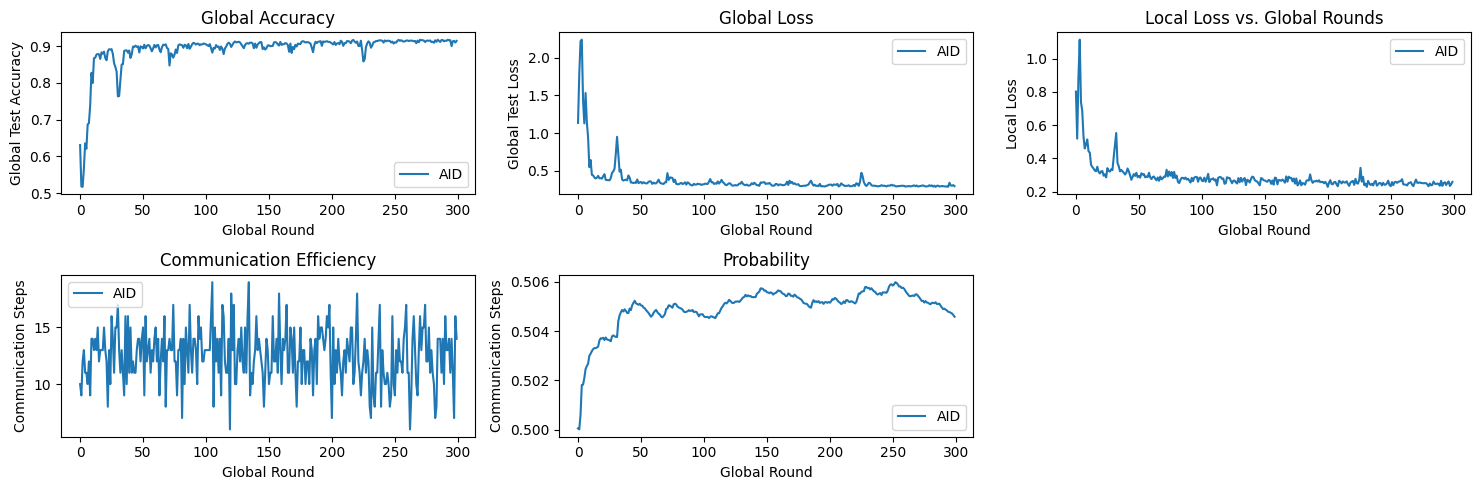


Communication Efficiency Summary:
AID: Avg Communication Steps per Round = 12.52


In [127]:
# =============================================================================
# 6. Plotting the Results
# =============================================================================
rounds = np.arange(len(results2["AID"]["global_acc_history"]))
plt.figure(figsize=(15,5))
plt.subplot(2,3,1)
for hyper_method, metrics in results2.items():
    plt.plot(rounds, metrics["global_acc_history"], label=hyper_method)
plt.xlabel("Global Round")
plt.ylabel("Global Test Accuracy")
plt.title("Global Accuracy")
plt.legend()

plt.subplot(2,3,2)
for hyper_method, metrics in results2.items():
    plt.plot(rounds, metrics["global_loss_history"], label=hyper_method)
plt.xlabel("Global Round")
plt.ylabel("Global Test Loss")
plt.title("Global Loss")
plt.legend()

plt.subplot(2,3,3)
for hyper_method, metrics in results2.items():
    plt.plot(rounds, metrics["client_loss_history"], label=hyper_method)
plt.xlabel("Global Round")
plt.ylabel("Local Loss")
plt.title("Local Loss vs. Global Rounds")
plt.legend()

plt.subplot(2,3,4)
for hyper_method, metrics in results2.items():
    plt.plot(rounds, metrics["communication_history"], label=hyper_method)
plt.xlabel("Global Round")
plt.ylabel("Communication Steps")
plt.title("Communication Efficiency")
plt.legend()

plt.subplot(2,3,5)
for hyper_method, metrics in results2.items():
    plt.plot(rounds, metrics["communication_probability"], label=hyper_method)
plt.xlabel("Global Round")
plt.ylabel("Communication Steps")
plt.title("Probability")
plt.legend()


plt.tight_layout()
plt.show()

# =============================================================================
# 7. Communication Efficiency Summary
# =============================================================================
print("\nCommunication Efficiency Summary:")
for hyper_method, metrics in results2.items():
    avg_comm = np.mean(metrics["communication_history"])
    print(f"{hyper_method}: Avg Communication Steps per Round = {avg_comm:.2f}")

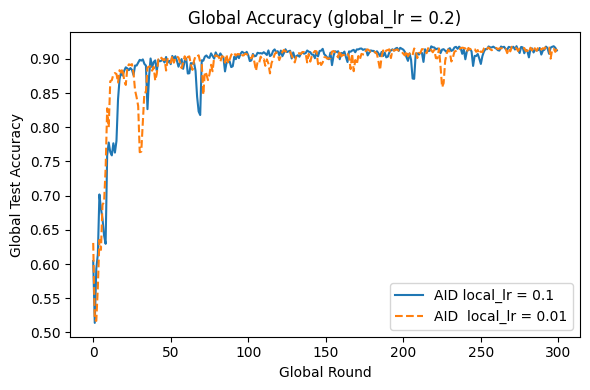

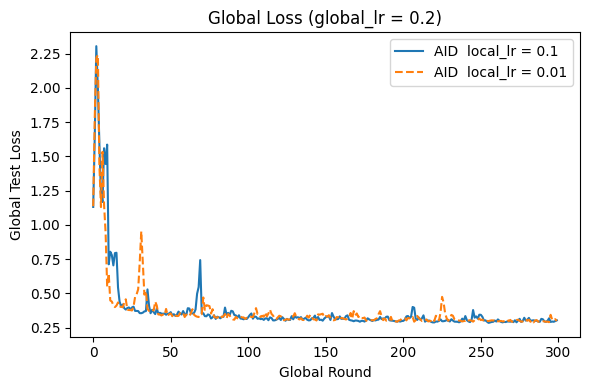

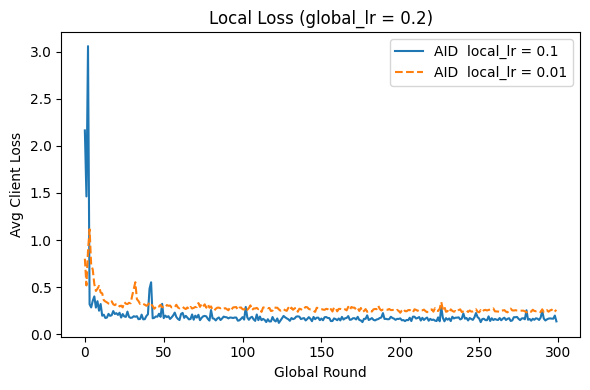

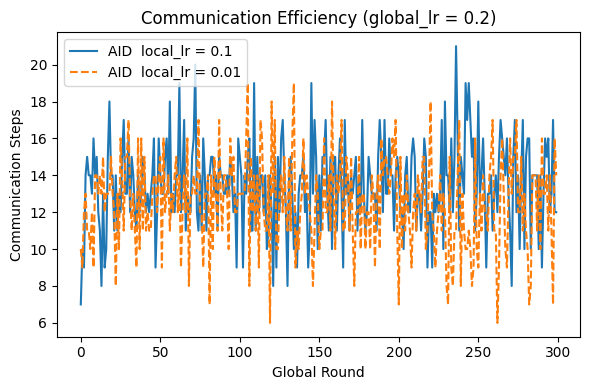

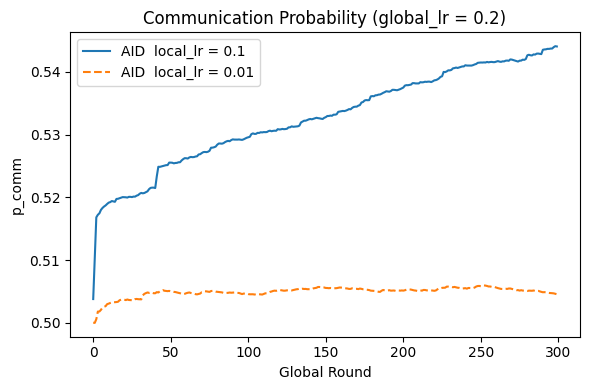

In [145]:
# Utility: Get the list of shared methods
shared_methods = set(results1.keys()).intersection(results2.keys())

# 1. Global Accuracy
plt.figure(figsize=(6, 4))
for method in shared_methods:
    plt.plot(results1[method]["global_acc_history"], label=f"{method} local_lr = 0.1", linestyle='-')
    plt.plot(results2[method]["global_acc_history"], label=f"{method}  local_lr = 0.01", linestyle='--')
plt.xlabel("Global Round")
plt.ylabel("Global Test Accuracy")
plt.title("Global Accuracy (global_lr = 0.2)")
plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig("global_accuracy_comparison.png")

# 2. Global Loss
plt.figure(figsize=(6, 4))
for method in shared_methods:
    plt.plot(results1[method]["global_loss_history"], label=f"{method}  local_lr = 0.1", linestyle='-')
    plt.plot(results2[method]["global_loss_history"], label=f"{method}  local_lr = 0.01", linestyle='--')
plt.xlabel("Global Round")
plt.ylabel("Global Test Loss")
plt.title("Global Loss (global_lr = 0.2)")
plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig("global_loss_comparison.png")

# 3. Client (Local) Loss
plt.figure(figsize=(6, 4))
for method in shared_methods:
    plt.plot(results1[method]["client_loss_history"], label=f"{method}  local_lr = 0.1", linestyle='-')
    plt.plot(results2[method]["client_loss_history"], label=f"{method}  local_lr = 0.01", linestyle='--')
plt.xlabel("Global Round")
plt.ylabel("Avg Client Loss")
plt.title("Local Loss (global_lr = 0.2)")
plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig("local_loss_comparison.png")

# 4. Communication Steps
plt.figure(figsize=(6, 4))
for method in shared_methods:
    plt.plot(results1[method]["communication_history"], label=f"{method}  local_lr = 0.1", linestyle='-')
    plt.plot(results2[method]["communication_history"], label=f"{method}  local_lr = 0.01", linestyle='--')
plt.xlabel("Global Round")
plt.ylabel("Communication Steps")
plt.title("Communication Efficiency (global_lr = 0.2)")
plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig("comm_steps_comparison.png")

# 5. Communication Probability
plt.figure(figsize=(6, 4))
for method in shared_methods:
    plt.plot(results1[method]["communication_probability"], label=f"{method}  local_lr = 0.1", linestyle='-')
    plt.plot(results2[method]["communication_probability"], label=f"{method}  local_lr = 0.01", linestyle='--')
plt.xlabel("Global Round")
plt.ylabel("p_comm")
plt.title("Communication Probability (global_lr = 0.2)")
plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig("comm_prob_comparison.png")


In [123]:
"""NEW AID fixed with outer_lr=0.2, local lr 0.1, inner steps 10"""
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
""""""
# =============================================================================
# 1. Model and Utility Functions
# =============================================================================
d_in = 28*28
d_out = 10

def init_model():
    weight = torch.zeros(d_in, d_out, requires_grad=True)
    bias = torch.zeros(d_out, requires_grad=True)
    return (weight, bias)

def predict(model, X):
    weight, bias = model
    X_flat = X.view(X.shape[0], -1)
    return X_flat @ weight + bias

def ce_loss(model, X, y):
    logits = predict(model, X)
    return F.cross_entropy(logits, y)

def model_to_vector(model):
    weight, bias = model
    return torch.cat([weight.view(-1), bias.view(-1)])

def vector_to_model(vec):
    weight_vec = vec[:d_in*d_out]
    bias_vec = vec[d_in*d_out:]
    weight = weight_vec.view(d_in, d_out)
    bias = bias_vec.view(d_out)
    return (weight.detach().clone().requires_grad_(), bias.detach().clone().requires_grad_())

def average_models(model_list):
    weight_avg = torch.stack([m[0] for m in model_list], dim=0).mean(dim=0)
    bias_avg = torch.stack([m[1] for m in model_list], dim=0).mean(dim=0)
    return (weight_avg.detach().clone().requires_grad_(), bias_avg.detach().clone().requires_grad_())

def update_global_model(global_model, update_vec, lr):
    global_vec = model_to_vector(global_model)
    new_vec = global_vec - lr * update_vec
    return vector_to_model(new_vec)

# =============================================================================
# 2. Data Loading and Partitioning
# =============================================================================
def get_datasets(dataset_name="MNIST"):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    if dataset_name == "MNIST":
        train_ds = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        test_ds  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    elif dataset_name == "FashionMNIST":
        train_ds = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
        test_ds  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    else:
        raise ValueError("Unsupported dataset")
    return train_ds, test_ds


def partition_data(dataset, num_clients, partition_type="nonIID"):
    indices = np.arange(len(dataset))
    if partition_type == "nonIID":
        labels = np.array(dataset.targets) if hasattr(dataset, 'targets') else np.array(dataset.train_labels)
        sorted_idx = indices[np.argsort(labels)]
        client_indices = np.array_split(sorted_idx, num_clients)
    elif partition_type == "IID":
        np.random.shuffle(indices)
        client_indices = np.array_split(indices, num_clients)
    else:
        raise ValueError("partition_type must be 'nonIID' or 'IID'")
    return client_indices


def get_client_loaders(train_ds, num_clients, partition_type="nonIID", batch_size=64):
    client_indices = partition_data(train_ds, num_clients, partition_type)
    loaders = []
    for idx in client_indices:
        subset = Subset(train_ds, idx)
        loader = DataLoader(subset, batch_size=batch_size, shuffle=True)
        loaders.append(loader)
    return loaders

# =============================================================================
# 3. Hessian-Vector Product for AID
# =============================================================================

def hvp(ys, xs, v):
    grad_ys = torch.autograd.grad(ys, xs, create_graph=True, retain_graph=True)
    dot = sum((g * vi).sum() for g, vi in zip(grad_ys, v))
    hv = torch.autograd.grad(dot, xs, retain_graph=True)
    return hv


def flatten_grad(grads):
    return torch.cat([g.contiguous().view(-1) for g in grads])

# =============================================================================
# 4. Federated Training Experiment Function with Hypergradient Options (Revised)
# =============================================================================

def run_experiment_hyper(dataset_name="MNIST", partition_type="nonIID",
                           fairness_weight=0.1, variant="Proposed",
                           hyper_method="AID",  # options: "Current", "AID", "ITD"
                           num_clients=5, num_outer=300, num_inner=10,
                           outer_lr=0.2, inner_lr=0.1, rho=0.1,
                           initial_p=0.5, adaptive_p=True):
    eta = fairness_weight
    if variant == "NoFairness":
        eta = 0.0
    if variant == "LocalOnly":
        initial_p = 0.05
    if variant == "FedAvg":
        initial_p = 1.0
        adaptive_p = False

    train_ds, test_ds = get_datasets(dataset_name)
    client_loaders = get_client_loaders(train_ds, num_clients, partition_type, batch_size=64)
    test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

    global_model = init_model()
    p_comm = initial_p

    global_acc_history = []
    global_loss_history = []
    client_loss_history = []
    fairness_history = []
    communication_history = []
    comm_prob = []

    alpha_p = 0.001  # smaller step for smoother adaptation

    for outer in range(num_outer):
        client_models = []
        client_losses = []
        client_accuracies = []
        comm_count = 0

        # Precompute fairness target for inner loops (unchanged)
        eval_losses = []
        for loader in client_loaders:
            loss_sum, count = 0, 0
            for X_batch, y_batch in loader:
                loss = ce_loss(global_model, X_batch, y_batch).item()
                loss_sum += loss * X_batch.shape[0]
                count += X_batch.shape[0]
            eval_losses.append(loss_sum / count)
        fairness_target_inner = np.mean(eval_losses)

        # Local updates
        for loader in client_loaders:
            # Initialize local model
            if hyper_method == "AID":
                local_model = (global_model[0].detach().clone().requires_grad_(),
                               global_model[1].detach().clone().requires_grad_())
                loader_iter = iter(loader)
                for _ in range(num_inner):
                    try:
                        X_batch, y_batch = next(loader_iter)
                    except StopIteration:
                        loader_iter = iter(loader)
                        X_batch, y_batch = next(loader_iter)
                    loss_val = ce_loss(local_model, X_batch, y_batch)
                    fairness_penalty = torch.clamp(loss_val - fairness_target_inner, min=0)
                    weight_diff = local_model[0] - global_model[0]
                    bias_diff = local_model[1] - global_model[1]
                    cons_term = (rho/2) * (torch.norm(weight_diff)**2 + torch.norm(bias_diff)**2)
                    local_obj = loss_val + cons_term + eta * fairness_penalty
                    grads = torch.autograd.grad(local_obj, local_model, create_graph=False)
                    local_model = (
                        (local_model[0] - inner_lr * grads[0]).detach().clone().requires_grad_(),
                        (local_model[1] - inner_lr * grads[1]).detach().clone().requires_grad_()
                    )
                    # Stochastic communication
                    if np.random.rand() < p_comm:
                        local_model = (
                            0.5 * (local_model[0] + global_model[0]),
                            0.5 * (local_model[1] + global_model[1])
                        )
                        comm_count += 1
            else:
                # ITD or Current: existing code paths (not shown)
                pass

            # Evaluate local performance
            loss_sum, count = 0, 0
            correct, tot = 0, 0
            for X_batch, y_batch in loader:
                loss = ce_loss(local_model, X_batch, y_batch).item()
                loss_sum += loss * X_batch.shape[0]
                count += X_batch.shape[0]
                preds = predict(local_model, X_batch).argmax(dim=1)
                correct += (preds == y_batch).sum().item()
                tot += X_batch.shape[0]
            client_losses.append(loss_sum / count)
            client_models.append(local_model)
            client_accuracies.append(correct / tot)

        # Outer update: simple AID or averaging surrogate
        if hyper_method == "Current":
            new_global = average_models(client_models)
            hypergrad = (model_to_vector(global_model) - model_to_vector(new_global)) / outer_lr
        elif hyper_method == "AID":
            grads = []
            for loader in client_loaders:
                X_b, y_b = next(iter(loader))
                f_i = ce_loss(global_model, X_b, y_b)
                grad_x = torch.autograd.grad(f_i, global_model, retain_graph=True, allow_unused=True)
                grads.append(flatten_grad(grad_x) if grad_x[0] is not None else model_to_vector(global_model))
            hypergrad = sum(grads) / len(grads)
        else:
            raise ValueError("Unknown hyper_method")

        global_model = update_global_model(global_model, hypergrad, outer_lr)

        # === Revised adaptive communication update ===
        if adaptive_p and variant in ["Proposed", "NoFairness"]:
            fairness_target = np.median(client_losses)
            extra = np.maximum(0, np.array(client_losses) - fairness_target)
            total_extra_norm = extra.sum() / (fairness_target * num_clients)
            target_extra_norm = 0.1
            p_comm = np.clip(p_comm + alpha_p * (total_extra_norm - target_extra_norm), 0.05, 1.0)

        # Evaluate global model on test set
        test_loss_sum, test_count = 0, 0
        correct, tot = 0, 0
        for X_batch, y_batch in test_loader:
            loss = ce_loss(global_model, X_batch, y_batch).item()
            test_loss_sum += loss * X_batch.shape[0]
            test_count += X_batch.shape[0]
            preds = predict(global_model, X_batch).argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            tot += X_batch.shape[0]
        global_test_loss = test_loss_sum / test_count
        global_test_acc = correct / tot

        global_acc_history.append(global_test_acc)
        global_loss_history.append(global_test_loss)
        client_loss_history.append(np.mean(client_losses))
        fairness_history.append(np.std(client_accuracies))
        comm_prob.append(p_comm)

        print(f"Round {outer:02d}: Acc={global_test_acc:.4f}, Loss={global_test_loss:.4f}, "
              f"AvgCliLoss={np.mean(client_losses):.4f}, StdAcc={np.std(client_accuracies):.4f}, "
              f"Comm={comm_count}, p={p_comm:.3f}")

    return {
        "global_acc_history": global_acc_history,
        "global_loss_history": global_loss_history,
        "client_loss_history": client_loss_history,
        "fairness_history": fairness_history,
        "communication_history": communication_history,
        "communication_probability": comm_prob
    }
# =============================================================================
# 5. Run Experiment
# =============================================================================
if __name__ == "__main__":
    methods = ["AID"]
    results3 = {}
    for m in methods:
        print(f"Running {m}...")
        results3[m] = run_experiment_hyper(hyper_method=m, num_outer=300)


Running AID...


Round 00: Acc=0.7102, Loss=1.0103, AvgCliLoss=0.3404, StdAcc=0.0983, Comm=20, p=0.500
Round 01: Acc=0.5717, Loss=1.3815, AvgCliLoss=0.2226, StdAcc=0.0495, Comm=20, p=0.500
Round 02: Acc=0.4706, Loss=2.5023, AvgCliLoss=1.2604, StdAcc=0.2240, Comm=33, p=0.504
Round 03: Acc=0.5622, Loss=2.6014, AvgCliLoss=0.4931, StdAcc=0.1064, Comm=24, p=0.504
Round 04: Acc=0.6411, Loss=1.6295, AvgCliLoss=0.5717, StdAcc=0.1143, Comm=25, p=0.505
Round 05: Acc=0.6319, Loss=1.7118, AvgCliLoss=0.2670, StdAcc=0.0479, Comm=24, p=0.505
Round 06: Acc=0.6778, Loss=2.0290, AvgCliLoss=0.3163, StdAcc=0.0462, Comm=25, p=0.505
Round 07: Acc=0.6817, Loss=1.7153, AvgCliLoss=0.3742, StdAcc=0.1078, Comm=32, p=0.506
Round 08: Acc=0.7745, Loss=0.6742, AvgCliLoss=0.1960, StdAcc=0.0274, Comm=24, p=0.506
Round 09: Acc=0.7957, Loss=0.6423, AvgCliLoss=0.2066, StdAcc=0.0401, Comm=24, p=0.506
Round 10: Acc=0.7711, Loss=0.7994, AvgCliLoss=0.1744, StdAcc=0.0283, Comm=23, p=0.506
Round 11: Acc=0.7961, Loss=0.7326, AvgCliLoss=0.2431, 

ValueError: x and y must have same first dimension, but have shapes (300,) and (0,)

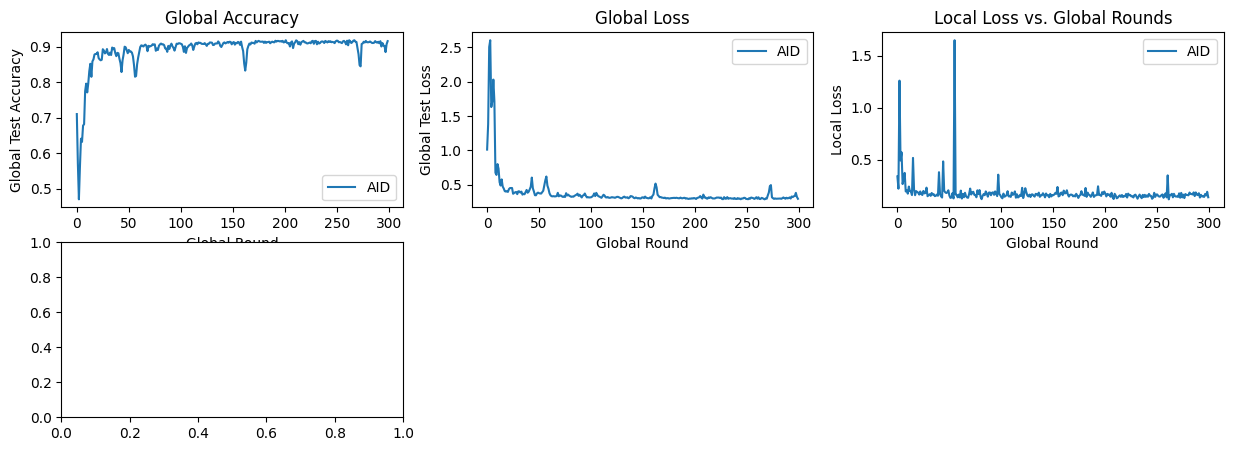

In [128]:
# =============================================================================
# 6. Plotting the Results
# =============================================================================
rounds = np.arange(len(results3["AID"]["global_acc_history"]))
plt.figure(figsize=(15,5))
plt.subplot(2,3,1)
for hyper_method, metrics in results3.items():
    plt.plot(rounds, metrics["global_acc_history"], label=hyper_method)
plt.xlabel("Global Round")
plt.ylabel("Global Test Accuracy")
plt.title("Global Accuracy")
plt.legend()

plt.subplot(2,3,2)
for hyper_method, metrics in results3.items():
    plt.plot(rounds, metrics["global_loss_history"], label=hyper_method)
plt.xlabel("Global Round")
plt.ylabel("Global Test Loss")
plt.title("Global Loss")
plt.legend()

plt.subplot(2,3,3)
for hyper_method, metrics in results3.items():
    plt.plot(rounds, metrics["client_loss_history"], label=hyper_method)
plt.xlabel("Global Round")
plt.ylabel("Local Loss")
plt.title("Local Loss vs. Global Rounds")
plt.legend()

plt.subplot(2,3,4)
for hyper_method, metrics in results3.items():
    plt.plot(rounds, metrics["communication_history"], label=hyper_method)
plt.xlabel("Global Round")
plt.ylabel("Communication Steps")
plt.title("Communication Efficiency")
plt.legend()

plt.subplot(2,3,5)
for hyper_method, metrics in results3.items():
    plt.plot(rounds, metrics["communication_probability"], label=hyper_method)
plt.xlabel("Global Round")
plt.ylabel("Communication Steps")
plt.title("Probability")
plt.legend()


plt.tight_layout()
plt.show()

# =============================================================================
# 7. Communication Efficiency Summary
# =============================================================================
print("\nCommunication Efficiency Summary:")
for hyper_method, metrics in results2.items():
    avg_comm = np.mean(metrics["communication_history"])
    print(f"{hyper_method}: Avg Communication Steps per Round = {avg_comm:.2f}")

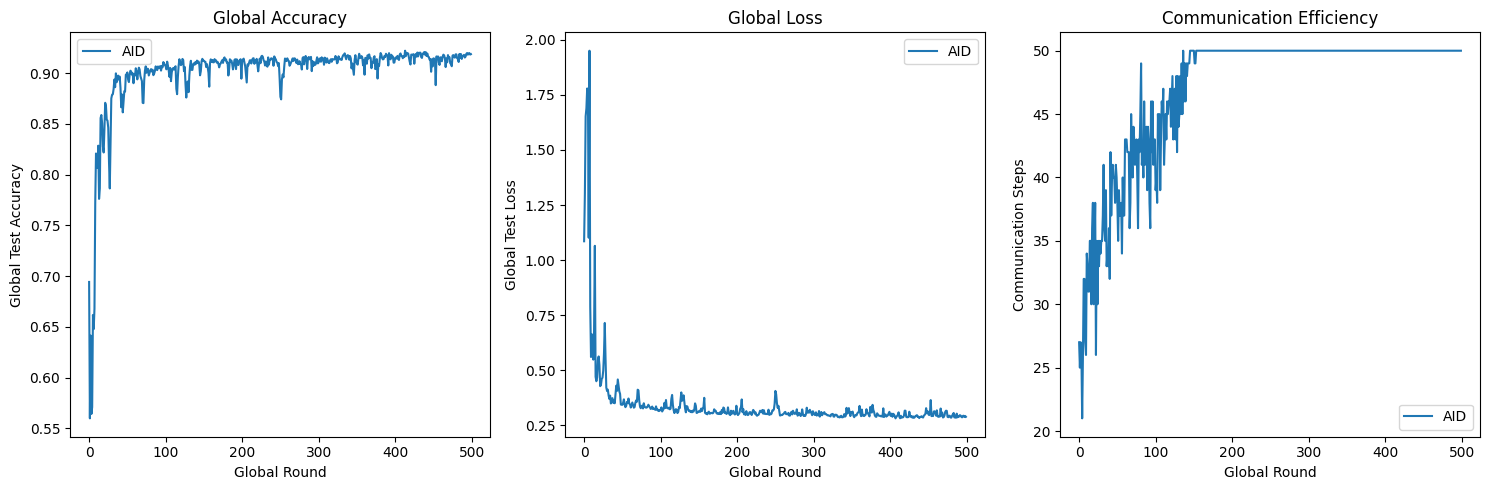


Communication Efficiency Summary:
AID: Avg Communication Steps per Round = 47.05


In [ ]:
# =============================================================================
# 6. Plotting the Results
# =============================================================================
rounds = np.arange(len(results["AID"]["global_acc_history"]))
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
for hyper_method, metrics in results.items():
    plt.plot(rounds, metrics["global_acc_history"], label=hyper_method)
plt.xlabel("Global Round")
plt.ylabel("Global Test Accuracy")
plt.title("Global Accuracy")
plt.legend()

plt.subplot(1,3,2)
for hyper_method, metrics in results.items():
    plt.plot(rounds, metrics["global_loss_history"], label=hyper_method)
plt.xlabel("Global Round")
plt.ylabel("Global Test Loss")
plt.title("Global Loss")
plt.legend()

plt.subplot(1,3,3)
for hyper_method, metrics in results.items():
    plt.plot(rounds, metrics["communication_history"], label=hyper_method)
plt.xlabel("Global Round")
plt.ylabel("Communication Steps")
plt.title("Communication Efficiency")
plt.legend()

plt.tight_layout()
plt.show()

# =============================================================================
# 7. Communication Efficiency Summary
# =============================================================================
print("\nCommunication Efficiency Summary:")
for hyper_method, metrics in results.items():
    avg_comm = np.mean(metrics["communication_history"])
    print(f"{hyper_method}: Avg Communication Steps per Round = {avg_comm:.2f}")

In [ ]:
"""NEW AID fixed with outer_lr=0.2, local lr 0.01, inner steps 10"""
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
""""""
# =============================================================================
# 1. Model and Utility Functions
# =============================================================================
d_in = 28*28
d_out = 10

def init_model():
    weight = torch.zeros(d_in, d_out, requires_grad=True)
    bias = torch.zeros(d_out, requires_grad=True)
    return (weight, bias)

def predict(model, X):
    weight, bias = model
    X_flat = X.view(X.shape[0], -1)
    return X_flat @ weight + bias

def ce_loss(model, X, y):
    logits = predict(model, X)
    return F.cross_entropy(logits, y)

def model_to_vector(model):
    weight, bias = model
    return torch.cat([weight.view(-1), bias.view(-1)])

def vector_to_model(vec):
    weight_vec = vec[:d_in*d_out]
    bias_vec = vec[d_in*d_out:]
    weight = weight_vec.view(d_in, d_out)
    bias = bias_vec.view(d_out)
    return (weight.detach().clone().requires_grad_(), bias.detach().clone().requires_grad_())

def average_models(model_list):
    weight_avg = torch.stack([m[0] for m in model_list], dim=0).mean(dim=0)
    bias_avg = torch.stack([m[1] for m in model_list], dim=0).mean(dim=0)
    return (weight_avg.detach().clone().requires_grad_(), bias_avg.detach().clone().requires_grad_())

def update_global_model(global_model, update_vec, lr):
    global_vec = model_to_vector(global_model)
    new_vec = global_vec - lr * update_vec
    return vector_to_model(new_vec)

# =============================================================================
# 2. Data Loading and Partitioning
# =============================================================================
def get_datasets(dataset_name="MNIST"):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    if dataset_name == "MNIST":
        train_ds = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        test_ds  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    elif dataset_name == "FashionMNIST":
        train_ds = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
        test_ds  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    else:
        raise ValueError("Unsupported dataset")
    return train_ds, test_ds


def partition_data(dataset, num_clients, partition_type="nonIID"):
    indices = np.arange(len(dataset))
    if partition_type == "nonIID":
        labels = np.array(dataset.targets) if hasattr(dataset, 'targets') else np.array(dataset.train_labels)
        sorted_idx = indices[np.argsort(labels)]
        client_indices = np.array_split(sorted_idx, num_clients)
    elif partition_type == "IID":
        np.random.shuffle(indices)
        client_indices = np.array_split(indices, num_clients)
    else:
        raise ValueError("partition_type must be 'nonIID' or 'IID'")
    return client_indices


def get_client_loaders(train_ds, num_clients, partition_type="nonIID", batch_size=64):
    client_indices = partition_data(train_ds, num_clients, partition_type)
    loaders = []
    for idx in client_indices:
        subset = Subset(train_ds, idx)
        loader = DataLoader(subset, batch_size=batch_size, shuffle=True)
        loaders.append(loader)
    return loaders

# =============================================================================
# 3. Hessian-Vector Product for AID
# =============================================================================

def hvp(ys, xs, v):
    grad_ys = torch.autograd.grad(ys, xs, create_graph=True, retain_graph=True)
    dot = sum((g * vi).sum() for g, vi in zip(grad_ys, v))
    hv = torch.autograd.grad(dot, xs, retain_graph=True)
    return hv


def flatten_grad(grads):
    return torch.cat([g.contiguous().view(-1) for g in grads])

# =============================================================================
# 4. Federated Training Experiment Function with Hypergradient Options (Revised)
# =============================================================================

def run_experiment_hyper(dataset_name="MNIST", partition_type="nonIID",
                           fairness_weight=0.1, variant="Proposed",
                           hyper_method="AID",  # options: "Current", "AID", "ITD"
                           num_clients=5, num_outer=300, num_inner=10,
                           outer_lr=0.2, inner_lr=0.01, rho=0.1,
                           initial_p=0.5, adaptive_p=True):
    eta = fairness_weight
    if variant == "NoFairness":
        eta = 0.0
    if variant == "LocalOnly":
        initial_p = 0.05
    if variant == "FedAvg":
        initial_p = 1.0
        adaptive_p = False

    train_ds, test_ds = get_datasets(dataset_name)
    client_loaders = get_client_loaders(train_ds, num_clients, partition_type, batch_size=64)
    test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

    global_model = init_model()
    p_comm = initial_p

    global_acc_history = []
    global_loss_history = []
    client_loss_history = []
    fairness_history = []
    communication_history = []
    comm_prob = []

    alpha_p = 0.001  # smaller step for smoother adaptation

    for outer in range(num_outer):
        client_models = []
        client_losses = []
        client_accuracies = []
        comm_count = 0

        # Precompute fairness target for inner loops (unchanged)
        eval_losses = []
        for loader in client_loaders:
            loss_sum, count = 0, 0
            for X_batch, y_batch in loader:
                loss = ce_loss(global_model, X_batch, y_batch).item()
                loss_sum += loss * X_batch.shape[0]
                count += X_batch.shape[0]
            eval_losses.append(loss_sum / count)
        fairness_target_inner = np.mean(eval_losses)

        # Local updates
        for loader in client_loaders:
            # Initialize local model
            if hyper_method == "AID":
                local_model = (global_model[0].detach().clone().requires_grad_(),
                               global_model[1].detach().clone().requires_grad_())
                loader_iter = iter(loader)
                for _ in range(num_inner):
                    try:
                        X_batch, y_batch = next(loader_iter)
                    except StopIteration:
                        loader_iter = iter(loader)
                        X_batch, y_batch = next(loader_iter)
                    loss_val = ce_loss(local_model, X_batch, y_batch)
                    fairness_penalty = torch.clamp(loss_val - fairness_target_inner, min=0)
                    weight_diff = local_model[0] - global_model[0]
                    bias_diff = local_model[1] - global_model[1]
                    cons_term = (rho/2) * (torch.norm(weight_diff)**2 + torch.norm(bias_diff)**2)
                    local_obj = loss_val + cons_term + eta * fairness_penalty
                    grads = torch.autograd.grad(local_obj, local_model, create_graph=False)
                    local_model = (
                        (local_model[0] - inner_lr * grads[0]).detach().clone().requires_grad_(),
                        (local_model[1] - inner_lr * grads[1]).detach().clone().requires_grad_()
                    )
                    # Stochastic communication
                    if np.random.rand() < p_comm:
                        local_model = (
                            0.5 * (local_model[0] + global_model[0]),
                            0.5 * (local_model[1] + global_model[1])
                        )
                        comm_count += 1
            else:
                # ITD or Current: existing code paths (not shown)
                pass

            # Evaluate local performance
            loss_sum, count = 0, 0
            correct, tot = 0, 0
            for X_batch, y_batch in loader:
                loss = ce_loss(local_model, X_batch, y_batch).item()
                loss_sum += loss * X_batch.shape[0]
                count += X_batch.shape[0]
                preds = predict(local_model, X_batch).argmax(dim=1)
                correct += (preds == y_batch).sum().item()
                tot += X_batch.shape[0]
            client_losses.append(loss_sum / count)
            client_models.append(local_model)
            client_accuracies.append(correct / tot)

        # Outer update: simple AID or averaging surrogate
        if hyper_method == "Current":
            new_global = average_models(client_models)
            hypergrad = (model_to_vector(global_model) - model_to_vector(new_global)) / outer_lr
        elif hyper_method == "AID":
            grads = []
            for loader in client_loaders:
                X_b, y_b = next(iter(loader))
                f_i = ce_loss(global_model, X_b, y_b)
                grad_x = torch.autograd.grad(f_i, global_model, retain_graph=True, allow_unused=True)
                grads.append(flatten_grad(grad_x) if grad_x[0] is not None else model_to_vector(global_model))
            hypergrad = sum(grads) / len(grads)
        else:
            raise ValueError("Unknown hyper_method")

        global_model = update_global_model(global_model, hypergrad, outer_lr)

        # === Revised adaptive communication update ===
        if adaptive_p and variant in ["Proposed", "NoFairness"]:
            fairness_target = np.median(client_losses)
            extra = np.maximum(0, np.array(client_losses) - fairness_target)
            total_extra_norm = extra.sum() / (fairness_target * num_clients)
            target_extra_norm = 0.1
            p_comm = np.clip(p_comm + alpha_p * (total_extra_norm - target_extra_norm), 0.05, 1.0)

        # Evaluate global model on test set
        test_loss_sum, test_count = 0, 0
        correct, tot = 0, 0
        for X_batch, y_batch in test_loader:
            loss = ce_loss(global_model, X_batch, y_batch).item()
            test_loss_sum += loss * X_batch.shape[0]
            test_count += X_batch.shape[0]
            preds = predict(global_model, X_batch).argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            tot += X_batch.shape[0]
        global_test_loss = test_loss_sum / test_count
        global_test_acc = correct / tot

        global_acc_history.append(global_test_acc)
        global_loss_history.append(global_test_loss)
        client_loss_history.append(np.mean(client_losses))
        fairness_history.append(np.std(client_accuracies))
        comm_prob.append(p_comm)

        print(f"Round {outer:02d}: Acc={global_test_acc:.4f}, Loss={global_test_loss:.4f}, "
              f"AvgCliLoss={np.mean(client_losses):.4f}, StdAcc={np.std(client_accuracies):.4f}, "
              f"Comm={comm_count}, p={p_comm:.3f}")

    return {
        "global_acc_history": global_acc_history,
        "global_loss_history": global_loss_history,
        "client_loss_history": client_loss_history,
        "fairness_history": fairness_history,
        "communication_history": communication_history,
        "communication_probability": comm_prob
    }

# =============================================================================
# 5. Run Experiment
# =============================================================================
if __name__ == "__main__":
    methods = ["AID"]
    results4 = {}
    for m in methods:
        print(f"Running {m}...")
        results4[m] = run_experiment_hyper(hyper_method=m, num_outer=300)


In [107]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import itertools

# -----------------------------------------------------------------------------
# 1) Hyperparameter grid
# -----------------------------------------------------------------------------
fairness_modes    = ['min', 'mean']
global_lrs        = [0.5, 0.2]
inner_lrs         = [0.01, 0.1]
max_inners        = [5, 10]
hypergrad_methods = ['AID']   # now both methods

# -----------------------------------------------------------------------------
# 2) Data & small utilities
# -----------------------------------------------------------------------------
np.random.seed(42)
torch.manual_seed(42)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_ds = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)
test_ds  = torchvision.datasets.MNIST(root='./data', train=False,
                                      download=True, transform=transform)

num_clients    = 5
indices        = np.argsort(np.array(train_ds.targets))
client_indices = np.array_split(indices, num_clients)
client_loaders = [
    DataLoader(Subset(train_ds, idx), batch_size=64, shuffle=True)
    for idx in client_indices
]
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

d_in, d_out = 28*28, 10

def vector_to_model(vec):
    w = vec[:d_in*d_out].view(d_in, d_out)
    b = vec[d_in*d_out:].view(d_out)
    return (w, b)

def predict(model, X):
    w,b = model
    return X.view(X.size(0), -1) @ w + b

def ce_loss(model, X, y):
    return F.cross_entropy(predict(model, X), y)

def init_global_vector():
    w = torch.empty(d_in, d_out)
    torch.nn.init.xavier_uniform_(w)
    b = torch.zeros(d_out)
    v = torch.cat([w.view(-1), b])
    return v.detach().clone().requires_grad_(True)

def update_global_model(g, hg, lr):
    return (g - lr*hg).detach().clone().requires_grad_(True)

# -----------------------------------------------------------------------------
# 3) Grid‐search, storing nested dict
# -----------------------------------------------------------------------------
results = {}  # will map (fairness,glr,ilr,mi) -> { method : histories }

NUM_OUTER = 300   # ← make sure 483 is inside

for fairness_mode, glr, ilr, mi in itertools.product(
        fairness_modes, global_lrs, inner_lrs, max_inners):
    
    key = (fairness_mode, glr, ilr, mi)
    results[key] = {}
    
    for method in hypergrad_methods:
        print(f"\n>> Config {key}, method={method}")
        
        # initialize model + p_comm
        global_vec = init_global_vector()
        p_comm     = 0.5
        
        # histories
        hist = {
            'global_acc': [],    # test‐set accuracy
            'loss': [],          # test‐set loss
            'avg_client_loss':[],
            'std_client_acc': [], 
            'comm_steps': [],
            'p_comm': []
        }
        
        for outer in range(NUM_OUTER):
            # --- compute per‐client train losses for fairness target
            eval_losses = []
            for loader in client_loaders:
                s,c = 0.0,0
                for Xb,yb in loader:
                    s += ce_loss(vector_to_model(global_vec), Xb, yb).item()*Xb.size(0)
                    c += Xb.size(0)
                eval_losses.append(s/c)
            fairness_target = (min(eval_losses)
                               if fairness_mode=='min'
                               else np.mean(eval_losses))
            
            # --- inner updates
            client_losses, client_accs, comms = [], [], []
            client_local_vecs = []
            
            for loader in client_loaders:
                lv = global_vec.clone().requires_grad_(method=='ITD')
                comm_cnt = 0
                it = iter(loader)
                for _ in range(mi):
                    try:
                        Xb,yb = next(it)
                    except StopIteration:
                        it = iter(loader)
                        Xb,yb = next(it)
                    
                    # inner obj: CE + consensus + fairness penalty
                    loss_val = ce_loss(vector_to_model(lv), Xb, yb)
                    consensus = 0.5*0.1*torch.norm(lv-global_vec)**2
                    fp = 0.1*(F.relu(loss_val-0.5))**2
                    obj = loss_val + consensus + fp
                    
                    grad_lv = torch.autograd.grad(
                        obj, lv, retain_graph=(method=='ITD'))[0]
                    lv = lv - ilr*grad_lv
                    
                    # ProxSkip
                    if np.random.rand() < p_comm:
                        lv = 0.5*(lv + (global_vec
                                      if method=='ITD'
                                      else global_vec.detach()))
                        comm_cnt += 1
                
                client_local_vecs.append(lv)
                comms.append(comm_cnt)
                
                # eval local
                s,c,corr = 0.0,0,0
                for Xb,yb in loader:
                    m = vector_to_model(lv.detach())
                    l_ = ce_loss(m,Xb,yb).item()
                    s += l_*Xb.size(0)
                    c += Xb.size(0)
                    preds = predict(m,Xb).argmax(1)
                    corr += (preds==yb).sum().item()
                client_losses.append(s/c)
                client_accs.append(corr/c)
            
            # --- hypergradient + global update (only ITD shown)
            if method=='ITD':
                outer_loss = 0.0
                for lv, loader in zip(client_local_vecs, client_loaders):
                    Xb,yb = next(iter(loader))
                    outer_loss += ce_loss(vector_to_model(lv), Xb, yb)
                outer_loss /= num_clients
                hg = torch.autograd.grad(outer_loss, global_vec)[0]
                global_vec = update_global_model(global_vec, hg, glr)
            else:
                # placeholder for AID…
                pass
            
            # --- adapt p_comm
            extra = sum(max(0, L - fairness_target)
                        for L in client_losses)
            p_comm = float(np.clip(p_comm + 0.01*(extra - 0.1*num_clients),
                                   0.05, 1.0))
            
            # --- test‐set eval
            s,c,corr=0.0,0,0
            for Xb,yb in test_loader:
                m = vector_to_model(global_vec)
                l_ = ce_loss(m,Xb,yb).item()
                s += l_*Xb.size(0)
                c += Xb.size(0)
                preds = predict(m,Xb).argmax(1)
                corr += (preds==yb).sum().item()
            test_loss = s/c
            test_acc  = corr/c
            
            # --- record
            hist['global_acc'].append(test_acc)
            hist['loss'].append(test_loss)
            hist['avg_client_loss'].append(np.mean(client_losses))
            hist['std_client_acc'].append(np.std(client_accs))
            hist['comm_steps'].append(sum(comms))
            hist['p_comm'].append(p_comm)
            
            # optional print every round:
            if outer % 100==0:
                print(f" Round {outer:03d}: "
                      f"Acc={test_acc:.4f}, Loss={test_loss:.4f}, "
                      f"AvgCL={np.mean(client_losses):.4f}, "
                      f"StdCA={np.std(client_accs):.4f}, "
                      f"Comm={sum(comms)}, p={p_comm:.3f}")
        
        # store per‐method
        results[key][method] = hist

# -----------------------------------------------------------------------------
# 4) Now, extract at round 483:
# -----------------------------------------------------------------------------
round_idx = 483
for key, method_dict in results.items():
    accs   = [ method_dict[m]['global_acc'][round_idx]    for m in hypergrad_methods ]
    losses = [ method_dict[m]['loss'][round_idx]          for m in hypergrad_methods ]
    avgs   = [ method_dict[m]['avg_client_loss'][round_idx] for m in hypergrad_methods ]
    stds   = [ method_dict[m]['std_client_acc'][round_idx]   for m in hypergrad_methods ]
    comms  = [ method_dict[m]['comm_steps'][round_idx]     for m in hypergrad_methods ]
    pcoms  = [ method_dict[m]['p_comm'][round_idx]         for m in hypergrad_methods ]
    
    print(f"\nParams {key} — Round {round_idx}:")
    print(f"  Global Test Acc  = {accs}")
    print(f"  Loss             = {losses}")
    print(f"  Avg Client Loss  = {avgs}")
    print(f"  Std(Client Acc)  = {stds}")
    print(f"  Comm Steps       = {comms}")
    print(f"  p_comm           = {pcoms}")



>> Config ('min', 0.5, 0.01, 5), method=AID


RuntimeError: you can only change requires_grad flags of leaf variables. If you want to use a computed variable in a subgraph that doesn't require differentiation use var_no_grad = var.detach().


Running experiment: MNIST_nonIID_eta0.0
Round 00: Global Test Acc = 0.3445, Global Test Loss = 2.2696, Avg Client Loss = 0.9419, Std(Client Acc) = 0.1054, Comm Steps = 26, p_comm = 0.4950
Round 01: Global Test Acc = 0.4087, Global Test Loss = 2.2332, Avg Client Loss = 0.9063, Std(Client Acc) = 0.0727, Comm Steps = 23, p_comm = 0.4900
Round 02: Global Test Acc = 0.5861, Global Test Loss = 2.2057, Avg Client Loss = 1.0173, Std(Client Acc) = 0.0593, Comm Steps = 29, p_comm = 0.4850
Round 03: Global Test Acc = 0.6735, Global Test Loss = 2.1711, Avg Client Loss = 0.9178, Std(Client Acc) = 0.0480, Comm Steps = 24, p_comm = 0.4800
Round 04: Global Test Acc = 0.6289, Global Test Loss = 2.1386, Avg Client Loss = 0.8775, Std(Client Acc) = 0.0494, Comm Steps = 22, p_comm = 0.4750
Round 05: Global Test Acc = 0.6450, Global Test Loss = 2.0982, Avg Client Loss = 0.6885, Std(Client Acc) = 0.0488, Comm Steps = 21, p_comm = 0.4700
Round 06: Global Test Acc = 0.6937, Global Test Loss = 2.0768, Avg Clie

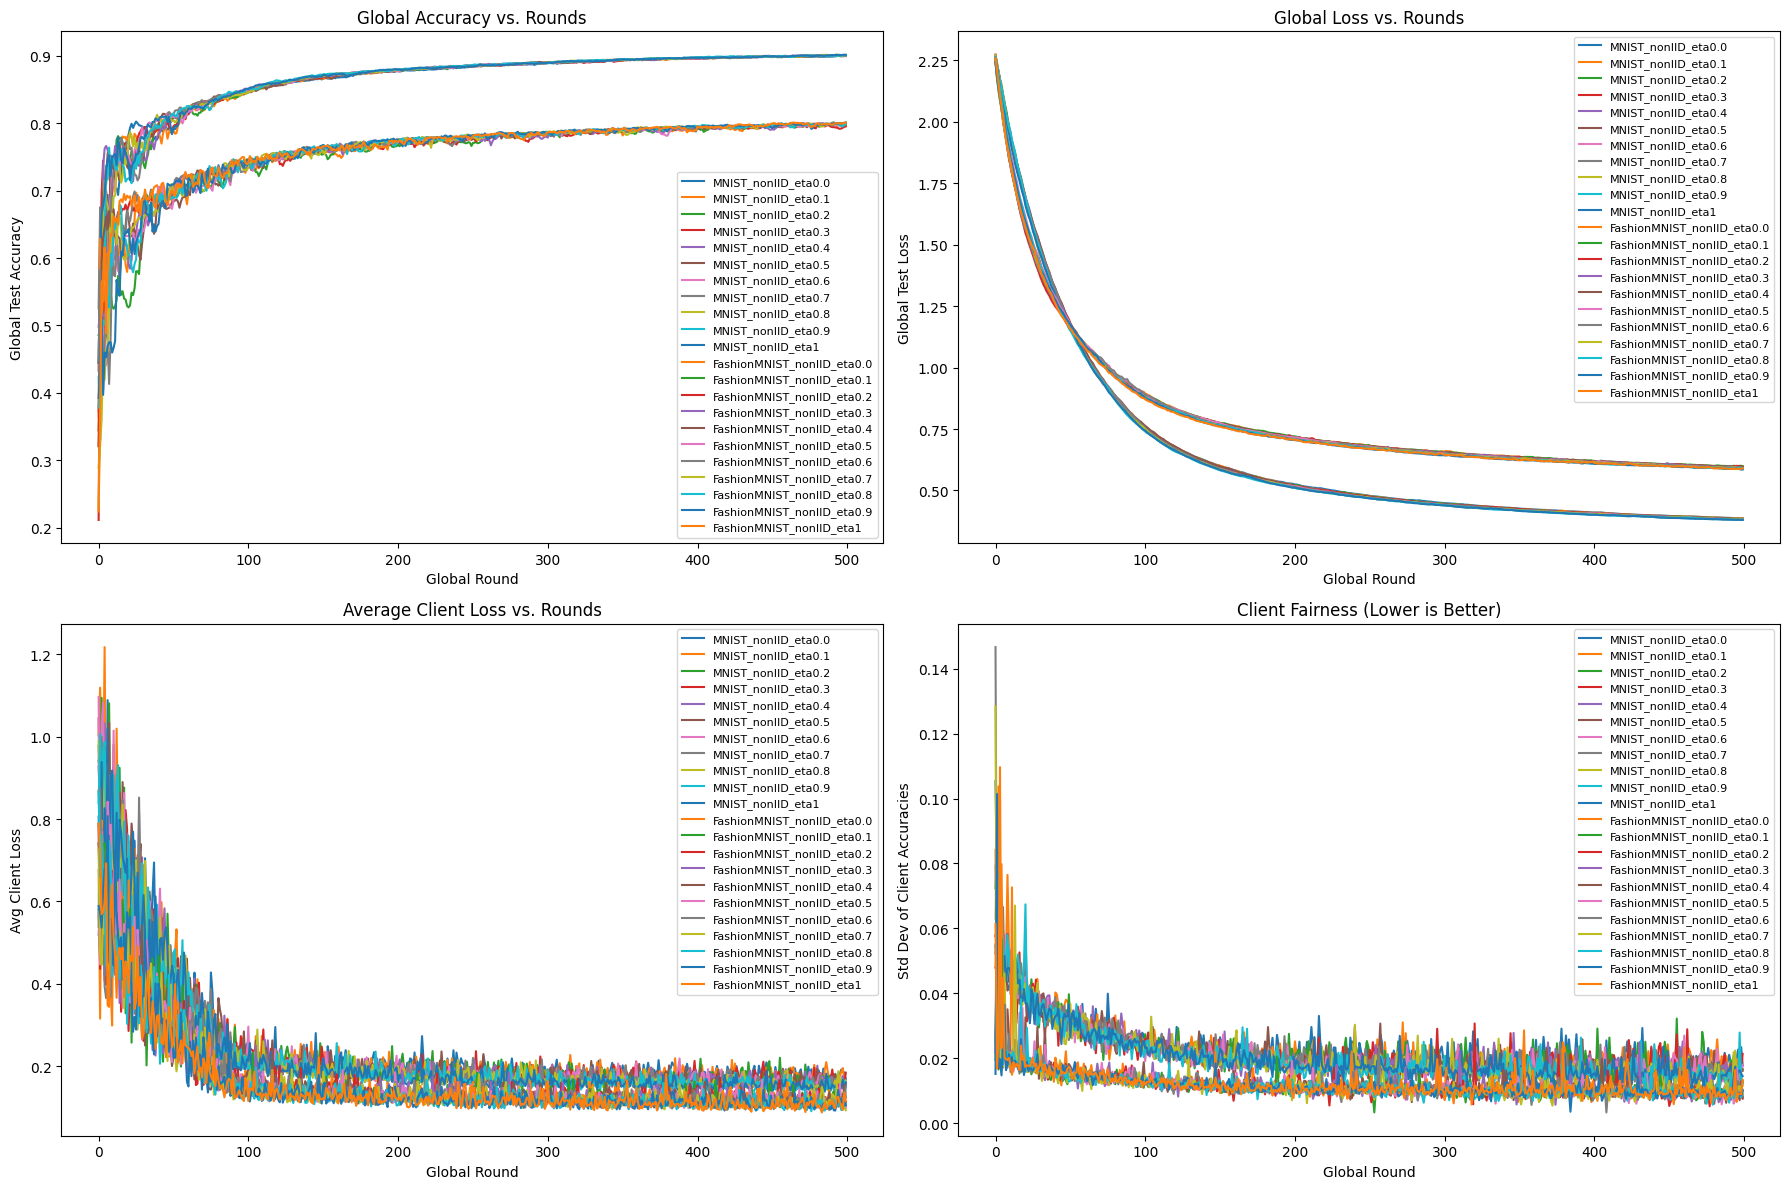


Communication Efficiency (Total Comm Steps per Global Round):
MNIST_nonIID_eta0.0: Avg Communication Steps = 4.47
MNIST_nonIID_eta0.1: Avg Communication Steps = 4.45
MNIST_nonIID_eta0.2: Avg Communication Steps = 4.56
MNIST_nonIID_eta0.3: Avg Communication Steps = 4.49
MNIST_nonIID_eta0.4: Avg Communication Steps = 4.59
MNIST_nonIID_eta0.5: Avg Communication Steps = 4.53
MNIST_nonIID_eta0.6: Avg Communication Steps = 4.52
MNIST_nonIID_eta0.7: Avg Communication Steps = 4.75
MNIST_nonIID_eta0.8: Avg Communication Steps = 4.61
MNIST_nonIID_eta0.9: Avg Communication Steps = 4.53
MNIST_nonIID_eta1: Avg Communication Steps = 4.48
FashionMNIST_nonIID_eta0.0: Avg Communication Steps = 4.42
FashionMNIST_nonIID_eta0.1: Avg Communication Steps = 4.53
FashionMNIST_nonIID_eta0.2: Avg Communication Steps = 4.38
FashionMNIST_nonIID_eta0.3: Avg Communication Steps = 4.41
FashionMNIST_nonIID_eta0.4: Avg Communication Steps = 4.61
FashionMNIST_nonIID_eta0.5: Avg Communication Steps = 4.50
FashionMNIST_

In [ ]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset, random_split

# =============================================================================
# 1. Model and Utility Functions
# =============================================================================

d_in = 28*28
d_out = 10

def init_model():
    weight = torch.zeros(d_in, d_out, requires_grad=True)
    bias = torch.zeros(d_out, requires_grad=True)
    return (weight, bias)

def predict(model, X):
    weight, bias = model
    X_flat = X.view(X.shape[0], -1)
    return X_flat @ weight + bias

def ce_loss(model, X, y):
    logits = predict(model, X)
    return F.cross_entropy(logits, y)

def model_to_vector(model):
    weight, bias = model
    return torch.cat([weight.view(-1), bias.view(-1)])

def vector_to_model(vec):
    weight_vec = vec[:d_in*d_out]
    bias_vec = vec[d_in*d_out:]
    weight = weight_vec.view(d_in, d_out)
    bias = bias_vec.view(d_out)
    return (weight.detach().clone().requires_grad_(), bias.detach().clone().requires_grad_())

def average_models(model_list):
    weight_avg = torch.stack([m[0] for m in model_list], dim=0).mean(dim=0)
    bias_avg = torch.stack([m[1] for m in model_list], dim=0).mean(dim=0)
    return (weight_avg.detach().clone().requires_grad_(), bias_avg.detach().clone().requires_grad_())

def update_global_model(global_model, new_model, lr):
    global_vec = model_to_vector(global_model)
    new_vec = model_to_vector(new_model)
    updated_vec = (1 - lr) * global_vec + lr * new_vec
    return vector_to_model(updated_vec)

# =============================================================================
# 2. Data Loading and Partitioning
# =============================================================================
def get_datasets(dataset_name="MNIST"):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    if dataset_name == "MNIST":
        train_ds = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        test_ds  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    elif dataset_name == "FashionMNIST":
        train_ds = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
        test_ds  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    else:
        raise ValueError("Unsupported dataset")
    return train_ds, test_ds

def partition_data(dataset, num_clients, partition_type="nonIID"):
    # nonIID: sort by label then split
    # IID: randomly split the indices
    indices = np.arange(len(dataset))
    if partition_type == "nonIID":
        # sort indices by label
        labels = np.array(dataset.targets) if hasattr(dataset, 'targets') else np.array(dataset.train_labels)
        sorted_idx = indices[np.argsort(labels)]
        client_indices = np.array_split(sorted_idx, num_clients)
    elif partition_type == "IID":
        np.random.shuffle(indices)
        client_indices = np.array_split(indices, num_clients)
    else:
        raise ValueError("partition_type must be 'nonIID' or 'IID'")
    return client_indices

def get_client_loaders(train_ds, num_clients, partition_type="nonIID", batch_size=64):
    client_indices = partition_data(train_ds, num_clients, partition_type)
    loaders = []
    for idx in client_indices:
        subset = Subset(train_ds, idx)
        loader = DataLoader(subset, batch_size=batch_size, shuffle=True)
        loaders.append(loader)
    return loaders

# =============================================================================
# 3. Federated Training Experiment Function
# =============================================================================
def run_experiment(dataset_name="MNIST", partition_type="nonIID", 
                   fairness_weight=0.1, variant="Proposed", 
                   num_clients=5, num_outer=100, num_inner=5,
                   outer_lr=0.5, inner_lr=0.01, rho=0.1, 
                   initial_p=0.5, adaptive_p=True):
    """
    variant: string to describe method; see below options.
      "Proposed": adaptive communication probability with fairness penalty (eta = fairness_weight).
      "FixedComm": fixed p (initial_p constant) with fairness penalty.
      "NoFairness": fairness_weight set to 0, adaptive communication.
      "LocalOnly": communication probability near zero.
      "FedAvg": full communication (p=1) and no fairness penalty.
    """
    # Set fairness weight
    eta = fairness_weight
    if variant == "NoFairness":
        eta = 0.0
    if variant == "LocalOnly":
        initial_p = 0.05
    if variant == "FedAvg":
        initial_p = 1.0
        adaptive_p = False
    
    # Load datasets
    train_ds, test_ds = get_datasets(dataset_name)
    client_loaders = get_client_loaders(train_ds, num_clients, partition_type, batch_size=64)
    # Create a single aggregated test loader for external evaluation.
    test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)
    
    # Initialize global model
    global_model = init_model()
    p_comm = initial_p

    # For tracking metrics per global round:
    global_acc_history = []
    global_loss_history = []  # evaluated on external test set
    client_loss_history = []  # average local loss over clients per round
    fairness_history = []     # std dev of client accuracies (lower is better)
    communication_history = []  # total communication count per round

    for outer in range(num_outer):
        client_models = []
        client_accuracies = []
        client_losses = []
        comm_count = 0

        # Evaluate global model on each client (for fairness target) using each client's training data
        eval_losses = []
        for loader in client_loaders:
            loss_sum, count = 0, 0
            for X_batch, y_batch in loader:
                loss = ce_loss(global_model, X_batch, y_batch).item()
                loss_sum += loss * X_batch.shape[0]
                count += X_batch.shape[0]
            eval_losses.append(loss_sum / count)
        fairness_target = min(eval_losses)
        
        # Each client performs local updates starting from global_model
        for loader in client_loaders:
            local_model = (global_model[0].detach().clone().requires_grad_(),
                           global_model[1].detach().clone().requires_grad_())
            loader_iter = iter(loader)
            # Run local training for num_inner steps
            for _ in range(num_inner):
                try:
                    X_batch, y_batch = next(loader_iter)
                except StopIteration:
                    loader_iter = iter(loader)
                    X_batch, y_batch = next(loader_iter)
                
                loss_val = ce_loss(local_model, X_batch, y_batch)
                fairness_penalty = torch.clamp(loss_val - fairness_target, min=0)
                weight_diff = local_model[0] - global_model[0]
                bias_diff = local_model[1] - global_model[1]
                cons_term = (rho/2) * (torch.norm(weight_diff)**2 + torch.norm(bias_diff)**2)
                local_obj = loss_val + cons_term + eta * fairness_penalty

                grads = torch.autograd.grad(local_obj, local_model, create_graph=False)
                updated_weight = local_model[0] - inner_lr * grads[0]
                updated_bias = local_model[1] - inner_lr * grads[1]
                local_model = (updated_weight.detach().clone().requires_grad_(),
                               updated_bias.detach().clone().requires_grad_())
                
                # Communication step: if variant is not "LocalOnly"
                if variant in ["Proposed", "FixedComm", "NoFairness"]:
                    if np.random.rand() < p_comm:
                        local_weight = 0.5 * (local_model[0] + global_model[0])
                        local_bias = 0.5 * (local_model[1] + global_model[1])
                        local_model = (local_weight.detach().clone().requires_grad_(),
                                       local_bias.detach().clone().requires_grad_())
                        comm_count += 1
                # FedAvg variant: no proxskip within local update; aggregation will be full later.
            # Evaluate local performance on client training data
            loss_sum, count = 0, 0
            correct, tot = 0, 0
            for X_batch, y_batch in loader:
                loss = ce_loss(local_model, X_batch, y_batch).item()
                loss_sum += loss * X_batch.shape[0]
                count += X_batch.shape[0]
                preds = predict(local_model, X_batch).argmax(dim=1)
                correct += (preds == y_batch).sum().item()
                tot += X_batch.shape[0]
            client_losses.append(loss_sum / count)
            client_models.append(local_model)
            client_accuracies.append(correct/tot)
        
        # Outer update: aggregate local models.
        new_global_model = average_models(client_models)
        
        # Update p_comm adaptively if desired.
        if adaptive_p and variant in ["Proposed", "NoFairness"]:
            target_extra_loss = 0.1 * num_clients
            total_extra_loss = sum([max(0, loss - fairness_target) for loss in client_losses])
            alpha_p = 0.01
            p_comm = np.clip(p_comm + alpha_p * (total_extra_loss - target_extra_loss), 0.05, 1.0)
        
        global_model = update_global_model(global_model, new_global_model, outer_lr)
        
        # Evaluate global model on the full external test set.
        test_loss_sum, test_count = 0, 0
        correct, tot = 0, 0
        for X_batch, y_batch in test_loader:
            loss = ce_loss(global_model, X_batch, y_batch).item()
            test_loss_sum += loss * X_batch.shape[0]
            test_count += X_batch.shape[0]
            preds = predict(global_model, X_batch).argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            tot += X_batch.shape[0]
        global_test_loss = test_loss_sum / test_count
        global_test_acc = correct / tot
        
        global_acc_history.append(global_test_acc)
        global_loss_history.append(global_test_loss)
        client_loss_history.append(np.mean(client_losses))
        fairness_history.append(np.std(client_accuracies))
        communication_history.append(comm_count)
        
        print(f"Round {outer:02d}: Global Test Acc = {global_test_acc:.4f}, Global Test Loss = {global_test_loss:.4f}, "
              f"Avg Client Loss = {np.mean(client_losses):.4f}, Std(Client Acc) = {np.std(client_accuracies):.4f}, "
              f"Comm Steps = {comm_count}, p_comm = {p_comm:.4f}")
    
    # Return metrics dictionary
    return {
        "global_acc_history": global_acc_history,
        "global_loss_history": global_loss_history,
        "client_loss_history": client_loss_history,
        "fairness_history": fairness_history,
        "communication_history": communication_history,
    }

# =============================================================================
# 4. Experiment Loop: Multiple Variants, Datasets, and Partitions
# =============================================================================

# Parameters to test:
# dataset_list = ["MNIST", "FashionMNIST"]
dataset_list = ["MNIST"]
# partition_types = ["nonIID", "IID"]
partition_types = ["nonIID"]
fairness_weights = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]  # 0.0 -> no fairness; higher -> stronger fairness penalty
variant = "Proposed"  # We base our experiments on the Proposed variant (adaptive p) for comparison.
num_clients = 5
num_outer = 500
num_inner = 10

# Structure to store results:
results = {}

for dataset_name in dataset_list:
    for partition_type in partition_types:
        for fw in fairness_weights:
            exp_name = f"{dataset_name}_{partition_type}_eta{fw}"
            print(f"\nRunning experiment: {exp_name}")
            metrics = run_experiment(dataset_name=dataset_name, partition_type=partition_type,
                                     fairness_weight=fw, variant=variant,
                                     num_clients=num_clients, num_outer=num_outer,
                                     num_inner=num_inner, outer_lr=0.2, inner_lr=0.01, rho=0.1,
                                     initial_p=0.5, adaptive_p=True)
            results[exp_name] = metrics

# =============================================================================
# 5. Plotting: Global Accuracy, Global Loss, and Fairness Over Rounds
# =============================================================================
rounds = np.arange(num_outer)
plt.figure(figsize=(18,12))

# Plot Global Accuracy for each experiment
plt.subplot(2,2,1)
for exp_name, metrics in results.items():
    plt.plot(rounds, metrics["global_acc_history"], label=exp_name)
plt.xlabel("Global Round")
plt.ylabel("Global Test Accuracy")
plt.title("Global Accuracy vs. Rounds")
plt.legend(fontsize=8, loc='lower right')

# Plot Global Loss for each experiment
plt.subplot(2,2,2)
for exp_name, metrics in results.items():
    plt.plot(rounds, metrics["global_loss_history"], label=exp_name)
plt.xlabel("Global Round")
plt.ylabel("Global Test Loss")
plt.title("Global Loss vs. Rounds")
plt.legend(fontsize=8, loc='upper right')

# Plot Average Client Loss per round
plt.subplot(2,2,3)
for exp_name, metrics in results.items():
    plt.plot(rounds, metrics["client_loss_history"], label=exp_name)
plt.xlabel("Global Round")
plt.ylabel("Avg Client Loss")
plt.title("Average Client Loss vs. Rounds")
plt.legend(fontsize=8, loc='upper right')

# Plot Fairness: Std Dev of Client Accuracies
plt.subplot(2,2,4)
for exp_name, metrics in results.items():
    plt.plot(rounds, metrics["fairness_history"], label=exp_name)
plt.xlabel("Global Round")
plt.ylabel("Std Dev of Client Accuracies")
plt.title("Client Fairness (Lower is Better)")
plt.legend(fontsize=8, loc='upper right')

plt.tight_layout()
plt.show()

# =============================================================================
# 6. Print Communication Efficiency Summary
# =============================================================================
print("\nCommunication Efficiency (Total Comm Steps per Global Round):")
for exp_name, metrics in results.items():
    avg_comm = np.mean(metrics["communication_history"])
    print(f"{exp_name}: Avg Communication Steps = {avg_comm:.2f}")


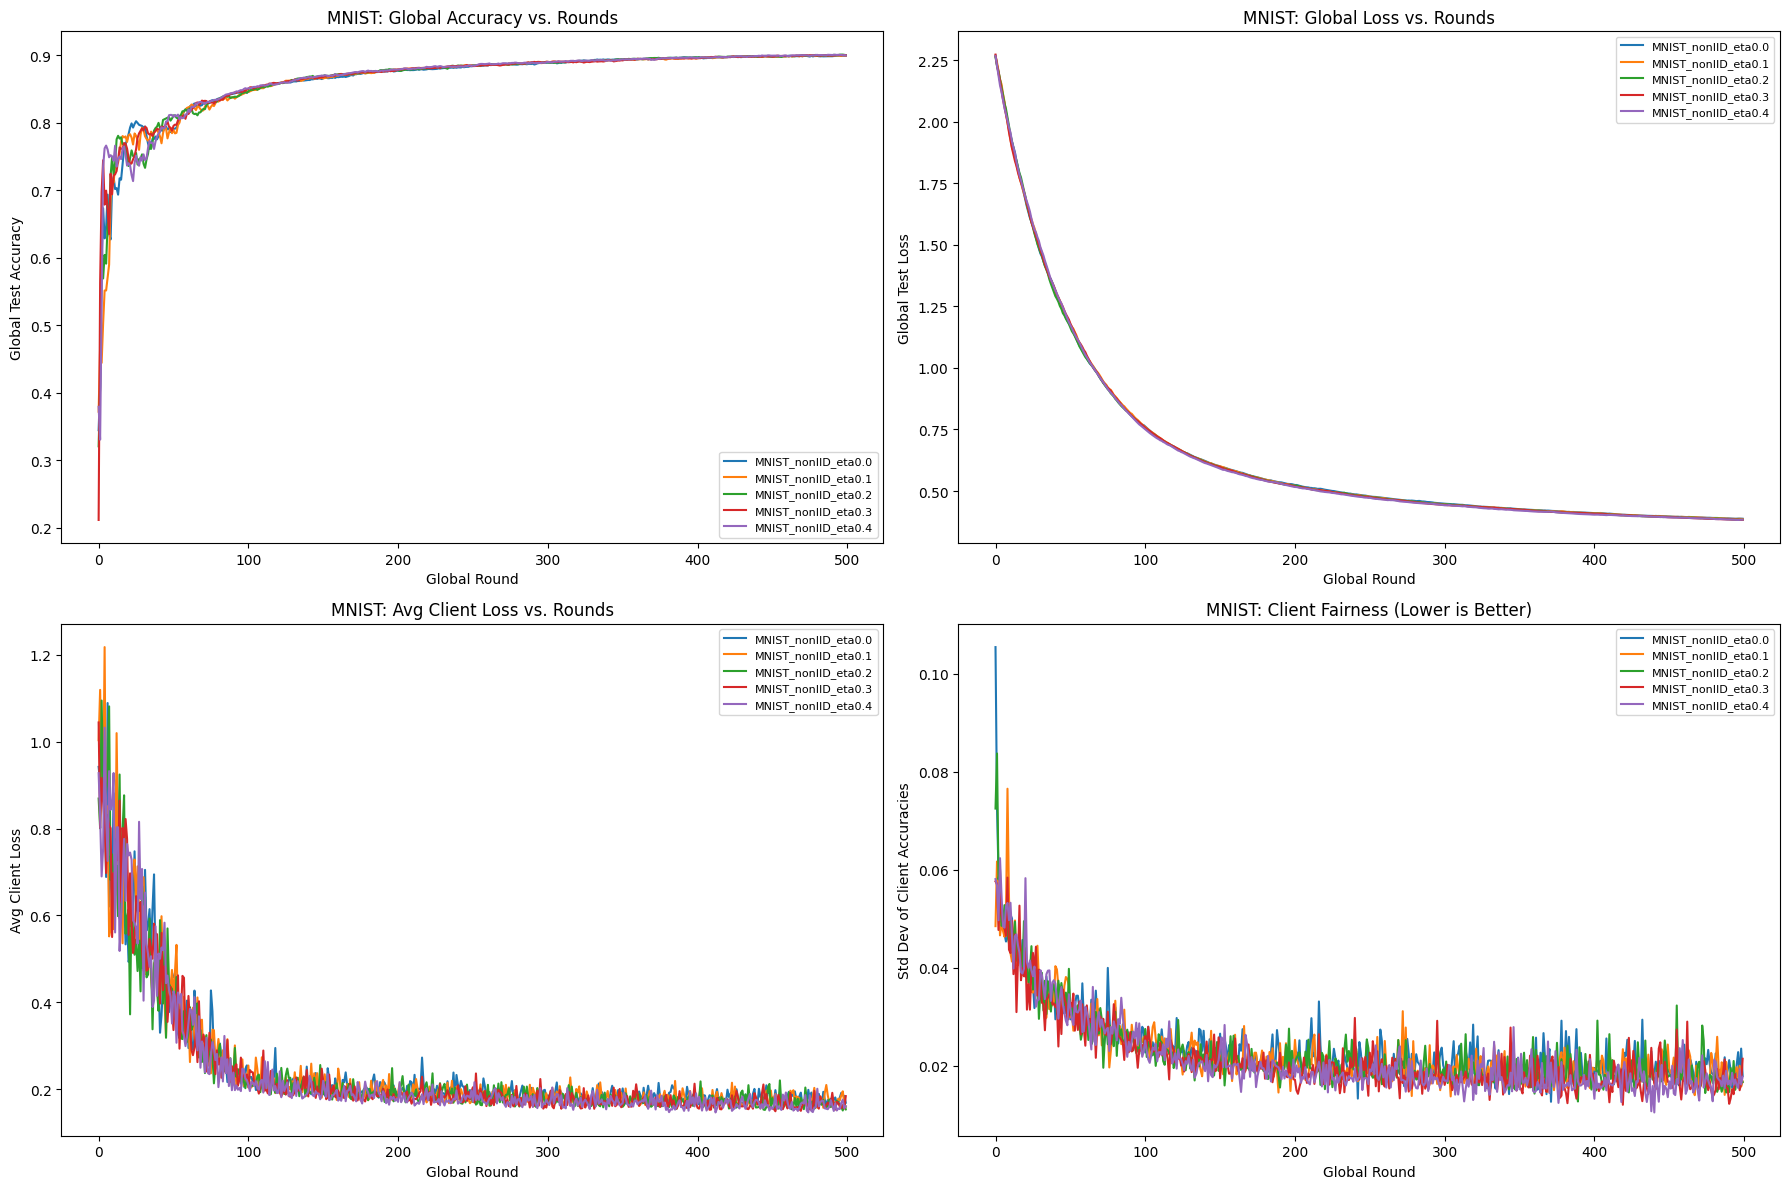

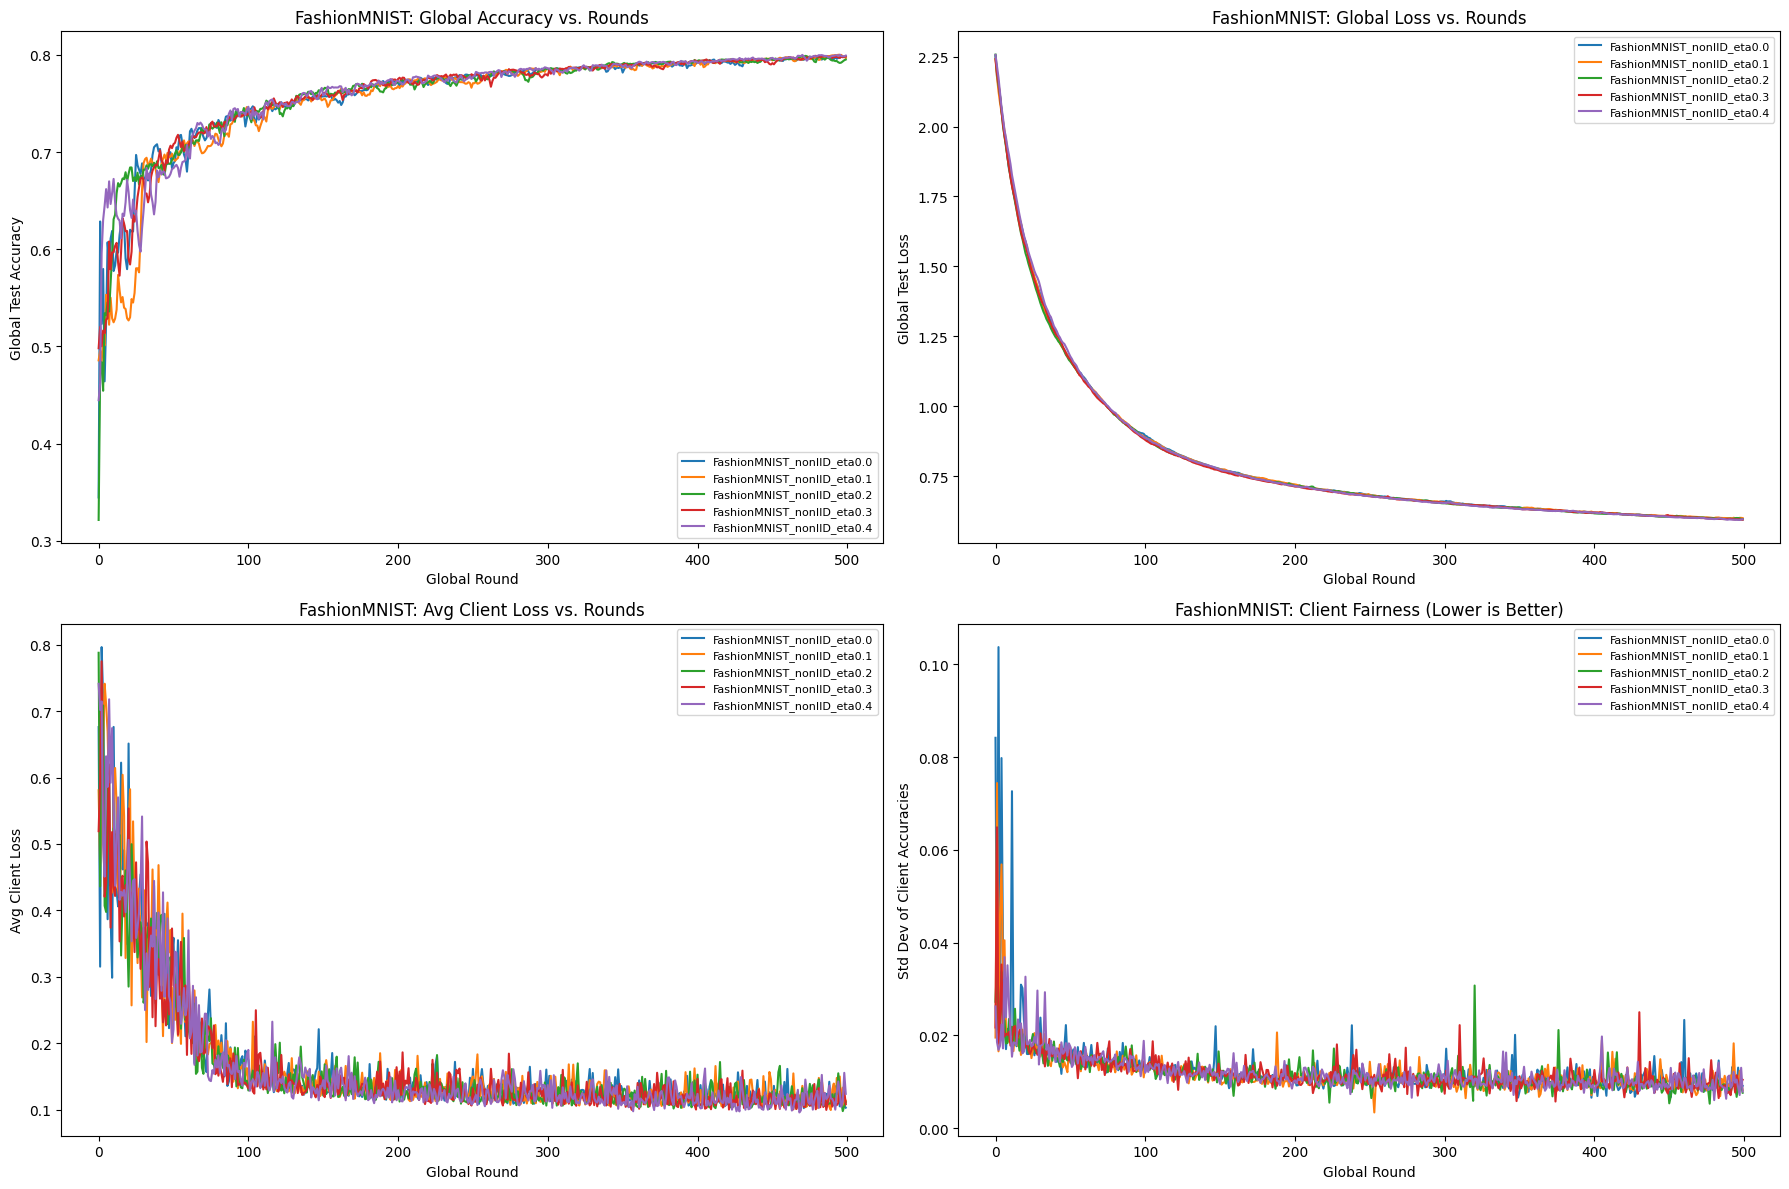

In [87]:
def plot_results_for_dataset(results, dataset_name, num_outer, eta_filter=[0.0, 0.1, 0.2, 0.3, 0.4]):
    # Filter experiments for the given dataset and desired eta values
    filtered_results = {
        k: v for k, v in results.items()
        if k.startswith(dataset_name) and any(f"eta{eta}" in k for eta in eta_filter)
    }

    rounds = np.arange(num_outer)
    plt.figure(figsize=(18, 12))

    # Plot Global Accuracy
    plt.subplot(2, 2, 1)
    for exp_name, metrics in filtered_results.items():
        plt.plot(rounds, metrics["global_acc_history"], label=exp_name)
    plt.xlabel("Global Round")
    plt.ylabel("Global Test Accuracy")
    plt.title(f"{dataset_name}: Global Accuracy vs. Rounds")
    plt.legend(fontsize=8, loc='lower right')

    # Plot Global Loss
    plt.subplot(2, 2, 2)
    for exp_name, metrics in filtered_results.items():
        plt.plot(rounds, metrics["global_loss_history"], label=exp_name)
    plt.xlabel("Global Round")
    plt.ylabel("Global Test Loss")
    plt.title(f"{dataset_name}: Global Loss vs. Rounds")
    plt.legend(fontsize=8, loc='upper right')

    # Plot Avg Client Loss
    plt.subplot(2, 2, 3)
    for exp_name, metrics in filtered_results.items():
        plt.plot(rounds, metrics["client_loss_history"], label=exp_name)
    plt.xlabel("Global Round")
    plt.ylabel("Avg Client Loss")
    plt.title(f"{dataset_name}: Avg Client Loss vs. Rounds")
    plt.legend(fontsize=8, loc='upper right')

    # Plot Fairness
    plt.subplot(2, 2, 4)
    for exp_name, metrics in filtered_results.items():
        plt.plot(rounds, metrics["fairness_history"], label=exp_name)
    plt.xlabel("Global Round")
    plt.ylabel("Std Dev of Client Accuracies")
    plt.title(f"{dataset_name}: Client Fairness (Lower is Better)")
    plt.legend(fontsize=8, loc='upper right')

    plt.tight_layout()
    plt.show()

plot_results_for_dataset(results, "MNIST", num_outer)
plot_results_for_dataset(results, "FashionMNIST", num_outer)



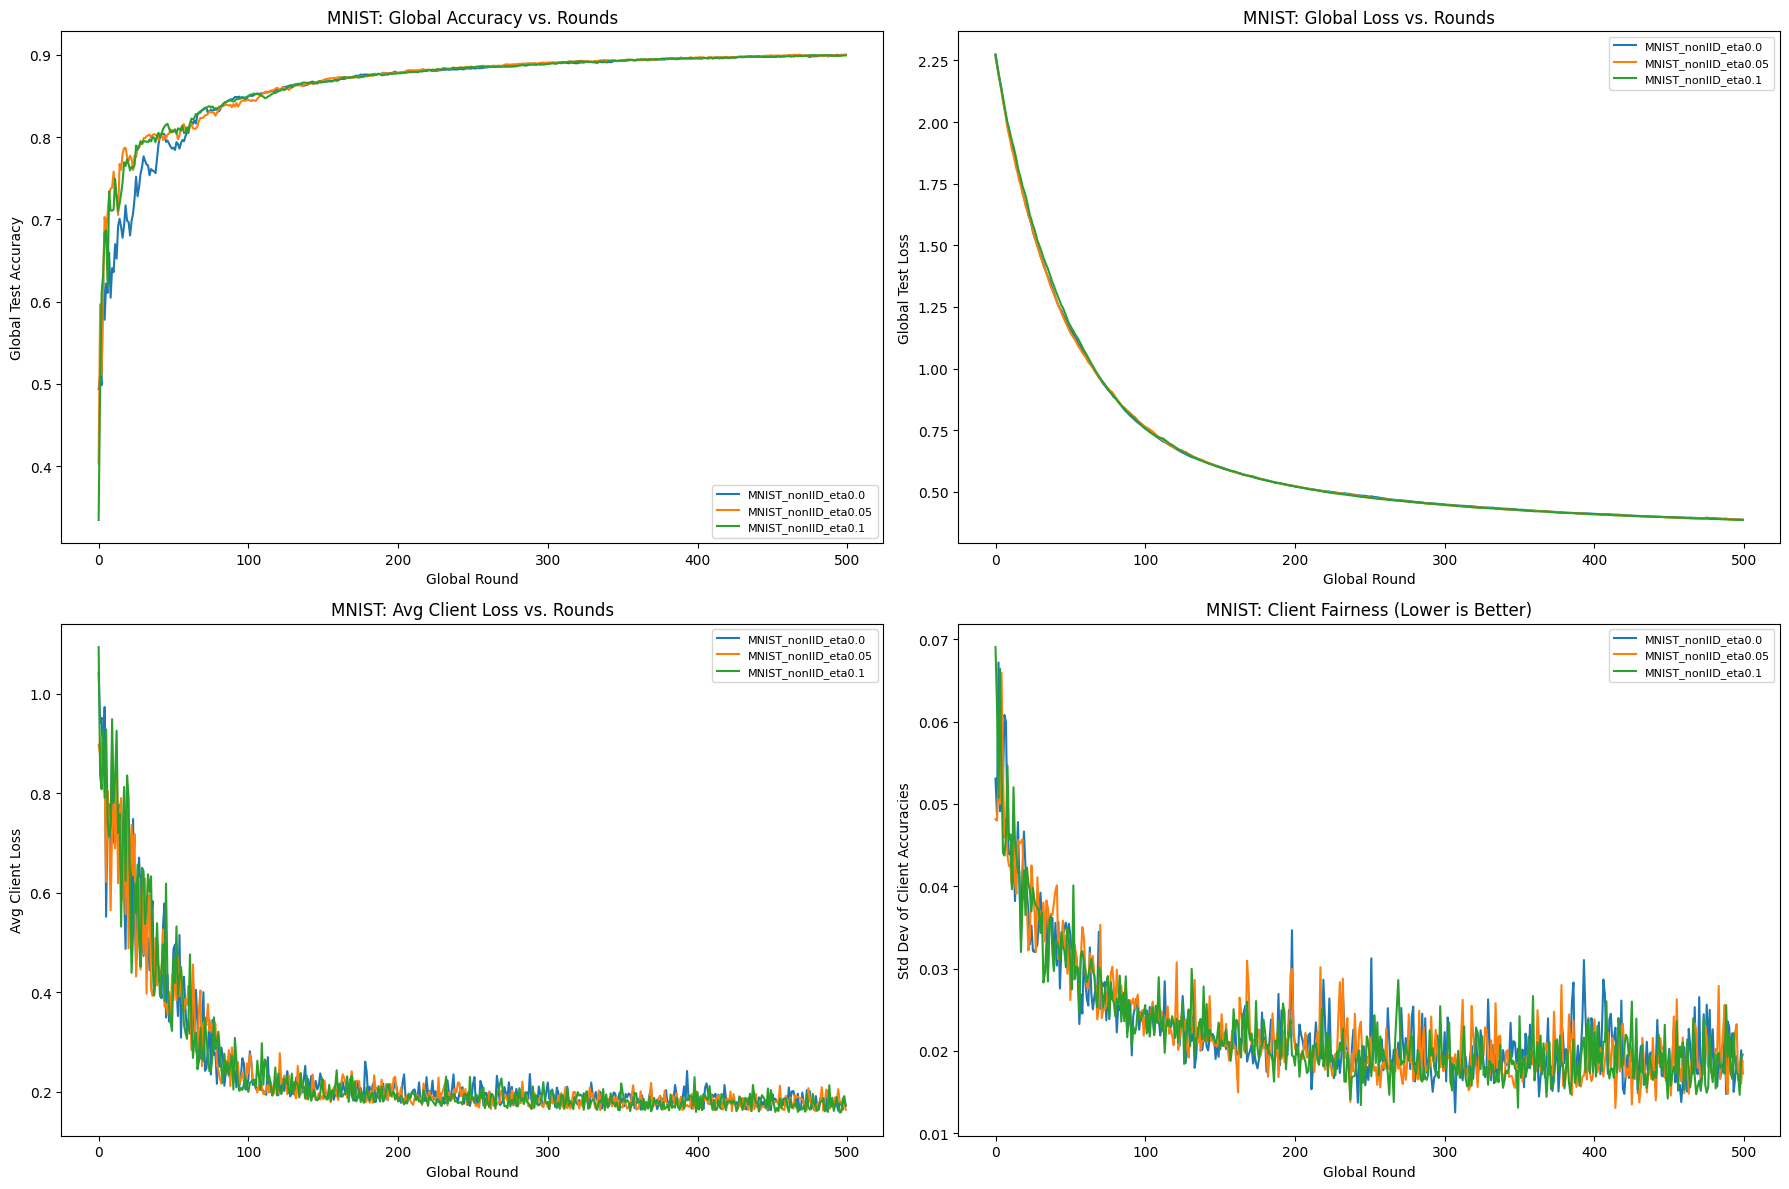

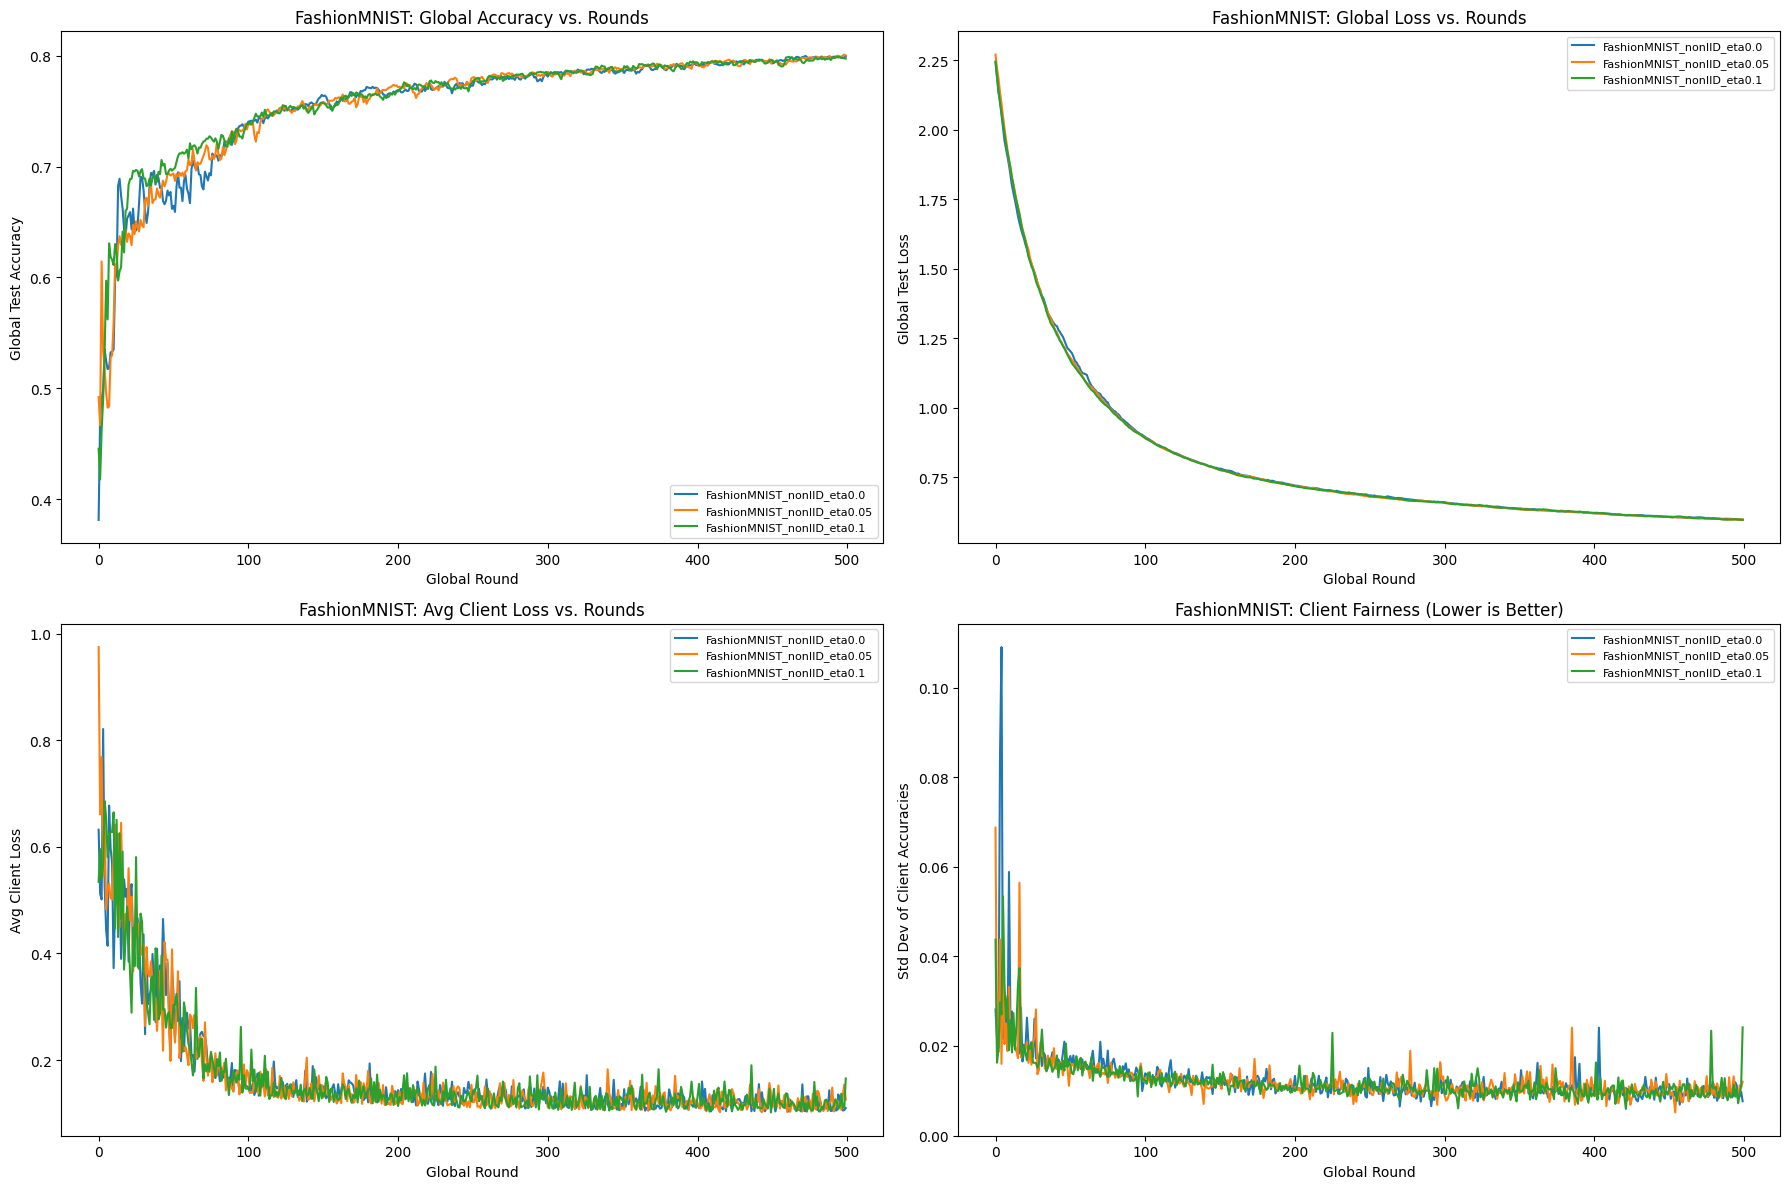

In [84]:
def plot_results_for_dataset(results, dataset_name, num_outer):
    # Filter experiments for the given dataset
    filtered_results = {k: v for k, v in results.items() if k.startswith(dataset_name)}

    rounds = np.arange(num_outer)
    plt.figure(figsize=(18, 12))

    # Plot Global Accuracy
    plt.subplot(2, 2, 1)
    for exp_name, metrics in filtered_results.items():
        plt.plot(rounds, metrics["global_acc_history"], label=exp_name)
    plt.xlabel("Global Round")
    plt.ylabel("Global Test Accuracy")
    plt.title(f"{dataset_name}: Global Accuracy vs. Rounds")
    plt.legend(fontsize=8, loc='lower right')

    # Plot Global Loss
    plt.subplot(2, 2, 2)
    for exp_name, metrics in filtered_results.items():
        plt.plot(rounds, metrics["global_loss_history"], label=exp_name)
    plt.xlabel("Global Round")
    plt.ylabel("Global Test Loss")
    plt.title(f"{dataset_name}: Global Loss vs. Rounds")
    plt.legend(fontsize=8, loc='upper right')

    # Plot Avg Client Loss
    plt.subplot(2, 2, 3)
    for exp_name, metrics in filtered_results.items():
        plt.plot(rounds, metrics["client_loss_history"], label=exp_name)
    plt.xlabel("Global Round")
    plt.ylabel("Avg Client Loss")
    plt.title(f"{dataset_name}: Avg Client Loss vs. Rounds")
    plt.legend(fontsize=8, loc='upper right')

    # Plot Fairness
    plt.subplot(2, 2, 4)
    for exp_name, metrics in filtered_results.items():
        plt.plot(rounds, metrics["fairness_history"], label=exp_name)
    plt.xlabel("Global Round")
    plt.ylabel("Std Dev of Client Accuracies")
    plt.title(f"{dataset_name}: Client Fairness (Lower is Better)")
    plt.legend(fontsize=8, loc='upper right')

    plt.tight_layout()
    plt.show()

# Plot separately
plot_results_for_dataset(results, "MNIST", num_outer)
plot_results_for_dataset(results, "FashionMNIST", num_outer)
